# Multi-View Consistent Generative Adversarial Networks for 3D-aware Image Synthesis

Authors: Xuanmeng Zhang, Zhedong Zheng, Daiheng Gao, Bang Zhang, Pan Pan, Yi Yang

Implemented By: Egemen Sert (egemen.sert@metu.edu.tr)


## Implementation Details

Paper's main idea relies on three key principles:
1. Generate two poses of an image using Neural Radiance Fields (NeRF)
2. Ensure geometric consistency using image-level optimization
3. Ensure image quality using feature-level optimization

To meet principle requirements, they have employed four neural network architectures.

1. **Mapping Network ($G_m$):** This network takes a latent vector *z* sampled from a normal 
distribution with zero mean and unit variance. Then mapping network encodes this latent
vector using four hidden layers with 256 units. Activations in between are LeakyReLU and the
network's output is a 256 dimensional **mapped** latent vector. Our mappping network implenetation
is located at `siren.py:21`.
2. **Generative Radiance Field ($G_s$\*):** Following latent generation, a neural network generates color and volume density using a 8 layered SIREN based MLP architecture with FiLM layers. You can find our SIREN implementation
at `siren.py:54`, and generator is implemented at `generator.py` 
3. **Progressive 2D Decoder:** Generater image features are decoded using a fully-convolutional
neural network that progressively enlarges the image resolution via decreasing the feature
dimension from 256 (64x64) to 32 (512x512). The decoder uses Adaptive Instance Normalization for style transfer where image features is 
normalized to standard normal and its mean & variance are scaled by the style features' statistics. You can find our implementation at `decoder.py`.
4. **Discriminator ($G_d$):** Discriminator is also a progressive convolutional neural network. We haven't implemented this as it is the same
discriminator as $\pi$-GAN. You can find source code for $\pi$-GAN's discriminator [here](https://github.com/marcoamonteiro/pi-GAN/blob/master/discriminators/sgdiscriminators.py).
In our project, discriminator is located at `discriminator.py`

$$
\begin{aligned}
w &= G_m(z) & (1) \\
\xi_{pri} &\sim p_\xi & (2) \\
\xi_{aux} &\sim p_\xi & (3) \\
\eta &\sim U(0, 1) & (4) \\
\mu &= 0.85 & (5) \\
I_{pri}, F_{pri} &= G_s(\xi_{pri}, w) & (6) \\
I_{aux}, F_{aux} &= G_s(\xi_{aux}, w) & (7) \\
I_{warp} &= K[R, t] D(v_{pri}) K^{-1} I_{pri} & (8) \\
F_{mix} &= \eta F_{pri} + (1 - \eta) F_{aux} & (9) \\
I &= G_d(w, F_{mix})  & (10) \\
y_{gen} &= D_\phi(I)  & (11) \\
y_{true} &= D_\phi(I_{real}) & (12) \\
L_{ir} &= (1 - \mu) || I_{pri} - I_{warp} ||_1 + \frac{\mu}{2} (1 - \text{SSIM}(I_{pri}, I_{warp})) & (13) \\
L_{fr} &= L_{mrf}(F_{pri}, F_{warp}) & (14) \\
V(.) &= E_{z, \xi_{pri}, \xi_{aux}}[D_\phi(y_{gen})] + E_{y_{true} \sim I}[f(-D\phi(y_{true})) - \lambda || \nabla D_\phi(I)||^2] + (L_{fr} \text{ or } L_{ir}) & (15)
\end{aligned}
$$


\* $G_s$ is combination of Generative Radiance Field and 2D decoder.

Training flow is as follows. 
- At first, we sample a fixed latent vector $z$ and encode it using the
mapping network (Eq. 1). Then we sample primary and auxiliary viewpoints (Eq. 2 and 3). Generator takes
the latent encodings $w$, along with primary and auxiliary views and generates primary and auxiliary image and feature maps (Eq. 6 and 7). 

- For geometric consistency, auxiliary image is warped into the primary image via Eq. 8. Note that camera transformation matrix $[R, t]$ is calculated
from the primary and auxiliary poses. Following this warping, network is optimized for image consistency by making sure L1 between primary
and warped image is minimal as well as perceptual similarity is maintained via SSIM loss (see Eq. 13).

- For feature consistency, features are mixed with a dynamically sampled constant $\eta$ (see Eq. 9). Then this mixed features are used SOMEHOW.

- Each batch, Stage I, Stage II and discriminator training is performed.

You can find the training flow in `main.py`. During submission of V1, we had two bugs that made our training fail. First one was gradient scaler constant dropping below one, 
and the second one was a bug in determining next upsampling step. We fixed both of the bugs and trained the network for 175K iterations.

Lastly, you can find hyperparameters used in training in `curriculum.py`.

## Results

We have trained our model using for five days using an A100 GPU on Paperspace Gradient. Our goal was to obtain 11.8 FID on Celeb-HQ dataset with 256x256 resolution. 
Although our loss curves show we had stable training, our best FID score is 26.99 obtained on 64x64 resolution. Our best FID score in 256x256 is 130.15.

Our ablations show that we can generate realistic output; however, we have also observed that our network couldn't improve FID scores following upsampling.

| | | 
|:-------------------------:|:-------------------------:|
| Loss Evolution ![](outputs/loss_evolution.png) | FID Scores ![](outputs/fid_scores.png) |

Ablations during training:

| | |
|:-------------------------:|:-------------------------:|
| Iteration 0 (64x64) ![](outputs/0_fixed_ema.png)| Iteration 30K (128x128) ![](outputs/30000_fixed_ema.png)|
| Iteration 60K (256x256) ![](outputs/60000_fixed_ema.png)| Iteration 120K (256x256) ![](outputs/120000_fixed_ema.png)|


Final Ablation
Note that final ablation has been sampled from another latent batch hence faces are different compared to
training ablations.
![](outputs/ABLATION_fixed.png)

In [2]:
!pip install gdown
!pip install --upgrade gdown
!pip install -r requirements.txt

  Attempting uninstall: gdown
    Found existing installation: gdown 4.5.1
    Uninstalling gdown-4.5.1:
      Successfully uninstalled gdown-4.5.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.1/551.1 kB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.4.0 requires tqdm>=4.62.1, but you have tqdm 4.45.0 which is incompatible.


In [2]:
!gdown "1SOw-7dLOysR3aMVtv6d3AcnJmgLDJC_C&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1SOw-7dLOysR3aMVtv6d3AcnJmgLDJC_C&confirm=t
To: /notebooks/celeb.zip.zip adlı dosyanın kopyası
100%|███████████████████████████████████████| 3.15G/3.15G [00:22<00:00, 139MB/s]


In [ ]:
!mv "celeb.zip.zip adlı dosyanın kopyası" celeb.zip
!unzip celeb.zip 'CelebAMask-HQ/CelebA-HQ-img/*' -d  '.'

Archive:  celeb.zip
   creating: ./CelebAMask-HQ/CelebA-HQ-img/
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/0.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/1.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/100.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/1000.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10000.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10001.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10002.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10003.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10004.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10005.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10006.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10007.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10008.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10009.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/1001.jpg  
  inflating: ./CelebAMask-HQ/CelebA-HQ-img/10010.jpg  
  inflating: ./C

In [ ]:
from main import train
train(0, iteration=49800)

Recovering model states.
Recovering optimizer states.


Total progress:   0%|          | 0/3000 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Output size: 128


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(

Progress to next stage:   0%|          | 0/25000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

                                                        :05<00:00, 4761.96it/s]
Progress to next stage:  99%|█████████▉| 24801/25000 [00:05<00:00, 4761.96it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.33364033699035645] [G loss: 2.953935384750366] [Step: 49800] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage:  99%|█████████▉| 24808/25000 [00:20<00:00, 917.60it/s] 
                                                                 , 799.95it/s]
Progress to next stage:  99%|█████████▉| 24811/25000 [00:26<00:00, 799.95it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.8056843280792236] [G loss: 4.142608642578125] [Step: 49810] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage:  99%|█████████▉| 24818/25000 [00:40<00:00, 300.98it/s]
                                                                 , 272.54it/s]
Progress to next stage:  99%|█████████▉| 24821/25000 [00:45<00:00, 272.54it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.5186554193496704] [G loss: 3.4256458282470703] [Step: 49820] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage:  99%|█████████▉| 24829/25000 [01:00<00:01, 124.08it/s]
                                                                 , 115.07it/s]
Progress to next stage:  99%|█████████▉| 24831/25000 [01:04<00:01, 115.07it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.5555468797683716] [G loss: 3.182677745819092] [Step: 49830] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage:  99%|█████████▉| 24840/25000 [01:21<00:02, 56.56it/s] 
                                                                 , 52.41it/s]
Progress to next stage:  99%|█████████▉| 24841/25000 [01:23<00:03, 52.41it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 1.0185811519622803] [G loss: 3.814770460128784] [Step: 49840] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage:  99%|█████████▉| 24850/25000 [01:40<00:05, 27.59it/s]
                                                                 , 25.66it/s]
Progress to next stage:  99%|█████████▉| 24851/25000 [01:42<00:05, 25.66it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.8258271813392639] [G loss: 1.2438167333602905] [Step: 49850] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage:  99%|█████████▉| 24860/25000 [02:00<00:10, 13.70it/s]
                                                                 , 12.86it/s]
Progress to next stage:  99%|█████████▉| 24861/25000 [02:02<00:10, 12.86it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.5776243805885315] [G loss: 4.528295993804932] [Step: 49860] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage:  99%|█████████▉| 24870/25000 [02:19<00:18,  7.07it/s]
                                                                    6.64it/s]
Progress to next stage:  99%|█████████▉| 24871/25000 [02:21<00:19,  6.64it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.5509408712387085] [G loss: 2.826202392578125] [Step: 49870] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24880/25000 [02:39<00:18,  6.64it/s]
                                                                    3.55it/s]
Progress to next stage: 100%|█████████▉| 24881/25000 [02:40<00:33,  3.55it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.6687883138656616] [G loss: 2.642991065979004] [Step: 49880] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24882/25000 [02:42<00:35,  3.34it/s]
                                                                    2.11it/s]
Progress to next stage: 100%|█████████▉| 24891/25000 [02:59<00:51,  2.11it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.6343224048614502] [G loss: 2.735685348510742] [Step: 49890] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24898/25000 [03:12<01:09,  1.46it/s]
                                                                    1.37it/s]
Progress to next stage: 100%|█████████▉| 24901/25000 [03:17<01:12,  1.37it/s]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.8293851613998413] [G loss: 1.1697949171066284] [Step: 49900] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24907/25000 [03:28<01:38,  1.06s/it]
                                                                    1.17s/it]
Progress to next stage: 100%|█████████▉| 24911/25000 [03:36<01:44,  1.17s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.4293147027492523] [G loss: 3.831341028213501] [Step: 49910] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24920/25000 [03:52<02:14,  1.68s/it]
                                                                    1.70s/it]
Progress to next stage: 100%|█████████▉| 24921/25000 [03:54<02:14,  1.70s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.42270854115486145] [G loss: 2.946230888366699] [Step: 49920] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24930/25000 [04:11<02:10,  1.86s/it]
                                                                    1.84s/it]
Progress to next stage: 100%|█████████▉| 24931/25000 [04:13<02:06,  1.84s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.5160568952560425] [G loss: 3.362659215927124] [Step: 49930] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24940/25000 [04:30<01:53,  1.89s/it]
                                                                    1.90s/it]
Progress to next stage: 100%|█████████▉| 24941/25000 [04:32<01:51,  1.90s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.41353851556777954] [G loss: 3.0833098888397217] [Step: 49940] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24950/25000 [04:49<01:33,  1.86s/it]
                                                                    1.96s/it]
Progress to next stage: 100%|█████████▉| 24951/25000 [04:51<01:35,  1.96s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.6571071147918701] [G loss: 1.4552655220031738] [Step: 49950] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24960/25000 [05:08<01:14,  1.87s/it]
                                                                    1.87s/it]
Progress to next stage: 100%|█████████▉| 24961/25000 [05:10<01:12,  1.87s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.4690830111503601] [G loss: 3.0717122554779053] [Step: 49960] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24970/25000 [05:27<00:54,  1.83s/it]
                                                                    1.81s/it]
Progress to next stage: 100%|█████████▉| 24971/25000 [05:28<00:52,  1.81s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.8328558206558228] [G loss: nan] [Step: 49970] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 0.5]



Progress to next stage: 100%|█████████▉| 24980/25000 [05:46<00:39,  2.00s/it]
                                                                    2.06s/it]
Progress to next stage: 100%|█████████▉| 24981/25000 [05:48<00:39,  2.06s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.4573649764060974] [G loss: 3.790924310684204] [Step: 49980] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|█████████▉| 24990/25000 [06:06<00:18,  1.89s/it]
                                                                    1.86s/it]
Progress to next stage: 100%|█████████▉| 24991/25000 [06:07<00:16,  1.86s/it]

[Experiment: outputs] [Epoch: 90/3000] [D loss: 0.9088513851165771] [G loss: 3.9041104316711426] [Step: 49990] [Alpha: 1.00] [Img Size: 128] [Batch Size: 52] [TopK: 11] [Scale: 1.0]



Progress to next stage: 100%|██████████| 25000/25000 [06:24<00:00,  1.86s/it]

Output size: 128
outputting real images...


/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


...done




  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 3/2048 [00:00<01:23, 24.44it/s]

  0%|          | 7/2048 [00:00<01:02, 32.71it/s]

  1%|          | 11/2048 [00:00<00:59, 34.50it/s]

  1%|          | 17/2048 [00:00<00:52, 39.02it/s]

  1%|          | 22/2048 [00:00<00:47, 42.22it/s]

  1%|▏         | 27/2048 [00:00<00:48, 41.32it/s]

  2%|▏         | 32/2048 [00:00<00:46, 43.39it/s]

  2%|▏         | 37/2048 [00:01<01:18, 25.74it/s]

  2%|▏         | 41/2048 [00:01<01:10, 28.32it/s]

  2%|▏         | 45/2048 [00:01<01:07, 29.72it/s]

  2%|▏         | 49/2048 [00:01<01:03, 31.45it/s]

  3%|▎         | 53/2048 [00:01<01:00, 32.97it/s]

  3%|▎         | 57/2048 [00:01<00:57, 34.45it/s]

  3%|▎         | 61/2048 [00:01<00:56, 34.90it/s]

  3%|▎         | 67/2048 [00:01<00:52, 38.04it/s]

  4%|▎         | 73/2048 [00:02<00:48, 40.45it/s]

  4%|▍         | 78/2048 [00:02<01:09, 28.20it/s]

  4%|▍         | 82/2048 [00:02<01:05, 29.90it/s]

  4%|▍         | 87/2048 [00:02<01:01, 3

  0%|          | 0.00/91.2M [00:00<?, ?B/s]



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.54it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.10it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.97it/s]

100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:00<00:03,  4.83it/s]

 19%|█▉        | 3/16 [00:00<00:01,  9.08it/s]

 31%|███▏      | 5/16 [00:00<00:01, 10.80it/s]

 44%|████▍     | 7/16 [00:00<00:00, 11.69it/s]

 56%|█████▋    | 9/16 [00:00<00:00, 12.14it/s]

 69%|██████▉   | 11/16 [00:00<00:00, 12.57it/s]

 81%|████████▏ | 13/16 [00:01<00:00, 12.73it/s]

100%|██████████| 16/16 [00:01<00:00, 11.44it/s]


have batch inconsistency. breaking.


Progress to next stage:   0%|          | 0/50000 [00:00<?, ?it/s]

Output size: 256



                                                                   4.67s/it]
Progress to next stage:   0%|          | 1/50000 [00:04<64:48:16,  4.67s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.460262656211853] [G loss: 2.5574285984039307] [Step: 50000] [Alpha: 0.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 10/50000 [00:31<36:33:26,  2.63s/it]
                                                                    2.57s/it]
Progress to next stage:   0%|          | 11/50000 [00:33<35:44:49,  2.57s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.30141639709472656] [G loss: 3.5096662044525146] [Step: 50010] [Alpha: 0.01] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 20/50000 [00:56<33:52:18,  2.44s/it]
                                                                    2.40s/it]
Progress to next stage:   0%|          | 21/50000 [00:58<33:23:12,  2.40s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.2953745126724243] [G loss: 3.3169422149658203] [Step: 50020] [Alpha: 0.01] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 30/50000 [01:20<33:59:06,  2.45s/it]
                                                                    2.40s/it]
Progress to next stage:   0%|          | 31/50000 [01:22<33:20:55,  2.40s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.33558839559555054] [G loss: 3.0425026416778564] [Step: 50030] [Alpha: 0.01] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:   0%|          | 40/50000 [01:44<34:12:53,  2.47s/it]
                                                                    2.44s/it]
Progress to next stage:   0%|          | 41/50000 [01:47<33:51:50,  2.44s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.5396344065666199] [G loss: 1.885785698890686] [Step: 50040] [Alpha: 0.02] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 50/50000 [02:09<33:39:43,  2.43s/it]
                                                                    2.40s/it]
Progress to next stage:   0%|          | 51/50000 [02:11<33:15:09,  2.40s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4844757914543152] [G loss: 1.7263736724853516] [Step: 50050] [Alpha: 0.03] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 60/50000 [02:34<35:13:59,  2.54s/it]
                                                                    2.50s/it]
Progress to next stage:   0%|          | 61/50000 [02:37<34:41:17,  2.50s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.29878175258636475] [G loss: 3.1064212322235107] [Step: 50060] [Alpha: 0.03] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 70/50000 [02:59<35:24:42,  2.55s/it]
                                                                    2.50s/it]
Progress to next stage:   0%|          | 71/50000 [03:01<34:40:41,  2.50s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.31118762493133545] [G loss: 3.3400776386260986] [Step: 50070] [Alpha: 0.04] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 80/50000 [03:23<32:56:46,  2.38s/it]
                                                                    2.36s/it]
Progress to next stage:   0%|          | 81/50000 [03:25<32:43:24,  2.36s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.29685690999031067] [G loss: 2.940321445465088] [Step: 50080] [Alpha: 0.04] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 90/50000 [03:47<32:53:56,  2.37s/it]
                                                                    2.41s/it]
Progress to next stage:   0%|          | 91/50000 [03:50<33:27:55,  2.41s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4645083248615265] [G loss: 1.4601526260375977] [Step: 50090] [Alpha: 0.04] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 100/50000 [04:12<33:06:35,  2.39s/it]
                                                                     2.37s/it]
Progress to next stage:   0%|          | 101/50000 [04:14<32:48:55,  2.37s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4723975658416748] [G loss: 1.702634334564209] [Step: 50100] [Alpha: 0.05] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 110/50000 [04:36<34:40:26,  2.50s/it]
                                                                     2.45s/it]
Progress to next stage:   0%|          | 111/50000 [04:39<33:56:02,  2.45s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.5133974552154541] [G loss: 3.652669668197632] [Step: 50110] [Alpha: 0.06] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 120/50000 [05:01<34:09:05,  2.46s/it]
                                                                     2.50s/it]
Progress to next stage:   0%|          | 121/50000 [05:04<34:38:51,  2.50s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.5149970650672913] [G loss: 3.565556049346924] [Step: 50120] [Alpha: 0.06] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 130/50000 [05:26<34:22:21,  2.48s/it]
                                                                     2.48s/it]
Progress to next stage:   0%|          | 131/50000 [05:28<34:19:41,  2.48s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.33945274353027344] [G loss: 3.3147802352905273] [Step: 50130] [Alpha: 0.07] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 140/50000 [05:50<33:31:06,  2.42s/it]
                                                                     2.39s/it]
Progress to next stage:   0%|          | 141/50000 [05:52<33:08:39,  2.39s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3475596010684967] [G loss: 2.799642562866211] [Step: 50140] [Alpha: 0.07] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 150/50000 [06:15<33:57:06,  2.45s/it]
                                                                     2.43s/it]
Progress to next stage:   0%|          | 151/50000 [06:17<33:40:35,  2.43s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3948301672935486] [G loss: 2.9762396812438965] [Step: 50150] [Alpha: 0.07] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 160/50000 [06:39<33:01:33,  2.39s/it]
                                                                     2.39s/it]
Progress to next stage:   0%|          | 161/50000 [06:42<33:04:26,  2.39s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3599761128425598] [G loss: 3.0123651027679443] [Step: 50160] [Alpha: 0.08] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 170/50000 [07:03<31:59:04,  2.31s/it]
                                                                     2.32s/it]
Progress to next stage:   0%|          | 171/50000 [07:05<32:06:03,  2.32s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.42097464203834534] [G loss: 3.421355724334717] [Step: 50170] [Alpha: 0.09] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 180/50000 [07:26<32:09:57,  2.32s/it]
                                                                     2.34s/it]
Progress to next stage:   0%|          | 181/50000 [07:28<32:24:40,  2.34s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3385087549686432] [G loss: 2.0148890018463135] [Step: 50180] [Alpha: 0.09] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 190/50000 [07:50<32:16:44,  2.33s/it]
                                                                     2.34s/it]
Progress to next stage:   0%|          | 191/50000 [07:52<32:25:05,  2.34s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.40765702724456787] [G loss: 1.8412832021713257] [Step: 50190] [Alpha: 0.10] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 200/50000 [08:13<32:22:30,  2.34s/it]
                                                                     2.36s/it]
Progress to next stage:   0%|          | 201/50000 [08:16<32:37:02,  2.36s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.5362241268157959] [G loss: 1.7347468137741089] [Step: 50200] [Alpha: 0.10] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 210/50000 [08:42<34:56:08,  2.53s/it]
                                                                     2.47s/it]
Progress to next stage:   0%|          | 211/50000 [08:44<34:13:47,  2.47s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4380166530609131] [G loss: 1.6841667890548706] [Step: 50210] [Alpha: 0.10] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 220/50000 [09:07<35:23:10,  2.56s/it]
                                                                     2.56s/it]
Progress to next stage:   0%|          | 221/50000 [09:10<35:27:37,  2.56s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.43723341822624207] [G loss: 2.4759833812713623] [Step: 50220] [Alpha: 0.11] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 230/50000 [09:33<35:58:20,  2.60s/it]
                                                                     2.51s/it]
Progress to next stage:   0%|          | 231/50000 [09:36<34:41:05,  2.51s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.5367091298103333] [G loss: 3.6558306217193604] [Step: 50230] [Alpha: 0.12] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 240/50000 [09:58<33:34:34,  2.43s/it]
                                                                     2.39s/it]
Progress to next stage:   0%|          | 241/50000 [10:00<33:05:26,  2.39s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.44707536697387695] [G loss: 2.127509832382202] [Step: 50240] [Alpha: 0.12] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   0%|          | 250/50000 [10:23<34:57:53,  2.53s/it]
                                                                     2.46s/it]
Progress to next stage:   1%|          | 251/50000 [10:25<33:57:52,  2.46s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4261053204536438] [G loss: 1.7869348526000977] [Step: 50250] [Alpha: 0.12] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 260/50000 [10:47<32:52:07,  2.38s/it]
                                                                     2.56s/it]
Progress to next stage:   1%|          | 261/50000 [10:50<35:22:35,  2.56s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.5084866881370544] [G loss: 1.8315658569335938] [Step: 50260] [Alpha: 0.13] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 270/50000 [11:12<32:59:28,  2.39s/it]
                                                                     2.46s/it]
Progress to next stage:   1%|          | 271/50000 [11:14<33:56:40,  2.46s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4090021252632141] [G loss: 3.152768135070801] [Step: 50270] [Alpha: 0.14] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 280/50000 [11:36<34:02:01,  2.46s/it]
                                                                     2.44s/it]
Progress to next stage:   1%|          | 281/50000 [11:38<33:44:48,  2.44s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3966718912124634] [G loss: 3.3577826023101807] [Step: 50280] [Alpha: 0.14] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 290/50000 [12:00<33:03:16,  2.39s/it]
                                                                     2.41s/it]
Progress to next stage:   1%|          | 291/50000 [12:02<33:12:49,  2.41s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3853597044944763] [G loss: 2.0504696369171143] [Step: 50290] [Alpha: 0.14] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 300/50000 [12:24<32:54:57,  2.38s/it]
                                                                     2.50s/it]
Progress to next stage:   1%|          | 301/50000 [12:27<34:30:46,  2.50s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3761422634124756] [G loss: 3.1591475009918213] [Step: 50300] [Alpha: 0.15] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 310/50000 [12:49<34:58:37,  2.53s/it]
                                                                     2.50s/it]
Progress to next stage:   1%|          | 311/50000 [12:52<34:32:35,  2.50s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.405337393283844] [G loss: 4.012654781341553] [Step: 50310] [Alpha: 0.15] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 320/50000 [13:14<34:30:52,  2.50s/it]
                                                                     2.46s/it]
Progress to next stage:   1%|          | 321/50000 [13:17<33:55:15,  2.46s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.5379675626754761] [G loss: 3.4140281677246094] [Step: 50320] [Alpha: 0.16] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 330/50000 [13:38<33:02:35,  2.39s/it]
                                                                     2.37s/it]
Progress to next stage:   1%|          | 331/50000 [13:41<32:45:21,  2.37s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.42681893706321716] [G loss: 4.043584823608398] [Step: 50330] [Alpha: 0.17] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 340/50000 [14:03<33:36:54,  2.44s/it]
                                                                     2.50s/it]
Progress to next stage:   1%|          | 341/50000 [14:06<34:30:00,  2.50s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4306913912296295] [G loss: 3.3847367763519287] [Step: 50340] [Alpha: 0.17] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 350/50000 [14:27<33:43:39,  2.45s/it]
                                                                     2.44s/it]
Progress to next stage:   1%|          | 351/50000 [14:30<33:42:25,  2.44s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.2969321310520172] [G loss: 2.6653013229370117] [Step: 50350] [Alpha: 0.17] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 360/50000 [14:53<34:06:10,  2.47s/it]
                                                                     2.54s/it]
Progress to next stage:   1%|          | 361/50000 [14:55<35:03:02,  2.54s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.44172990322113037] [G loss: 1.5600899457931519] [Step: 50360] [Alpha: 0.18] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 370/50000 [15:18<33:26:07,  2.43s/it]
                                                                     2.46s/it]
Progress to next stage:   1%|          | 371/50000 [15:20<33:58:49,  2.46s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.37349820137023926] [G loss: 4.169271469116211] [Step: 50370] [Alpha: 0.18] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 380/50000 [15:42<33:46:54,  2.45s/it]
                                                                     2.40s/it]
Progress to next stage:   1%|          | 381/50000 [15:45<33:02:47,  2.40s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4428228735923767] [G loss: 3.166449785232544] [Step: 50380] [Alpha: 0.19] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 390/50000 [16:07<33:17:45,  2.42s/it]
                                                                     2.43s/it]
Progress to next stage:   1%|          | 391/50000 [16:09<33:25:57,  2.43s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.32620054483413696] [G loss: 3.2140042781829834] [Step: 50390] [Alpha: 0.20] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 400/50000 [16:31<32:57:42,  2.39s/it]
                                                                     2.42s/it]
Progress to next stage:   1%|          | 401/50000 [16:33<33:18:28,  2.42s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.29809248447418213] [G loss: 2.504794120788574] [Step: 50400] [Alpha: 0.20] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 410/50000 [17:00<35:39:20,  2.59s/it]
                                                                     2.50s/it]
Progress to next stage:   1%|          | 411/50000 [17:02<34:25:29,  2.50s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.37702101469039917] [G loss: 4.14616060256958] [Step: 50410] [Alpha: 0.20] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 420/50000 [17:24<35:18:40,  2.56s/it]
                                                                     2.58s/it]
Progress to next stage:   1%|          | 421/50000 [17:27<35:28:48,  2.58s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3565625846385956] [G loss: 2.310488224029541] [Step: 50420] [Alpha: 0.21] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 430/50000 [17:49<34:20:16,  2.49s/it]
                                                                     2.46s/it]
Progress to next stage:   1%|          | 431/50000 [17:52<33:55:31,  2.46s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.33900970220565796] [G loss: 2.3234176635742188] [Step: 50430] [Alpha: 0.21] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 440/50000 [18:15<34:53:17,  2.53s/it]
                                                                     2.48s/it]
Progress to next stage:   1%|          | 441/50000 [18:17<34:06:22,  2.48s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.5498858094215393] [G loss: 3.687040328979492] [Step: 50440] [Alpha: 0.22] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 450/50000 [18:39<33:40:17,  2.45s/it]
                                                                     2.41s/it]
Progress to next stage:   1%|          | 451/50000 [18:42<33:12:16,  2.41s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.560088574886322] [G loss: 1.377255916595459] [Step: 50450] [Alpha: 0.23] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 460/50000 [19:04<35:47:40,  2.60s/it]
                                                                     2.70s/it]
Progress to next stage:   1%|          | 461/50000 [19:07<37:09:33,  2.70s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.36922726035118103] [G loss: 1.8136699199676514] [Step: 50460] [Alpha: 0.23] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 470/50000 [19:29<32:34:03,  2.37s/it]
                                                                     2.43s/it]
Progress to next stage:   1%|          | 471/50000 [19:31<33:26:16,  2.43s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3490816354751587] [G loss: 2.265965700149536] [Step: 50470] [Alpha: 0.23] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 480/50000 [19:53<32:39:31,  2.37s/it]
                                                                     2.35s/it]
Progress to next stage:   1%|          | 481/50000 [19:55<32:22:11,  2.35s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.30804258584976196] [G loss: 2.743079900741577] [Step: 50480] [Alpha: 0.24] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 490/50000 [20:17<33:18:36,  2.42s/it]
                                                                     2.38s/it]
Progress to next stage:   1%|          | 491/50000 [20:20<32:43:18,  2.38s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3754008412361145] [G loss: 1.5820845365524292] [Step: 50490] [Alpha: 0.24] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 500/50000 [20:42<33:46:24,  2.46s/it]
                                                                     2.42s/it]
Progress to next stage:   1%|          | 501/50000 [20:44<33:19:12,  2.42s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3580368459224701] [G loss: 3.364535093307495] [Step: 50500] [Alpha: 0.25] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 510/50000 [21:07<33:42:21,  2.45s/it]
                                                                     2.41s/it]
Progress to next stage:   1%|          | 511/50000 [21:09<33:07:52,  2.41s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.32118654251098633] [G loss: 2.6779305934906006] [Step: 50510] [Alpha: 0.26] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 520/50000 [21:30<32:14:29,  2.35s/it]
                                                                     2.33s/it]
Progress to next stage:   1%|          | 521/50000 [21:32<31:58:35,  2.33s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4310912489891052] [G loss: 2.053525924682617] [Step: 50520] [Alpha: 0.26] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 530/50000 [21:55<33:05:46,  2.41s/it]
                                                                     2.38s/it]
Progress to next stage:   1%|          | 531/50000 [21:57<32:42:34,  2.38s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.30460861325263977] [G loss: 2.354721784591675] [Step: 50530] [Alpha: 0.27] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 540/50000 [22:19<32:33:38,  2.37s/it]
                                                                     2.35s/it]
Progress to next stage:   1%|          | 541/50000 [22:21<32:20:35,  2.35s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.29303139448165894] [G loss: 2.90580153465271] [Step: 50540] [Alpha: 0.27] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 550/50000 [22:43<34:37:33,  2.52s/it]
                                                                     2.54s/it]
Progress to next stage:   1%|          | 551/50000 [22:46<34:56:12,  2.54s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.37720173597335815] [G loss: 2.8921258449554443] [Step: 50550] [Alpha: 0.28] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 560/50000 [23:08<33:47:44,  2.46s/it]
                                                                     2.45s/it]
Progress to next stage:   1%|          | 561/50000 [23:11<33:36:58,  2.45s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3751400411128998] [G loss: 2.563605546951294] [Step: 50560] [Alpha: 0.28] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 570/50000 [23:32<32:50:58,  2.39s/it]
                                                                     2.36s/it]
Progress to next stage:   1%|          | 571/50000 [23:34<32:22:26,  2.36s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.4514977037906647] [G loss: 2.1936302185058594] [Step: 50570] [Alpha: 0.28] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 580/50000 [23:56<35:24:31,  2.58s/it]
                                                                     2.51s/it]
Progress to next stage:   1%|          | 581/50000 [23:59<34:30:49,  2.51s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.36290040612220764] [G loss: 3.1124658584594727] [Step: 50580] [Alpha: 0.29] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 590/50000 [24:20<33:34:44,  2.45s/it]
                                                                     2.44s/it]
Progress to next stage:   1%|          | 591/50000 [24:23<33:32:32,  2.44s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.30743271112442017] [G loss: 2.3072328567504883] [Step: 50590] [Alpha: 0.29] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 600/50000 [24:44<32:59:42,  2.40s/it]
                                                                     2.36s/it]
Progress to next stage:   1%|          | 601/50000 [24:47<32:25:15,  2.36s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3926950693130493] [G loss: 2.7499780654907227] [Step: 50600] [Alpha: 0.30] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 610/50000 [25:13<34:04:28,  2.48s/it]
                                                                     2.45s/it]
Progress to next stage:   1%|          | 611/50000 [25:15<33:36:10,  2.45s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3580937087535858] [G loss: 2.685753345489502] [Step: 50610] [Alpha: 0.30] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|          | 620/50000 [25:37<32:52:24,  2.40s/it]
                                                                     2.38s/it]
Progress to next stage:   1%|          | 621/50000 [25:39<32:36:11,  2.38s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.35615217685699463] [G loss: 2.8423542976379395] [Step: 50620] [Alpha: 0.31] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 630/50000 [26:02<34:01:59,  2.48s/it]
                                                                     2.42s/it]
Progress to next stage:   1%|▏         | 631/50000 [26:04<33:08:20,  2.42s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.493388295173645] [G loss: 3.549694776535034] [Step: 50630] [Alpha: 0.32] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 640/50000 [26:26<33:33:27,  2.45s/it]
                                                                     2.40s/it]
Progress to next stage:   1%|▏         | 641/50000 [26:28<32:56:00,  2.40s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.35562050342559814] [G loss: 1.868433952331543] [Step: 50640] [Alpha: 0.32] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 650/50000 [26:51<34:19:54,  2.50s/it]
                                                                     2.45s/it]
Progress to next stage:   1%|▏         | 651/50000 [26:53<33:38:59,  2.45s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3549160361289978] [G loss: 2.7129669189453125] [Step: 50650] [Alpha: 0.33] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 660/50000 [27:15<34:12:08,  2.50s/it]
                                                                     2.49s/it]
Progress to next stage:   1%|▏         | 661/50000 [27:17<34:03:52,  2.49s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.3265465199947357] [G loss: 2.91439151763916] [Step: 50660] [Alpha: 0.33] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 670/50000 [27:39<32:21:02,  2.36s/it]
                                                                     2.46s/it]
Progress to next stage:   1%|▏         | 671/50000 [27:42<33:46:15,  2.46s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.318407267332077] [G loss: 2.532716751098633] [Step: 50670] [Alpha: 0.34] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 680/50000 [28:02<31:30:31,  2.30s/it]
                                                                     2.28s/it]
Total progress:   3%|▎         | 93/3000 [35:52<24:50:44, 30.77s/it] 2.28s/it]

[Experiment: outputs] [Epoch: 91/3000] [D loss: 0.29267576336860657] [G loss: 3.037698268890381] [Step: 50680] [Alpha: 0.34] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                     2.87s/it]
Progress to next stage:   1%|▏         | 682/50000 [28:09<39:16:28,  2.87s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3329402208328247] [G loss: 2.2795982360839844] [Step: 50681] [Alpha: 0.34] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 691/50000 [28:31<33:59:00,  2.48s/it]
                                                                     2.47s/it]
Progress to next stage:   1%|▏         | 692/50000 [28:34<33:48:49,  2.47s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3089773654937744] [G loss: 3.5325920581817627] [Step: 50691] [Alpha: 0.35] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 701/50000 [28:56<34:57:28,  2.55s/it]
                                                                     2.53s/it]
Progress to next stage:   1%|▏         | 702/50000 [28:58<34:37:25,  2.53s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3974629044532776] [G loss: 2.1426353454589844] [Step: 50701] [Alpha: 0.35] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 711/50000 [29:21<34:42:37,  2.54s/it]
                                                                     2.52s/it]
Progress to next stage:   1%|▏         | 712/50000 [29:23<34:33:08,  2.52s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.2696087956428528] [G loss: 4.121938705444336] [Step: 50711] [Alpha: 0.36] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 721/50000 [29:45<33:16:11,  2.43s/it]
                                                                     2.44s/it]
Progress to next stage:   1%|▏         | 722/50000 [29:47<33:26:10,  2.44s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.29109352827072144] [G loss: 2.635725975036621] [Step: 50721] [Alpha: 0.36] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 731/50000 [30:10<34:14:32,  2.50s/it]
                                                                     2.51s/it]
Progress to next stage:   1%|▏         | 732/50000 [30:12<34:22:52,  2.51s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.32922905683517456] [G loss: 3.845627546310425] [Step: 50731] [Alpha: 0.37] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   1%|▏         | 741/50000 [30:35<34:36:58,  2.53s/it]
                                                                     2.53s/it]
Progress to next stage:   1%|▏         | 742/50000 [30:38<34:35:28,  2.53s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.2980878949165344] [G loss: 3.808159351348877] [Step: 50741] [Alpha: 0.37] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 751/50000 [31:02<35:46:12,  2.61s/it]
                                                                     2.56s/it]
Progress to next stage:   2%|▏         | 752/50000 [31:04<35:01:07,  2.56s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.40651172399520874] [G loss: 3.647068500518799] [Step: 50751] [Alpha: 0.38] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 761/50000 [31:28<35:09:38,  2.57s/it]
                                                                     2.55s/it]
Progress to next stage:   2%|▏         | 762/50000 [31:30<34:56:12,  2.55s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.33228710293769836] [G loss: 3.617241382598877] [Step: 50761] [Alpha: 0.38] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 771/50000 [31:53<34:42:10,  2.54s/it]
                                                                     2.54s/it]
Progress to next stage:   2%|▏         | 772/50000 [31:56<34:41:39,  2.54s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.5102856159210205] [G loss: 1.0270355939865112] [Step: 50771] [Alpha: 0.39] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 781/50000 [32:18<34:36:09,  2.53s/it]
                                                                     2.51s/it]
Progress to next stage:   2%|▏         | 782/50000 [32:21<34:19:47,  2.51s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.33992013335227966] [G loss: 3.6996688842773438] [Step: 50781] [Alpha: 0.39] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 791/50000 [32:43<33:25:21,  2.45s/it]
                                                                     2.44s/it]
Progress to next stage:   2%|▏         | 792/50000 [32:45<33:24:33,  2.44s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.31571149826049805] [G loss: 3.0105817317962646] [Step: 50791] [Alpha: 0.40] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 801/50000 [33:08<34:37:50,  2.53s/it]
                                                                     3.83s/it]
Progress to next stage:   2%|▏         | 802/50000 [33:15<52:16:55,  3.83s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.31139904260635376] [G loss: 3.5374016761779785] [Step: 50801] [Alpha: 0.40] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 811/50000 [33:38<35:05:53,  2.57s/it]
                                                                     2.50s/it]
Progress to next stage:   2%|▏         | 812/50000 [33:40<34:12:50,  2.50s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.29386836290359497] [G loss: 2.696699857711792] [Step: 50811] [Alpha: 0.41] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 821/50000 [34:02<33:23:04,  2.44s/it]
                                                                     2.44s/it]
Progress to next stage:   2%|▏         | 822/50000 [34:05<33:18:18,  2.44s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.2824285626411438] [G loss: 2.685359477996826] [Step: 50821] [Alpha: 0.41] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 831/50000 [34:27<33:32:14,  2.46s/it]
                                                                     2.52s/it]
Progress to next stage:   2%|▏         | 832/50000 [34:30<34:25:54,  2.52s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.31124651432037354] [G loss: 2.0062098503112793] [Step: 50831] [Alpha: 0.42] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 841/50000 [34:52<33:28:42,  2.45s/it]
                                                                     2.42s/it]
Progress to next stage:   2%|▏         | 842/50000 [34:54<33:04:05,  2.42s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3177603483200073] [G loss: 2.7931551933288574] [Step: 50841] [Alpha: 0.42] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 851/50000 [35:17<33:48:15,  2.48s/it]
                                                                     2.50s/it]
Progress to next stage:   2%|▏         | 852/50000 [35:19<34:10:28,  2.50s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3403246998786926] [G loss: 3.718653678894043] [Step: 50851] [Alpha: 0.43] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 861/50000 [35:42<33:22:31,  2.45s/it]
                                                                     2.46s/it]
Progress to next stage:   2%|▏         | 862/50000 [35:44<33:34:06,  2.46s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.47760021686553955] [G loss: 3.167241334915161] [Step: 50861] [Alpha: 0.43] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 871/50000 [36:07<34:35:04,  2.53s/it]
                                                                     2.50s/it]
Progress to next stage:   2%|▏         | 872/50000 [36:09<34:09:00,  2.50s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: nan] [G loss: 2.8709657192230225] [Step: 50871] [Alpha: 0.44] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:   2%|▏         | 881/50000 [36:31<33:40:44,  2.47s/it]
                                                                     2.49s/it]
Progress to next stage:   2%|▏         | 882/50000 [36:34<34:01:14,  2.49s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3562335968017578] [G loss: 3.987651824951172] [Step: 50881] [Alpha: 0.44] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 891/50000 [36:57<33:47:40,  2.48s/it]
                                                                     2.46s/it]
Progress to next stage:   2%|▏         | 892/50000 [36:59<33:36:05,  2.46s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3331518769264221] [G loss: 3.348937749862671] [Step: 50891] [Alpha: 0.45] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 901/50000 [37:21<33:36:51,  2.46s/it]
                                                                     2.44s/it]
Progress to next stage:   2%|▏         | 902/50000 [37:24<33:18:32,  2.44s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.5301379561424255] [G loss: 0.9345805048942566] [Step: 50901] [Alpha: 0.45] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 911/50000 [37:46<34:11:47,  2.51s/it]
                                                                     2.51s/it]
Progress to next stage:   2%|▏         | 912/50000 [37:49<34:17:29,  2.51s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.29865801334381104] [G loss: 3.892179250717163] [Step: 50911] [Alpha: 0.46] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 921/50000 [38:12<34:16:10,  2.51s/it]
                                                                     2.48s/it]
Progress to next stage:   2%|▏         | 922/50000 [38:14<33:50:51,  2.48s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.6985206007957458] [G loss: 1.1850416660308838] [Step: 50921] [Alpha: 0.46] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 931/50000 [38:37<33:17:43,  2.44s/it]
                                                                     2.52s/it]
Progress to next stage:   2%|▏         | 932/50000 [38:39<34:17:24,  2.52s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.2872079908847809] [G loss: 2.637953758239746] [Step: 50931] [Alpha: 0.47] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 941/50000 [39:01<33:45:55,  2.48s/it]
                                                                     2.45s/it]
Progress to next stage:   2%|▏         | 942/50000 [39:04<33:25:59,  2.45s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.39619362354278564] [G loss: 2.2196860313415527] [Step: 50941] [Alpha: 0.47] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 951/50000 [39:26<33:57:24,  2.49s/it]
                                                                     2.46s/it]
Progress to next stage:   2%|▏         | 952/50000 [39:28<33:32:59,  2.46s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.41635361313819885] [G loss: 3.512949228286743] [Step: 50951] [Alpha: 0.48] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 961/50000 [39:52<34:58:14,  2.57s/it]
                                                                     2.52s/it]
Progress to next stage:   2%|▏         | 962/50000 [39:54<34:19:49,  2.52s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.33570539951324463] [G loss: 3.6220757961273193] [Step: 50961] [Alpha: 0.48] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 971/50000 [40:16<33:28:31,  2.46s/it]
                                                                     2.44s/it]
Progress to next stage:   2%|▏         | 972/50000 [40:19<33:13:32,  2.44s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3013930320739746] [G loss: 3.488182306289673] [Step: 50971] [Alpha: 0.49] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 981/50000 [40:41<33:15:18,  2.44s/it]
                                                                     2.43s/it]
Progress to next stage:   2%|▏         | 982/50000 [40:43<33:04:23,  2.43s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.34267526865005493] [G loss: 1.8742784261703491] [Step: 50981] [Alpha: 0.49] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 991/50000 [41:06<34:42:38,  2.55s/it]
                                                                     2.50s/it]
Progress to next stage:   2%|▏         | 992/50000 [41:08<34:04:40,  2.50s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3734931945800781] [G loss: 2.8144428730010986] [Step: 50991] [Alpha: 0.50] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1001/50000 [41:31<33:27:34,  2.46s/it]
                                                                      3.73s/it]
Progress to next stage:   2%|▏         | 1002/50000 [41:37<50:45:53,  3.73s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.6680752635002136] [G loss: 4.323408603668213] [Step: 51001] [Alpha: 0.50] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1011/50000 [42:00<34:58:48,  2.57s/it]
                                                                      2.55s/it]
Progress to next stage:   2%|▏         | 1012/50000 [42:03<34:38:45,  2.55s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3303784430027008] [G loss: 3.7456047534942627] [Step: 51011] [Alpha: 0.51] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1021/50000 [42:25<34:24:37,  2.53s/it]
                                                                      2.50s/it]
Progress to next stage:   2%|▏         | 1022/50000 [42:27<34:00:25,  2.50s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3532869815826416] [G loss: 2.1331515312194824] [Step: 51021] [Alpha: 0.51] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1031/50000 [42:50<33:53:12,  2.49s/it]
                                                                      2.47s/it]
Progress to next stage:   2%|▏         | 1032/50000 [42:52<33:37:38,  2.47s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3058103621006012] [G loss: 3.682446241378784] [Step: 51031] [Alpha: 0.52] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1041/50000 [43:15<34:44:28,  2.55s/it]
                                                                      2.51s/it]
Progress to next stage:   2%|▏         | 1042/50000 [43:18<34:05:28,  2.51s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.30671384930610657] [G loss: 2.236572027206421] [Step: 51041] [Alpha: 0.52] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1051/50000 [43:40<34:12:52,  2.52s/it]
                                                                      2.48s/it]
Progress to next stage:   2%|▏         | 1052/50000 [43:43<33:45:58,  2.48s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.37774860858917236] [G loss: 4.2664475440979] [Step: 51051] [Alpha: 0.53] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1061/50000 [44:05<33:21:18,  2.45s/it]
                                                                      2.44s/it]
Progress to next stage:   2%|▏         | 1062/50000 [44:07<33:11:15,  2.44s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.4517139196395874] [G loss: 3.982349395751953] [Step: 51061] [Alpha: 0.53] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1071/50000 [44:29<33:29:33,  2.46s/it]
                                                                      2.47s/it]
Progress to next stage:   2%|▏         | 1072/50000 [44:32<33:36:07,  2.47s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.34096139669418335] [G loss: 3.3952221870422363] [Step: 51071] [Alpha: 0.54] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1081/50000 [44:54<33:52:36,  2.49s/it]
                                                                      2.56s/it]
Progress to next stage:   2%|▏         | 1082/50000 [44:57<34:51:02,  2.56s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3620796799659729] [G loss: 3.3306796550750732] [Step: 51081] [Alpha: 0.54] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1091/50000 [45:20<34:47:17,  2.56s/it]
                                                                      2.52s/it]
Progress to next stage:   2%|▏         | 1092/50000 [45:22<34:16:36,  2.52s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.32259368896484375] [G loss: 3.004448175430298] [Step: 51091] [Alpha: 0.55] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1101/50000 [45:44<33:36:53,  2.47s/it]
                                                                      2.47s/it]
Progress to next stage:   2%|▏         | 1102/50000 [45:47<33:30:51,  2.47s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.4869231581687927] [G loss: 1.9691506624221802] [Step: 51101] [Alpha: 0.55] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1111/50000 [46:09<34:17:53,  2.53s/it]
                                                                      2.50s/it]
Progress to next stage:   2%|▏         | 1112/50000 [46:11<33:54:11,  2.50s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3297511041164398] [G loss: 2.3967247009277344] [Step: 51111] [Alpha: 0.56] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1121/50000 [46:34<33:56:00,  2.50s/it]
                                                                      2.54s/it]
Progress to next stage:   2%|▏         | 1122/50000 [46:37<34:31:31,  2.54s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.36771419644355774] [G loss: 3.442340612411499] [Step: 51121] [Alpha: 0.56] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1131/50000 [47:00<34:29:34,  2.54s/it]
                                                                      2.56s/it]
Progress to next stage:   2%|▏         | 1132/50000 [47:02<34:48:15,  2.56s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3706394135951996] [G loss: 1.8580126762390137] [Step: 51131] [Alpha: 0.57] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1141/50000 [47:26<35:24:44,  2.61s/it]
                                                                      2.57s/it]
Progress to next stage:   2%|▏         | 1142/50000 [47:28<34:54:45,  2.57s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3331140875816345] [G loss: 2.911698341369629] [Step: 51141] [Alpha: 0.57] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1151/50000 [47:52<36:00:13,  2.65s/it]
                                                                      2.73s/it]
Progress to next stage:   2%|▏         | 1152/50000 [47:55<37:05:18,  2.73s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.38309940695762634] [G loss: 3.720672130584717] [Step: 51151] [Alpha: 0.58] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1161/50000 [48:18<34:54:21,  2.57s/it]
                                                                      2.60s/it]
Progress to next stage:   2%|▏         | 1162/50000 [48:21<35:15:21,  2.60s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3128795027732849] [G loss: 3.559150457382202] [Step: 51161] [Alpha: 0.58] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1171/50000 [48:44<35:57:35,  2.65s/it]
                                                                      2.60s/it]
Progress to next stage:   2%|▏         | 1172/50000 [48:47<35:15:42,  2.60s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.35513851046562195] [G loss: 3.621013641357422] [Step: 51171] [Alpha: 0.59] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1181/50000 [49:09<34:17:07,  2.53s/it]
                                                                      2.59s/it]
Progress to next stage:   2%|▏         | 1182/50000 [49:12<35:06:52,  2.59s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.31892672181129456] [G loss: 3.633892774581909] [Step: 51181] [Alpha: 0.59] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1191/50000 [49:36<35:59:27,  2.65s/it]
                                                                      2.66s/it]
Progress to next stage:   2%|▏         | 1192/50000 [49:38<36:03:54,  2.66s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.6058610081672668] [G loss: 3.2029130458831787] [Step: 51191] [Alpha: 0.60] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1201/50000 [50:02<34:56:20,  2.58s/it]
                                                                      3.85s/it]
Progress to next stage:   2%|▏         | 1202/50000 [50:09<52:08:12,  3.85s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3127676546573639] [G loss: 2.8573858737945557] [Step: 51201] [Alpha: 0.60] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1211/50000 [50:32<35:30:32,  2.62s/it]
                                                                      2.61s/it]
Progress to next stage:   2%|▏         | 1212/50000 [50:35<35:20:18,  2.61s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.31449615955352783] [G loss: 2.526623249053955] [Step: 51211] [Alpha: 0.61] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1221/50000 [50:58<34:44:27,  2.56s/it]
                                                                      2.55s/it]
Progress to next stage:   2%|▏         | 1222/50000 [51:00<34:35:46,  2.55s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.30756238102912903] [G loss: 2.885082721710205] [Step: 51221] [Alpha: 0.61] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1231/50000 [51:24<35:14:47,  2.60s/it]
                                                                      2.58s/it]
Progress to next stage:   2%|▏         | 1232/50000 [51:26<35:00:16,  2.58s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3489111065864563] [G loss: 2.188602924346924] [Step: 51231] [Alpha: 0.62] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   2%|▏         | 1241/50000 [51:49<34:47:57,  2.57s/it]
                                                                      2.57s/it]
Progress to next stage:   2%|▏         | 1242/50000 [51:52<34:50:25,  2.57s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.4761545956134796] [G loss: 2.132842779159546] [Step: 51241] [Alpha: 0.62] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1251/50000 [52:16<37:31:15,  2.77s/it]
                                                                      2.67s/it]
Progress to next stage:   3%|▎         | 1252/50000 [52:18<36:10:45,  2.67s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.33170950412750244] [G loss: 3.216714859008789] [Step: 51251] [Alpha: 0.63] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1261/50000 [52:41<33:57:36,  2.51s/it]
                                                                      2.50s/it]
Progress to next stage:   3%|▎         | 1262/50000 [52:43<33:48:58,  2.50s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3537706136703491] [G loss: 2.382700204849243] [Step: 51261] [Alpha: 0.63] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1271/50000 [53:06<34:52:12,  2.58s/it]
                                                                      2.60s/it]
Progress to next stage:   3%|▎         | 1272/50000 [53:09<35:08:10,  2.60s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.42667239904403687] [G loss: 1.6957000494003296] [Step: 51271] [Alpha: 0.64] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1281/50000 [53:32<34:25:51,  2.54s/it]
                                                                      2.54s/it]
Progress to next stage:   3%|▎         | 1282/50000 [53:34<34:24:30,  2.54s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.38777458667755127] [G loss: nan] [Step: 51281] [Alpha: 0.64] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:   3%|▎         | 1291/50000 [53:58<34:47:49,  2.57s/it]
                                                                      2.56s/it]
Progress to next stage:   3%|▎         | 1292/50000 [54:00<34:39:07,  2.56s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3741789162158966] [G loss: 3.7389137744903564] [Step: 51291] [Alpha: 0.65] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1301/50000 [54:23<34:27:01,  2.55s/it]
                                                                      2.54s/it]
Progress to next stage:   3%|▎         | 1302/50000 [54:26<34:25:30,  2.54s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.3280712068080902] [G loss: 2.3694534301757812] [Step: 51301] [Alpha: 0.65] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1311/50000 [54:50<35:23:59,  2.62s/it]
                                                                      2.59s/it]
Progress to next stage:   3%|▎         | 1312/50000 [54:52<34:59:23,  2.59s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.2937856614589691] [G loss: 3.0437588691711426] [Step: 51311] [Alpha: 0.66] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1321/50000 [55:15<34:51:20,  2.58s/it]
                                                                      2.53s/it]
Progress to next stage:   3%|▎         | 1322/50000 [55:18<34:16:25,  2.53s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.392170786857605] [G loss: 1.7445107698440552] [Step: 51321] [Alpha: 0.66] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1331/50000 [55:40<33:24:06,  2.47s/it]
                                                                      2.51s/it]
Progress to next stage:   3%|▎         | 1332/50000 [55:42<33:54:32,  2.51s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.33366549015045166] [G loss: 3.7131049633026123] [Step: 51331] [Alpha: 0.67] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1341/50000 [56:06<34:27:35,  2.55s/it]
                                                                      2.63s/it]
Progress to next stage:   3%|▎         | 1342/50000 [56:09<35:36:38,  2.63s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.37810468673706055] [G loss: 2.573401927947998] [Step: 51341] [Alpha: 0.67] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1351/50000 [56:32<34:51:21,  2.58s/it]
                                                                      2.60s/it]
Progress to next stage:   3%|▎         | 1352/50000 [56:35<35:06:47,  2.60s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.40343400835990906] [G loss: 2.2886087894439697] [Step: 51351] [Alpha: 0.68] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1361/50000 [56:56<31:17:01,  2.32s/it]
                                                                      2.30s/it]
Total progress:   3%|▎         | 94/3000 [1:04:46<54:13:12, 67.17s/it]2.30s/it]

[Experiment: outputs] [Epoch: 92/3000] [D loss: 0.32456979155540466] [G loss: 3.800750732421875] [Step: 51361] [Alpha: 0.68] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                      2.95s/it]
Progress to next stage:   3%|▎         | 1363/50000 [57:03<39:47:27,  2.95s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.32261478900909424] [G loss: 2.5620338916778564] [Step: 51362] [Alpha: 0.68] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1372/50000 [57:26<34:59:02,  2.59s/it]
                                                                      2.58s/it]
Progress to next stage:   3%|▎         | 1373/50000 [57:29<34:51:11,  2.58s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.514268159866333] [G loss: 1.9158388376235962] [Step: 51372] [Alpha: 0.69] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1382/50000 [57:53<35:44:58,  2.65s/it]
                                                                      2.68s/it]
Progress to next stage:   3%|▎         | 1383/50000 [57:55<36:12:48,  2.68s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3850739598274231] [G loss: 2.1084392070770264] [Step: 51382] [Alpha: 0.69] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1392/50000 [58:18<34:44:00,  2.57s/it]
                                                                      2.57s/it]
Progress to next stage:   3%|▎         | 1393/50000 [58:21<34:39:01,  2.57s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.33017706871032715] [G loss: 2.6640982627868652] [Step: 51392] [Alpha: 0.70] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1402/50000 [58:49<52:38:53,  3.90s/it]
                                                                      3.52s/it]
Progress to next stage:   3%|▎         | 1403/50000 [58:52<47:33:14,  3.52s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3013797402381897] [G loss: 2.513219118118286] [Step: 51402] [Alpha: 0.70] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1412/50000 [59:15<37:11:19,  2.76s/it]
                                                                      2.69s/it]
Progress to next stage:   3%|▎         | 1413/50000 [59:18<36:19:26,  2.69s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.44594496488571167] [G loss: 3.4183223247528076] [Step: 51412] [Alpha: 0.71] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1422/50000 [59:42<37:09:51,  2.75s/it]
                                                                      2.70s/it]
Progress to next stage:   3%|▎         | 1423/50000 [59:45<36:29:10,  2.70s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3967931270599365] [G loss: 3.977614402770996] [Step: 51422] [Alpha: 0.71] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1432/50000 [1:00:08<35:23:42,  2.62s/it]
                                                                        2.60s/it]
Progress to next stage:   3%|▎         | 1433/50000 [1:00:10<35:03:15,  2.60s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.4715122878551483] [G loss: 1.0548282861709595] [Step: 51432] [Alpha: 0.72] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1442/50000 [1:00:34<35:18:48,  2.62s/it]
                                                                        2.59s/it]
Progress to next stage:   3%|▎         | 1443/50000 [1:00:36<34:56:05,  2.59s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3991779088973999] [G loss: 1.6310456991195679] [Step: 51442] [Alpha: 0.72] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1452/50000 [1:01:00<34:20:12,  2.55s/it]
                                                                        2.51s/it]
Progress to next stage:   3%|▎         | 1453/50000 [1:01:02<33:50:24,  2.51s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.36575987935066223] [G loss: 4.049151420593262] [Step: 51452] [Alpha: 0.73] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1462/50000 [1:01:25<33:49:37,  2.51s/it]
                                                                        2.53s/it]
Progress to next stage:   3%|▎         | 1463/50000 [1:01:27<34:05:15,  2.53s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.27220410108566284] [G loss: 3.1552815437316895] [Step: 51462] [Alpha: 0.73] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1472/50000 [1:01:50<34:18:38,  2.55s/it]
                                                                        2.52s/it]
Progress to next stage:   3%|▎         | 1473/50000 [1:01:53<33:59:40,  2.52s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.32496732473373413] [G loss: 3.6382529735565186] [Step: 51472] [Alpha: 0.74] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1482/50000 [1:02:15<32:59:49,  2.45s/it]
                                                                        2.44s/it]
Progress to next stage:   3%|▎         | 1483/50000 [1:02:17<32:49:54,  2.44s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.2401336133480072] [G loss: 3.3718838691711426] [Step: 51482] [Alpha: 0.74] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1492/50000 [1:02:39<33:12:05,  2.46s/it]
                                                                        2.49s/it]
Progress to next stage:   3%|▎         | 1493/50000 [1:02:42<33:35:39,  2.49s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.5529040098190308] [G loss: 1.3485491275787354] [Step: 51492] [Alpha: 0.75] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1502/50000 [1:03:05<34:54:42,  2.59s/it]
                                                                        2.57s/it]
Progress to next stage:   3%|▎         | 1503/50000 [1:03:07<34:38:32,  2.57s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.43893295526504517] [G loss: 2.3246994018554688] [Step: 51502] [Alpha: 0.75] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1512/50000 [1:03:30<33:51:50,  2.51s/it]
                                                                        2.53s/it]
Progress to next stage:   3%|▎         | 1513/50000 [1:03:32<34:06:48,  2.53s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.2740117311477661] [G loss: 3.1195197105407715] [Step: 51512] [Alpha: 0.76] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1522/50000 [1:03:55<33:27:24,  2.48s/it]
                                                                        2.47s/it]
Progress to next stage:   3%|▎         | 1523/50000 [1:03:57<33:18:02,  2.47s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3157620131969452] [G loss: 3.0243587493896484] [Step: 51522] [Alpha: 0.76] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1532/50000 [1:04:20<34:22:16,  2.55s/it]
                                                                        2.61s/it]
Progress to next stage:   3%|▎         | 1533/50000 [1:04:23<35:09:18,  2.61s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.27426645159721375] [G loss: 2.8327009677886963] [Step: 51532] [Alpha: 0.77] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1542/50000 [1:04:45<33:16:14,  2.47s/it]
                                                                        2.44s/it]
Progress to next stage:   3%|▎         | 1543/50000 [1:04:47<32:49:48,  2.44s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3236241340637207] [G loss: 1.8998738527297974] [Step: 51542] [Alpha: 0.77] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1552/50000 [1:05:09<32:51:09,  2.44s/it]
                                                                        2.46s/it]
Progress to next stage:   3%|▎         | 1553/50000 [1:05:12<33:03:42,  2.46s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.36377617716789246] [G loss: 2.225914478302002] [Step: 51552] [Alpha: 0.78] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1562/50000 [1:05:35<34:17:26,  2.55s/it]
                                                                        2.53s/it]
Progress to next stage:   3%|▎         | 1563/50000 [1:05:37<34:01:38,  2.53s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.5542462468147278] [G loss: 1.5141485929489136] [Step: 51562] [Alpha: 0.78] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1572/50000 [1:05:59<33:00:04,  2.45s/it]
                                                                        2.44s/it]
Progress to next stage:   3%|▎         | 1573/50000 [1:06:02<32:45:46,  2.44s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.4569794535636902] [G loss: 3.6773452758789062] [Step: 51572] [Alpha: 0.79] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1582/50000 [1:06:24<33:03:28,  2.46s/it]
                                                                        2.44s/it]
Progress to next stage:   3%|▎         | 1583/50000 [1:06:26<32:47:55,  2.44s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.44404444098472595] [G loss: 3.564145565032959] [Step: 51582] [Alpha: 0.79] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1592/50000 [1:06:48<33:13:40,  2.47s/it]
                                                                        2.49s/it]
Progress to next stage:   3%|▎         | 1593/50000 [1:06:51<33:28:03,  2.49s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.30289244651794434] [G loss: 3.0181362628936768] [Step: 51592] [Alpha: 0.80] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1602/50000 [1:07:18<51:20:22,  3.82s/it]
                                                                        3.41s/it]
Progress to next stage:   3%|▎         | 1603/50000 [1:07:20<45:53:48,  3.41s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.2855583429336548] [G loss: 2.8096370697021484] [Step: 51602] [Alpha: 0.80] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1612/50000 [1:07:42<33:16:35,  2.48s/it]
                                                                        2.47s/it]
Progress to next stage:   3%|▎         | 1613/50000 [1:07:45<33:10:54,  2.47s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.33616065979003906] [G loss: 2.185211420059204] [Step: 51612] [Alpha: 0.81] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1622/50000 [1:08:07<33:05:03,  2.46s/it]
                                                                        2.45s/it]
Progress to next stage:   3%|▎         | 1623/50000 [1:08:09<32:59:09,  2.45s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3228936195373535] [G loss: 4.055805206298828] [Step: 51622] [Alpha: 0.81] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1632/50000 [1:08:32<33:48:12,  2.52s/it]
                                                                        2.50s/it]
Progress to next stage:   3%|▎         | 1633/50000 [1:08:34<33:36:34,  2.50s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.2956850528717041] [G loss: 3.535705089569092] [Step: 51632] [Alpha: 0.82] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1642/50000 [1:08:57<33:09:53,  2.47s/it]
                                                                        2.45s/it]
Progress to next stage:   3%|▎         | 1643/50000 [1:08:59<32:54:27,  2.45s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.34142592549324036] [G loss: 3.1294782161712646] [Step: 51642] [Alpha: 0.82] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1652/50000 [1:09:21<33:17:13,  2.48s/it]
                                                                        2.52s/it]
Progress to next stage:   3%|▎         | 1653/50000 [1:09:24<33:48:59,  2.52s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.261669397354126] [G loss: 3.8559329509735107] [Step: 51652] [Alpha: 0.83] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1662/50000 [1:09:47<34:52:57,  2.60s/it]
                                                                        2.57s/it]
Progress to next stage:   3%|▎         | 1663/50000 [1:09:49<34:28:57,  2.57s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.24740970134735107] [G loss: 2.5340538024902344] [Step: 51662] [Alpha: 0.83] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1672/50000 [1:10:12<33:52:19,  2.52s/it]
                                                                        2.51s/it]
Progress to next stage:   3%|▎         | 1673/50000 [1:10:15<33:37:56,  2.51s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3025868535041809] [G loss: 3.49200177192688] [Step: 51672] [Alpha: 0.84] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1682/50000 [1:10:37<33:56:02,  2.53s/it]
                                                                        2.53s/it]
Progress to next stage:   3%|▎         | 1683/50000 [1:10:40<34:01:18,  2.53s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.30505621433258057] [G loss: 3.5661728382110596] [Step: 51682] [Alpha: 0.84] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1692/50000 [1:11:03<33:48:10,  2.52s/it]
                                                                        2.51s/it]
Progress to next stage:   3%|▎         | 1693/50000 [1:11:06<33:39:01,  2.51s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.35625138878822327] [G loss: 2.1823720932006836] [Step: 51692] [Alpha: 0.85] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1702/50000 [1:11:29<34:17:09,  2.56s/it]
                                                                        2.53s/it]
Progress to next stage:   3%|▎         | 1703/50000 [1:11:31<33:56:15,  2.53s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.43858033418655396] [G loss: 1.6129741668701172] [Step: 51702] [Alpha: 0.85] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1712/50000 [1:11:54<34:29:57,  2.57s/it]
                                                                        2.53s/it]
Progress to next stage:   3%|▎         | 1713/50000 [1:11:56<33:56:46,  2.53s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.45031291246414185] [G loss: 1.31173574924469] [Step: 51712] [Alpha: 0.86] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1722/50000 [1:12:19<33:21:10,  2.49s/it]
                                                                        2.50s/it]
Progress to next stage:   3%|▎         | 1723/50000 [1:12:22<33:35:08,  2.50s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.32322579622268677] [G loss: 3.9836432933807373] [Step: 51722] [Alpha: 0.86] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1732/50000 [1:12:45<34:19:34,  2.56s/it]
                                                                        2.53s/it]
Progress to next stage:   3%|▎         | 1733/50000 [1:12:48<33:58:42,  2.53s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.26084184646606445] [G loss: 3.8116259574890137] [Step: 51732] [Alpha: 0.87] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   3%|▎         | 1742/50000 [1:13:10<34:12:58,  2.55s/it]
                                                                        2.58s/it]
Progress to next stage:   3%|▎         | 1743/50000 [1:13:13<34:37:12,  2.58s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.37426871061325073] [G loss: 3.9037418365478516] [Step: 51742] [Alpha: 0.87] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1752/50000 [1:13:36<34:31:03,  2.58s/it]
                                                                        2.56s/it]
Progress to next stage:   4%|▎         | 1753/50000 [1:13:39<34:22:15,  2.56s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.27419936656951904] [G loss: 3.5962836742401123] [Step: 51752] [Alpha: 0.88] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1762/50000 [1:14:03<36:26:37,  2.72s/it]
                                                                        2.67s/it]
Progress to next stage:   4%|▎         | 1763/50000 [1:14:05<35:45:22,  2.67s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3632090389728546] [G loss: 4.183393478393555] [Step: 51762] [Alpha: 0.88] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1772/50000 [1:14:28<34:22:50,  2.57s/it]
                                                                        2.52s/it]
Progress to next stage:   4%|▎         | 1773/50000 [1:14:31<33:48:53,  2.52s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.34739047288894653] [G loss: 1.8626693487167358] [Step: 51772] [Alpha: 0.89] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1782/50000 [1:14:55<35:09:14,  2.62s/it]
                                                                        2.64s/it]
Progress to next stage:   4%|▎         | 1783/50000 [1:14:57<35:19:01,  2.64s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.31005364656448364] [G loss: 4.078558921813965] [Step: 51782] [Alpha: 0.89] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1792/50000 [1:15:20<33:53:25,  2.53s/it]
                                                                        2.50s/it]
Progress to next stage:   4%|▎         | 1793/50000 [1:15:23<33:27:19,  2.50s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.34800106287002563] [G loss: 3.2291786670684814] [Step: 51792] [Alpha: 0.90] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1802/50000 [1:15:49<49:03:53,  3.66s/it]
                                                                        3.30s/it]
Progress to next stage:   4%|▎         | 1803/50000 [1:15:51<44:13:20,  3.30s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.4064057469367981] [G loss: 3.68000864982605] [Step: 51802] [Alpha: 0.90] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1812/50000 [1:16:15<35:04:54,  2.62s/it]
                                                                        2.62s/it]
Progress to next stage:   4%|▎         | 1813/50000 [1:16:17<35:00:13,  2.62s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.31395572423934937] [G loss: 4.402403354644775] [Step: 51812] [Alpha: 0.91] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1822/50000 [1:16:40<33:30:38,  2.50s/it]
                                                                        2.55s/it]
Progress to next stage:   4%|▎         | 1823/50000 [1:16:43<34:08:02,  2.55s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.348845511674881] [G loss: 3.886014461517334] [Step: 51822] [Alpha: 0.91] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1832/50000 [1:17:05<33:46:13,  2.52s/it]
                                                                        2.53s/it]
Progress to next stage:   4%|▎         | 1833/50000 [1:17:08<33:51:11,  2.53s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3631049394607544] [G loss: 3.4363715648651123] [Step: 51832] [Alpha: 0.92] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1842/50000 [1:17:30<33:25:57,  2.50s/it]
                                                                        2.49s/it]
Progress to next stage:   4%|▎         | 1843/50000 [1:17:33<33:17:43,  2.49s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.2825438976287842] [G loss: 3.4764468669891357] [Step: 51842] [Alpha: 0.92] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1852/50000 [1:17:55<33:20:41,  2.49s/it]
                                                                        2.47s/it]
Progress to next stage:   4%|▎         | 1853/50000 [1:17:58<32:58:53,  2.47s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.36534038186073303] [G loss: 1.7537299394607544] [Step: 51852] [Alpha: 0.93] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1862/50000 [1:18:20<32:34:05,  2.44s/it]
                                                                        2.41s/it]
Progress to next stage:   4%|▎         | 1863/50000 [1:18:22<32:14:14,  2.41s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.32642048597335815] [G loss: 3.7162632942199707] [Step: 51862] [Alpha: 0.93] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▎         | 1872/50000 [1:18:44<32:31:40,  2.43s/it]
                                                                        2.43s/it]
Progress to next stage:   4%|▎         | 1873/50000 [1:18:46<32:31:10,  2.43s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.40179574489593506] [G loss: 4.189958572387695] [Step: 51872] [Alpha: 0.94] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1882/50000 [1:19:08<32:39:32,  2.44s/it]
                                                                        2.44s/it]
Progress to next stage:   4%|▍         | 1883/50000 [1:19:11<32:32:47,  2.44s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3104707598686218] [G loss: 3.3651037216186523] [Step: 51882] [Alpha: 0.94] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1892/50000 [1:19:33<34:10:58,  2.56s/it]
                                                                        2.56s/it]
Progress to next stage:   4%|▍         | 1893/50000 [1:19:36<34:09:49,  2.56s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.38134098052978516] [G loss: 1.879874348640442] [Step: 51892] [Alpha: 0.95] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1902/50000 [1:19:58<32:44:15,  2.45s/it]
                                                                        2.48s/it]
Progress to next stage:   4%|▍         | 1903/50000 [1:20:01<33:10:11,  2.48s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.22631800174713135] [G loss: 3.2898108959198] [Step: 51902] [Alpha: 0.95] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1912/50000 [1:20:24<34:40:14,  2.60s/it]
                                                                        2.54s/it]
Progress to next stage:   4%|▍         | 1913/50000 [1:20:26<33:56:10,  2.54s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3288857936859131] [G loss: 3.223228931427002] [Step: 51912] [Alpha: 0.96] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1922/50000 [1:20:48<33:05:36,  2.48s/it]
                                                                        2.48s/it]
Progress to next stage:   4%|▍         | 1923/50000 [1:20:51<33:08:37,  2.48s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.32519787549972534] [G loss: 2.378321647644043] [Step: 51922] [Alpha: 0.96] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1932/50000 [1:21:12<32:18:10,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:   4%|▍         | 1933/50000 [1:21:15<32:18:08,  2.42s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.427706778049469] [G loss: 2.4259836673736572] [Step: 51932] [Alpha: 0.97] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1942/50000 [1:21:37<32:05:32,  2.40s/it]
                                                                        2.39s/it]
Progress to next stage:   4%|▍         | 1943/50000 [1:21:39<31:56:27,  2.39s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3835153877735138] [G loss: 2.2264626026153564] [Step: 51942] [Alpha: 0.97] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1952/50000 [1:22:01<32:47:57,  2.46s/it]
                                                                        2.45s/it]
Progress to next stage:   4%|▍         | 1953/50000 [1:22:03<32:43:52,  2.45s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.28542250394821167] [G loss: 2.2291438579559326] [Step: 51952] [Alpha: 0.98] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1962/50000 [1:22:26<33:13:46,  2.49s/it]
                                                                        2.50s/it]
Progress to next stage:   4%|▍         | 1963/50000 [1:22:29<33:24:06,  2.50s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.2525861859321594] [G loss: 3.5296685695648193] [Step: 51962] [Alpha: 0.98] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1972/50000 [1:22:52<33:34:42,  2.52s/it]
                                                                        2.49s/it]
Progress to next stage:   4%|▍         | 1973/50000 [1:22:54<33:10:44,  2.49s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.2604871988296509] [G loss: 4.221545696258545] [Step: 51972] [Alpha: 0.99] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1982/50000 [1:23:17<33:15:50,  2.49s/it]
                                                                        2.56s/it]
Progress to next stage:   4%|▍         | 1983/50000 [1:23:20<34:08:51,  2.56s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.26313430070877075] [G loss: 3.047905921936035] [Step: 51982] [Alpha: 0.99] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 1992/50000 [1:23:42<33:22:28,  2.50s/it]
                                                                        2.47s/it]
Progress to next stage:   4%|▍         | 1993/50000 [1:23:45<32:54:39,  2.47s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3356693387031555] [G loss: 4.357755184173584] [Step: 51992] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2000/50000 [1:24:02<32:57:47,  2.47s/it]

Output size: 256
outputting real images...
...done




  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 3/2048 [00:00<01:29, 22.97it/s]

  0%|          | 7/2048 [00:00<01:21, 24.89it/s]

  1%|          | 11/2048 [00:00<01:16, 26.56it/s]

  1%|          | 15/2048 [00:00<01:13, 27.55it/s]

  1%|          | 19/2048 [00:00<01:12, 27.94it/s]

  1%|          | 23/2048 [00:00<01:10, 28.75it/s]

  1%|▏         | 27/2048 [00:00<01:11, 28.13it/s]

  2%|▏         | 31/2048 [00:01<01:09, 29.23it/s]

  2%|▏         | 35/2048 [00:01<01:04, 31.23it/s]

  2%|▏         | 39/2048 [00:01<01:00, 33.01it/s]

  2%|▏         | 43/2048 [00:01<01:00, 33.36it/s]

  2%|▏         | 47/2048 [00:01<00:58, 34.19it/s]

  2%|▏         | 51/2048 [00:01<00:58, 34.30it/s]

  3%|▎         | 55/2048 [00:01<00:58, 34.33it/s]

  3%|▎         | 59/2048 [00:01<00:57, 34.49it/s]

  3%|▎         | 63/2048 [00:02<00:58, 33.73it/s]

  3%|▎         | 67/2048 [00:02<01:00, 32.52it/s]

  3%|▎         | 71/2048 [00:02<00:59, 33.26it/s]

  4%|▎         | 75/2048 [00:02<00:59, 3

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.32270315289497375] [G loss: nan] [Step: 52002] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:   4%|▍         | 2012/50000 [1:25:59<39:51:02,  2.99s/it]
                                                                        2.83s/it]
Progress to next stage:   4%|▍         | 2013/50000 [1:26:01<37:40:42,  2.83s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.24213984608650208] [G loss: 3.7506487369537354] [Step: 52012] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2022/50000 [1:26:23<32:49:04,  2.46s/it]
                                                                        2.45s/it]
Progress to next stage:   4%|▍         | 2023/50000 [1:26:26<32:39:31,  2.45s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.36003148555755615] [G loss: 4.356863975524902] [Step: 52022] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2032/50000 [1:26:48<32:26:48,  2.44s/it]
                                                                        2.42s/it]
Progress to next stage:   4%|▍         | 2033/50000 [1:26:50<32:11:08,  2.42s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.46126335859298706] [G loss: 3.6129589080810547] [Step: 52032] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2042/50000 [1:27:11<30:18:19,  2.27s/it]
                                                                        2.26s/it]
Total progress:   3%|▎         | 95/3000 [1:35:00<95:59:24, 118.96s/it] 2.26s/it]

[Experiment: outputs] [Epoch: 93/3000] [D loss: 0.3370509743690491] [G loss: 2.167346715927124] [Step: 52042] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                        2.81s/it]
Progress to next stage:   4%|▍         | 2044/50000 [1:27:17<37:29:32,  2.81s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3356618285179138] [G loss: 4.388012886047363] [Step: 52043] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2053/50000 [1:27:39<32:27:49,  2.44s/it]
                                                                        2.43s/it]
Progress to next stage:   4%|▍         | 2054/50000 [1:27:41<32:20:23,  2.43s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3046700656414032] [G loss: 3.903165340423584] [Step: 52053] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2063/50000 [1:28:03<32:30:45,  2.44s/it]
                                                                        2.44s/it]
Progress to next stage:   4%|▍         | 2064/50000 [1:28:05<32:28:31,  2.44s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.297793984413147] [G loss: 3.821063995361328] [Step: 52063] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2073/50000 [1:28:27<31:58:15,  2.40s/it]
                                                                        2.48s/it]
Progress to next stage:   4%|▍         | 2074/50000 [1:28:30<33:02:41,  2.48s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.5888814330101013] [G loss: 1.4914827346801758] [Step: 52073] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2083/50000 [1:28:52<32:37:15,  2.45s/it]
                                                                        2.44s/it]
Progress to next stage:   4%|▍         | 2084/50000 [1:28:54<32:28:56,  2.44s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2525522708892822] [G loss: 2.867497205734253] [Step: 52083] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2093/50000 [1:29:16<32:35:29,  2.45s/it]
                                                                        2.42s/it]
Progress to next stage:   4%|▍         | 2094/50000 [1:29:18<32:11:40,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.44071221351623535] [G loss: 1.9780343770980835] [Step: 52093] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2103/50000 [1:29:40<32:00:22,  2.41s/it]
                                                                        2.39s/it]
Progress to next stage:   4%|▍         | 2104/50000 [1:29:42<31:47:07,  2.39s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.30848753452301025] [G loss: 3.462763547897339] [Step: 52103] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2113/50000 [1:30:04<31:42:00,  2.38s/it]
                                                                        2.37s/it]
Progress to next stage:   4%|▍         | 2114/50000 [1:30:06<31:31:00,  2.37s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.29205331206321716] [G loss: 4.076990127563477] [Step: 52113] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2123/50000 [1:30:29<32:15:32,  2.43s/it]
                                                                        2.41s/it]
Progress to next stage:   4%|▍         | 2124/50000 [1:30:31<32:03:49,  2.41s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3361945152282715] [G loss: 3.546049118041992] [Step: 52123] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2133/50000 [1:30:53<32:03:39,  2.41s/it]
                                                                        2.40s/it]
Progress to next stage:   4%|▍         | 2134/50000 [1:30:55<31:55:10,  2.40s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.26323509216308594] [G loss: 3.3785102367401123] [Step: 52133] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2143/50000 [1:31:17<32:43:58,  2.46s/it]
                                                                        2.48s/it]
Progress to next stage:   4%|▍         | 2144/50000 [1:31:20<32:56:35,  2.48s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.22649821639060974] [G loss: 2.979369640350342] [Step: 52143] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2153/50000 [1:31:41<32:11:59,  2.42s/it]
                                                                        2.39s/it]
Progress to next stage:   4%|▍         | 2154/50000 [1:31:44<31:48:55,  2.39s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.27511605620384216] [G loss: 3.803913116455078] [Step: 52153] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2163/50000 [1:32:05<31:53:41,  2.40s/it]
                                                                        2.39s/it]
Progress to next stage:   4%|▍         | 2164/50000 [1:32:08<31:46:00,  2.39s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.46020013093948364] [G loss: 4.430843353271484] [Step: 52163] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2173/50000 [1:32:30<32:06:07,  2.42s/it]
                                                                        2.40s/it]
Progress to next stage:   4%|▍         | 2174/50000 [1:32:32<31:56:51,  2.40s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.27329182624816895] [G loss: 4.065558910369873] [Step: 52173] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2183/50000 [1:32:54<31:45:32,  2.39s/it]
                                                                        2.43s/it]
Progress to next stage:   4%|▍         | 2184/50000 [1:32:56<32:20:20,  2.43s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2711879014968872] [G loss: 3.402421474456787] [Step: 52183] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2193/50000 [1:33:18<32:26:46,  2.44s/it]
                                                                        2.42s/it]
Progress to next stage:   4%|▍         | 2194/50000 [1:33:20<32:08:56,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.37032264471054077] [G loss: 4.131251811981201] [Step: 52193] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2203/50000 [1:33:46<42:45:45,  3.22s/it]
                                                                        2.96s/it]
Progress to next stage:   4%|▍         | 2204/50000 [1:33:48<39:19:51,  2.96s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3596231937408447] [G loss: 4.171708106994629] [Step: 52203] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2213/50000 [1:34:10<32:51:12,  2.47s/it]
                                                                        2.52s/it]
Progress to next stage:   4%|▍         | 2214/50000 [1:34:13<33:23:19,  2.52s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.26579105854034424] [G loss: 4.230616092681885] [Step: 52213] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2223/50000 [1:34:36<33:21:37,  2.51s/it]
                                                                        2.56s/it]
Progress to next stage:   4%|▍         | 2224/50000 [1:34:39<34:00:54,  2.56s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.26967853307724] [G loss: nan] [Step: 52223] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:   4%|▍         | 2233/50000 [1:35:00<32:01:57,  2.41s/it]
                                                                        2.42s/it]
Progress to next stage:   4%|▍         | 2234/50000 [1:35:03<32:10:21,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.31200680136680603] [G loss: 3.489912748336792] [Step: 52233] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   4%|▍         | 2243/50000 [1:35:25<32:00:00,  2.41s/it]
                                                                        2.42s/it]
Progress to next stage:   4%|▍         | 2244/50000 [1:35:27<32:02:22,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.31530365347862244] [G loss: 3.124647617340088] [Step: 52243] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2253/50000 [1:35:49<32:26:25,  2.45s/it]
                                                                        2.47s/it]
Progress to next stage:   5%|▍         | 2254/50000 [1:35:52<32:46:54,  2.47s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.24088002741336823] [G loss: 3.4171533584594727] [Step: 52253] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2263/50000 [1:36:14<33:53:12,  2.56s/it]
                                                                        2.50s/it]
Progress to next stage:   5%|▍         | 2264/50000 [1:36:17<33:10:11,  2.50s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.28298288583755493] [G loss: 4.270801067352295] [Step: 52263] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2273/50000 [1:36:39<33:08:46,  2.50s/it]
                                                                        2.53s/it]
Progress to next stage:   5%|▍         | 2274/50000 [1:36:41<33:29:25,  2.53s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.32041025161743164] [G loss: 3.5858240127563477] [Step: 52273] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2283/50000 [1:37:03<32:10:59,  2.43s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2284/50000 [1:37:06<32:01:52,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.34152382612228394] [G loss: 3.5381388664245605] [Step: 52283] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2293/50000 [1:37:28<32:02:09,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2294/50000 [1:37:30<32:02:22,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2913433313369751] [G loss: 2.8017501831054688] [Step: 52293] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2303/50000 [1:37:52<32:19:06,  2.44s/it]
                                                                        2.41s/it]
Progress to next stage:   5%|▍         | 2304/50000 [1:37:54<31:58:43,  2.41s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.33397042751312256] [G loss: 2.427351713180542] [Step: 52303] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2313/50000 [1:38:16<31:41:23,  2.39s/it]
                                                                        2.40s/it]
Progress to next stage:   5%|▍         | 2314/50000 [1:38:18<31:49:42,  2.40s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3189767003059387] [G loss: 3.4656364917755127] [Step: 52313] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2323/50000 [1:38:40<31:56:12,  2.41s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2324/50000 [1:38:43<32:02:53,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.34221529960632324] [G loss: 3.880141496658325] [Step: 52323] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2333/50000 [1:39:05<33:20:42,  2.52s/it]
                                                                        2.50s/it]
Progress to next stage:   5%|▍         | 2334/50000 [1:39:08<33:05:16,  2.50s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.24921509623527527] [G loss: 3.0532076358795166] [Step: 52333] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2343/50000 [1:39:29<32:09:57,  2.43s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2344/50000 [1:39:32<32:03:30,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.28473085165023804] [G loss: 3.5337026119232178] [Step: 52343] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2353/50000 [1:39:53<31:53:04,  2.41s/it]
                                                                        2.40s/it]
Progress to next stage:   5%|▍         | 2354/50000 [1:39:56<31:44:36,  2.40s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.37750810384750366] [G loss: 2.1951167583465576] [Step: 52353] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2363/50000 [1:40:17<32:04:26,  2.42s/it]
                                                                        2.41s/it]
Progress to next stage:   5%|▍         | 2364/50000 [1:40:20<31:57:19,  2.41s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.299748957157135] [G loss: 4.064417839050293] [Step: 52363] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2373/50000 [1:40:42<32:03:28,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2374/50000 [1:40:44<31:58:19,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.6057698726654053] [G loss: 1.6100553274154663] [Step: 52373] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2383/50000 [1:41:06<32:02:26,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2384/50000 [1:41:09<32:01:46,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2902444303035736] [G loss: 3.2216429710388184] [Step: 52383] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2393/50000 [1:41:32<32:57:16,  2.49s/it]
                                                                        2.45s/it]
Progress to next stage:   5%|▍         | 2394/50000 [1:41:34<32:25:18,  2.45s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.4335048794746399] [G loss: 4.591073513031006] [Step: 52393] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2403/50000 [1:42:00<43:11:18,  3.27s/it]
                                                                        3.10s/it]
Progress to next stage:   5%|▍         | 2404/50000 [1:42:03<40:58:55,  3.10s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3031245470046997] [G loss: 2.5091733932495117] [Step: 52403] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2413/50000 [1:42:25<32:26:31,  2.45s/it]
                                                                        2.49s/it]
Progress to next stage:   5%|▍         | 2414/50000 [1:42:27<32:55:49,  2.49s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.5416470170021057] [G loss: 1.8961091041564941] [Step: 52413] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2423/50000 [1:42:50<32:59:51,  2.50s/it]
                                                                        2.50s/it]
Progress to next stage:   5%|▍         | 2424/50000 [1:42:53<33:01:24,  2.50s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.4072280526161194] [G loss: 2.693742036819458] [Step: 52423] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2433/50000 [1:43:15<32:17:34,  2.44s/it]
                                                                        2.43s/it]
Progress to next stage:   5%|▍         | 2434/50000 [1:43:17<32:02:57,  2.43s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.26882946491241455] [G loss: 2.9657044410705566] [Step: 52433] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2443/50000 [1:43:39<31:41:58,  2.40s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2444/50000 [1:43:41<32:01:20,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.4751896262168884] [G loss: 1.8886198997497559] [Step: 52443] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2453/50000 [1:44:03<31:48:13,  2.41s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2454/50000 [1:44:05<31:54:57,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.5075738430023193] [G loss: 1.8692551851272583] [Step: 52453] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2463/50000 [1:44:27<32:04:56,  2.43s/it]
                                                                        2.46s/it]
Progress to next stage:   5%|▍         | 2464/50000 [1:44:30<32:29:25,  2.46s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3725678026676178] [G loss: 3.526728630065918] [Step: 52463] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2473/50000 [1:44:52<32:04:02,  2.43s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2474/50000 [1:44:54<31:53:22,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3686522841453552] [G loss: 2.8419928550720215] [Step: 52473] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2483/50000 [1:45:16<32:18:13,  2.45s/it]
                                                                        2.43s/it]
Progress to next stage:   5%|▍         | 2484/50000 [1:45:18<32:00:34,  2.43s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3129788637161255] [G loss: 2.2977406978607178] [Step: 52483] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▍         | 2493/50000 [1:45:40<32:11:23,  2.44s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▍         | 2494/50000 [1:45:43<31:58:44,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.31717386841773987] [G loss: 5.0445990562438965] [Step: 52493] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2503/50000 [1:46:04<31:30:52,  2.39s/it]
                                                                        2.39s/it]
Progress to next stage:   5%|▌         | 2504/50000 [1:46:07<31:35:18,  2.39s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.28208789229393005] [G loss: 4.0264811515808105] [Step: 52503] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2513/50000 [1:46:29<32:45:36,  2.48s/it]
                                                                        2.46s/it]
Progress to next stage:   5%|▌         | 2514/50000 [1:46:31<32:27:42,  2.46s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.34511297941207886] [G loss: 4.530294895172119] [Step: 52513] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2523/50000 [1:46:54<32:40:30,  2.48s/it]
                                                                        2.46s/it]
Progress to next stage:   5%|▌         | 2524/50000 [1:46:56<32:24:39,  2.46s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3500538468360901] [G loss: 3.488063335418701] [Step: 52523] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2533/50000 [1:47:19<32:22:40,  2.46s/it]
                                                                        2.47s/it]
Progress to next stage:   5%|▌         | 2534/50000 [1:47:21<32:31:21,  2.47s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.23109003901481628] [G loss: 3.1410605907440186] [Step: 52533] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2543/50000 [1:47:43<32:29:24,  2.46s/it]
                                                                        2.53s/it]
Progress to next stage:   5%|▌         | 2544/50000 [1:47:46<33:24:43,  2.53s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2591143250465393] [G loss: 3.822742462158203] [Step: 52543] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2553/50000 [1:48:08<32:35:49,  2.47s/it]
                                                                        2.44s/it]
Progress to next stage:   5%|▌         | 2554/50000 [1:48:11<32:10:20,  2.44s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3663942813873291] [G loss: 3.49167537689209] [Step: 52553] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2563/50000 [1:48:33<32:05:22,  2.44s/it]
                                                                        2.47s/it]
Progress to next stage:   5%|▌         | 2564/50000 [1:48:35<32:31:10,  2.47s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2603769600391388] [G loss: 3.7835381031036377] [Step: 52563] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2573/50000 [1:48:58<32:52:29,  2.50s/it]
                                                                        2.56s/it]
Progress to next stage:   5%|▌         | 2574/50000 [1:49:00<33:40:22,  2.56s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2985455393791199] [G loss: 2.5640532970428467] [Step: 52573] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2583/50000 [1:49:23<34:18:24,  2.60s/it]
                                                                        2.55s/it]
Progress to next stage:   5%|▌         | 2584/50000 [1:49:26<33:33:21,  2.55s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.41976845264434814] [G loss: 1.4713366031646729] [Step: 52583] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2593/50000 [1:49:49<35:44:05,  2.71s/it]
                                                                        2.63s/it]
Progress to next stage:   5%|▌         | 2594/50000 [1:49:52<34:40:24,  2.63s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.278664767742157] [G loss: 2.9339799880981445] [Step: 52593] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2603/50000 [1:50:18<43:20:32,  3.29s/it]
                                                                        3.01s/it]
Progress to next stage:   5%|▌         | 2604/50000 [1:50:20<39:38:47,  3.01s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.33930450677871704] [G loss: 4.396864414215088] [Step: 52603] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2613/50000 [1:50:43<32:52:05,  2.50s/it]
                                                                        2.46s/it]
Progress to next stage:   5%|▌         | 2614/50000 [1:50:45<32:26:32,  2.46s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.29302269220352173] [G loss: 3.422713041305542] [Step: 52613] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2623/50000 [1:51:08<33:00:55,  2.51s/it]
                                                                        2.59s/it]
Progress to next stage:   5%|▌         | 2624/50000 [1:51:11<34:02:55,  2.59s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3117857277393341] [G loss: 3.153765916824341] [Step: 52623] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2633/50000 [1:51:33<33:03:23,  2.51s/it]
                                                                        2.51s/it]
Progress to next stage:   5%|▌         | 2634/50000 [1:51:35<33:00:12,  2.51s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.5072453618049622] [G loss: 1.9787074327468872] [Step: 52633] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2643/50000 [1:51:57<32:00:54,  2.43s/it]
                                                                        2.40s/it]
Progress to next stage:   5%|▌         | 2644/50000 [1:52:00<31:37:05,  2.40s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.26701098680496216] [G loss: 3.4907636642456055] [Step: 52643] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2653/50000 [1:52:21<31:24:21,  2.39s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▌         | 2654/50000 [1:52:24<31:46:37,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.27622494101524353] [G loss: 3.188037633895874] [Step: 52653] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2663/50000 [1:52:46<31:46:49,  2.42s/it]
                                                                        2.41s/it]
Progress to next stage:   5%|▌         | 2664/50000 [1:52:48<31:37:50,  2.41s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.38397374749183655] [G loss: 4.2662177085876465] [Step: 52663] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2673/50000 [1:53:10<31:55:11,  2.43s/it]
                                                                        2.45s/it]
Progress to next stage:   5%|▌         | 2674/50000 [1:53:13<32:15:27,  2.45s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3281722962856293] [G loss: 4.104564666748047] [Step: 52673] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2683/50000 [1:53:34<31:39:19,  2.41s/it]
                                                                        2.39s/it]
Progress to next stage:   5%|▌         | 2684/50000 [1:53:37<31:26:38,  2.39s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2970511019229889] [G loss: 3.852884531021118] [Step: 52683] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2693/50000 [1:53:59<32:20:27,  2.46s/it]
                                                                        2.44s/it]
Progress to next stage:   5%|▌         | 2694/50000 [1:54:01<32:05:40,  2.44s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.34151703119277954] [G loss: 4.320378303527832] [Step: 52693] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2703/50000 [1:54:23<31:16:18,  2.38s/it]
                                                                        2.38s/it]
Progress to next stage:   5%|▌         | 2704/50000 [1:54:25<31:13:43,  2.38s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.3765440881252289] [G loss: 4.260324954986572] [Step: 52703] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2713/50000 [1:54:47<31:45:01,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:   5%|▌         | 2714/50000 [1:54:49<31:48:42,  2.42s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.23212215304374695] [G loss: 2.9154257774353027] [Step: 52713] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2723/50000 [1:55:10<30:15:37,  2.30s/it]
                                                                        2.27s/it]
Total progress:   3%|▎         | 96/3000 [2:03:00<147:05:29, 182.34s/it]2.27s/it]

[Experiment: outputs] [Epoch: 94/3000] [D loss: 0.2819802165031433] [G loss: 2.8744099140167236] [Step: 52723] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                        2.86s/it]
Progress to next stage:   5%|▌         | 2725/50000 [1:55:17<37:34:24,  2.86s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.29693490266799927] [G loss: 4.011077404022217] [Step: 52724] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2734/50000 [1:55:38<31:29:43,  2.40s/it]
                                                                        2.40s/it]
Progress to next stage:   5%|▌         | 2735/50000 [1:55:41<31:28:31,  2.40s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2994152903556824] [G loss: 2.410888671875] [Step: 52734] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   5%|▌         | 2744/50000 [1:56:03<32:12:46,  2.45s/it]
                                                                        2.43s/it]
Progress to next stage:   5%|▌         | 2745/50000 [1:56:05<31:50:56,  2.43s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.24938872456550598] [G loss: 2.627899408340454] [Step: 52744] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2754/50000 [1:56:27<33:38:31,  2.56s/it]
                                                                        2.54s/it]
Progress to next stage:   6%|▌         | 2755/50000 [1:56:30<33:20:53,  2.54s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.26634564995765686] [G loss: 3.3775815963745117] [Step: 52754] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2764/50000 [1:56:52<31:38:03,  2.41s/it]
                                                                        2.49s/it]
Progress to next stage:   6%|▌         | 2765/50000 [1:56:54<32:39:12,  2.49s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.445736825466156] [G loss: 1.7940969467163086] [Step: 52764] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2774/50000 [1:57:17<31:57:56,  2.44s/it]
                                                                        2.42s/it]
Progress to next stage:   6%|▌         | 2775/50000 [1:57:19<31:45:54,  2.42s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2645087242126465] [G loss: 4.516625881195068] [Step: 52774] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2784/50000 [1:57:42<33:02:47,  2.52s/it]
                                                                        2.48s/it]
Progress to next stage:   6%|▌         | 2785/50000 [1:57:44<32:34:32,  2.48s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.5600029826164246] [G loss: 2.0219311714172363] [Step: 52784] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2794/50000 [1:58:06<32:20:08,  2.47s/it]
                                                                        2.49s/it]
Progress to next stage:   6%|▌         | 2795/50000 [1:58:09<32:35:06,  2.49s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2873449921607971] [G loss: 2.9468231201171875] [Step: 52794] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2804/50000 [1:58:36<40:41:18,  3.10s/it]
                                                                        2.89s/it]
Progress to next stage:   6%|▌         | 2805/50000 [1:58:38<37:49:49,  2.89s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.36337268352508545] [G loss: 2.2887308597564697] [Step: 52804] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2814/50000 [1:59:00<32:49:05,  2.50s/it]
                                                                        2.56s/it]
Progress to next stage:   6%|▌         | 2815/50000 [1:59:03<33:34:32,  2.56s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2999569773674011] [G loss: 3.628741502761841] [Step: 52814] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2824/50000 [1:59:25<32:16:29,  2.46s/it]
                                                                        2.44s/it]
Progress to next stage:   6%|▌         | 2825/50000 [1:59:27<31:59:28,  2.44s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.31686314940452576] [G loss: 4.1997761726379395] [Step: 52824] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2834/50000 [1:59:49<32:15:16,  2.46s/it]
                                                                        2.53s/it]
Progress to next stage:   6%|▌         | 2835/50000 [1:59:52<33:07:03,  2.53s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2920757532119751] [G loss: 4.034052848815918] [Step: 52834] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2844/50000 [2:00:13<31:47:57,  2.43s/it]
                                                                        2.42s/it]
Progress to next stage:   6%|▌         | 2845/50000 [2:00:16<31:40:02,  2.42s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.36453762650489807] [G loss: 3.876879930496216] [Step: 52844] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2854/50000 [2:00:37<31:32:22,  2.41s/it]
                                                                        2.41s/it]
Progress to next stage:   6%|▌         | 2855/50000 [2:00:40<31:30:26,  2.41s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3356168866157532] [G loss: 2.050471782684326] [Step: 52854] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2864/50000 [2:01:02<32:08:18,  2.45s/it]
                                                                        2.43s/it]
Progress to next stage:   6%|▌         | 2865/50000 [2:01:04<31:49:41,  2.43s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3227236568927765] [G loss: 3.1066412925720215] [Step: 52864] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2874/50000 [2:01:26<31:12:40,  2.38s/it]
                                                                        2.39s/it]
Progress to next stage:   6%|▌         | 2875/50000 [2:01:29<31:18:43,  2.39s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.4040381908416748] [G loss: 2.65120267868042] [Step: 52874] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2884/50000 [2:01:50<31:23:03,  2.40s/it]
                                                                        2.41s/it]
Progress to next stage:   6%|▌         | 2885/50000 [2:01:53<31:35:46,  2.41s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3212725520133972] [G loss: 2.061220645904541] [Step: 52884] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2894/50000 [2:02:15<31:38:48,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:   6%|▌         | 2895/50000 [2:02:17<31:42:41,  2.42s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.35179001092910767] [G loss: 2.149301767349243] [Step: 52894] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2904/50000 [2:02:40<34:27:38,  2.63s/it]
                                                                        2.59s/it]
Progress to next stage:   6%|▌         | 2905/50000 [2:02:43<33:54:38,  2.59s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2533872723579407] [G loss: 3.17822527885437] [Step: 52904] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2914/50000 [2:03:05<32:46:09,  2.51s/it]
                                                                        2.51s/it]
Progress to next stage:   6%|▌         | 2915/50000 [2:03:08<32:48:15,  2.51s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.38852280378341675] [G loss: 4.630755424499512] [Step: 52914] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2924/50000 [2:03:30<32:13:17,  2.46s/it]
                                                                        2.55s/it]
Progress to next stage:   6%|▌         | 2925/50000 [2:03:33<33:19:07,  2.55s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3993317484855652] [G loss: 4.500821113586426] [Step: 52924] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2934/50000 [2:03:55<32:09:33,  2.46s/it]
                                                                        2.44s/it]
Progress to next stage:   6%|▌         | 2935/50000 [2:03:57<31:57:33,  2.44s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.40211912989616394] [G loss: 2.7146782875061035] [Step: 52934] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2944/50000 [2:04:20<32:37:59,  2.50s/it]
                                                                        2.57s/it]
Progress to next stage:   6%|▌         | 2945/50000 [2:04:22<33:38:23,  2.57s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.41437727212905884] [G loss: 1.8340246677398682] [Step: 52944] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2954/50000 [2:04:44<31:28:15,  2.41s/it]
                                                                        2.40s/it]
Progress to next stage:   6%|▌         | 2955/50000 [2:04:47<31:25:26,  2.40s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.342471182346344] [G loss: 1.9403544664382935] [Step: 52954] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2964/50000 [2:05:08<31:22:31,  2.40s/it]
                                                                        2.46s/it]
Progress to next stage:   6%|▌         | 2965/50000 [2:05:11<32:08:02,  2.46s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.31529462337493896] [G loss: 2.445895195007324] [Step: 52964] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2974/50000 [2:05:33<31:21:10,  2.40s/it]
                                                                        2.39s/it]
Progress to next stage:   6%|▌         | 2975/50000 [2:05:35<31:13:32,  2.39s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.42009833455085754] [G loss: 1.5375908613204956] [Step: 52974] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2984/50000 [2:05:58<32:16:14,  2.47s/it]
                                                                        2.44s/it]
Progress to next stage:   6%|▌         | 2985/50000 [2:06:00<31:52:05,  2.44s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.257631778717041] [G loss: 2.4217419624328613] [Step: 52984] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 2994/50000 [2:06:22<31:33:58,  2.42s/it]
                                                                        2.41s/it]
Progress to next stage:   6%|▌         | 2995/50000 [2:06:24<31:24:51,  2.41s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3436046540737152] [G loss: 2.8987460136413574] [Step: 52994] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3004/50000 [2:06:50<39:27:35,  3.02s/it]
                                                                        2.84s/it]
Progress to next stage:   6%|▌         | 3005/50000 [2:06:52<37:04:44,  2.84s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.28016573190689087] [G loss: 3.059948444366455] [Step: 53004] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3014/50000 [2:07:14<32:14:40,  2.47s/it]
                                                                        2.45s/it]
Progress to next stage:   6%|▌         | 3015/50000 [2:07:17<31:56:40,  2.45s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3663875460624695] [G loss: 2.1083807945251465] [Step: 53014] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3024/50000 [2:07:39<32:50:56,  2.52s/it]
                                                                        2.48s/it]
Progress to next stage:   6%|▌         | 3025/50000 [2:07:42<32:21:40,  2.48s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.23224620521068573] [G loss: 3.5907633304595947] [Step: 53024] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3034/50000 [2:08:04<33:04:23,  2.54s/it]
                                                                        2.52s/it]
Progress to next stage:   6%|▌         | 3035/50000 [2:08:06<32:52:00,  2.52s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.26974618434906006] [G loss: 3.772258996963501] [Step: 53034] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3044/50000 [2:08:28<31:50:22,  2.44s/it]
                                                                        2.42s/it]
Progress to next stage:   6%|▌         | 3045/50000 [2:08:31<31:33:47,  2.42s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3969368636608124] [G loss: 2.5952248573303223] [Step: 53044] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3054/50000 [2:08:53<31:45:22,  2.44s/it]
                                                                        2.42s/it]
Progress to next stage:   6%|▌         | 3055/50000 [2:08:56<31:30:53,  2.42s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.4865225553512573] [G loss: 1.906762957572937] [Step: 53054] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3064/50000 [2:09:17<31:58:41,  2.45s/it]
                                                                        2.46s/it]
Progress to next stage:   6%|▌         | 3065/50000 [2:09:20<32:05:21,  2.46s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.30942070484161377] [G loss: 3.336331844329834] [Step: 53064] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3074/50000 [2:09:42<33:30:14,  2.57s/it]
                                                                        2.49s/it]
Progress to next stage:   6%|▌         | 3075/50000 [2:09:45<32:29:05,  2.49s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.30218786001205444] [G loss: 2.728424549102783] [Step: 53074] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3084/50000 [2:10:07<31:22:49,  2.41s/it]
                                                                        2.41s/it]
Progress to next stage:   6%|▌         | 3085/50000 [2:10:09<31:26:55,  2.41s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3515647053718567] [G loss: 2.1318187713623047] [Step: 53084] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3094/50000 [2:10:31<31:10:01,  2.39s/it]
                                                                        2.39s/it]
Progress to next stage:   6%|▌         | 3095/50000 [2:10:33<31:08:04,  2.39s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3618367314338684] [G loss: 2.3265631198883057] [Step: 53094] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3104/50000 [2:10:55<32:10:33,  2.47s/it]
                                                                        2.59s/it]
Progress to next stage:   6%|▌         | 3105/50000 [2:10:58<33:44:33,  2.59s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.36411911249160767] [G loss: 1.9123185873031616] [Step: 53104] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3114/50000 [2:11:21<32:21:28,  2.48s/it]
                                                                        2.45s/it]
Progress to next stage:   6%|▌         | 3115/50000 [2:11:23<31:55:48,  2.45s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.30210360884666443] [G loss: 2.317683696746826] [Step: 53114] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▌         | 3124/50000 [2:11:45<31:46:24,  2.44s/it]
                                                                        2.45s/it]
Progress to next stage:   6%|▋         | 3125/50000 [2:11:48<31:50:36,  2.45s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.4196736812591553] [G loss: 1.7550361156463623] [Step: 53124] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3134/50000 [2:12:10<31:12:13,  2.40s/it]
                                                                        2.44s/it]
Progress to next stage:   6%|▋         | 3135/50000 [2:12:12<31:43:13,  2.44s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3172515630722046] [G loss: 2.7430500984191895] [Step: 53134] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3144/50000 [2:12:35<32:09:14,  2.47s/it]
                                                                        2.52s/it]
Progress to next stage:   6%|▋         | 3145/50000 [2:12:38<32:50:21,  2.52s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3025985062122345] [G loss: 1.7431178092956543] [Step: 53144] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3154/50000 [2:13:00<32:32:04,  2.50s/it]
                                                                        2.49s/it]
Progress to next stage:   6%|▋         | 3155/50000 [2:13:02<32:23:50,  2.49s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.5709925293922424] [G loss: 1.3937077522277832] [Step: 53154] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3164/50000 [2:13:24<32:04:33,  2.47s/it]
                                                                        2.44s/it]
Progress to next stage:   6%|▋         | 3165/50000 [2:13:27<31:46:54,  2.44s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.29566696286201477] [G loss: 3.071847915649414] [Step: 53164] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3174/50000 [2:13:49<31:56:33,  2.46s/it]
                                                                        2.42s/it]
Progress to next stage:   6%|▋         | 3175/50000 [2:13:51<31:27:19,  2.42s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.27652865648269653] [G loss: 2.125332832336426] [Step: 53174] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3184/50000 [2:14:13<31:18:35,  2.41s/it]
                                                                        2.51s/it]
Progress to next stage:   6%|▋         | 3185/50000 [2:14:16<32:40:04,  2.51s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3172345757484436] [G loss: 2.559342622756958] [Step: 53184] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3194/50000 [2:14:38<32:26:34,  2.50s/it]
                                                                        2.46s/it]
Progress to next stage:   6%|▋         | 3195/50000 [2:14:41<31:56:03,  2.46s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3930169939994812] [G loss: 1.4231446981430054] [Step: 53194] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3204/50000 [2:15:06<39:17:20,  3.02s/it]
                                                                        2.84s/it]
Progress to next stage:   6%|▋         | 3205/50000 [2:15:09<36:51:56,  2.84s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.4585947096347809] [G loss: 4.7051682472229] [Step: 53204] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3214/50000 [2:15:31<32:39:52,  2.51s/it]
                                                                        2.48s/it]
Progress to next stage:   6%|▋         | 3215/50000 [2:15:34<32:11:20,  2.48s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3786645233631134] [G loss: 5.073199272155762] [Step: 53214] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3224/50000 [2:15:55<31:27:02,  2.42s/it]
                                                                        2.40s/it]
Progress to next stage:   6%|▋         | 3225/50000 [2:15:58<31:14:35,  2.40s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.3136056065559387] [G loss: 2.2199416160583496] [Step: 53224] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3234/50000 [2:16:20<31:21:44,  2.41s/it]
                                                                        2.44s/it]
Progress to next stage:   6%|▋         | 3235/50000 [2:16:22<31:43:07,  2.44s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2890993654727936] [G loss: 3.7219536304473877] [Step: 53234] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   6%|▋         | 3244/50000 [2:16:44<31:39:24,  2.44s/it]
                                                                        2.43s/it]
Progress to next stage:   6%|▋         | 3245/50000 [2:16:46<31:31:20,  2.43s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.323793888092041] [G loss: 3.439835786819458] [Step: 53244] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3254/50000 [2:17:09<31:52:48,  2.46s/it]
                                                                        2.54s/it]
Progress to next stage:   7%|▋         | 3255/50000 [2:17:11<32:58:37,  2.54s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.25374889373779297] [G loss: 3.6037073135375977] [Step: 53254] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3264/50000 [2:17:33<31:41:30,  2.44s/it]
                                                                        2.51s/it]
Progress to next stage:   7%|▋         | 3265/50000 [2:17:36<32:31:32,  2.51s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.30186527967453003] [G loss: 2.5890557765960693] [Step: 53264] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3274/50000 [2:17:58<32:10:48,  2.48s/it]
                                                                        2.50s/it]
Progress to next stage:   7%|▋         | 3275/50000 [2:18:01<32:30:02,  2.50s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.5384951233863831] [G loss: 3.937413454055786] [Step: 53274] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3284/50000 [2:18:23<31:51:11,  2.45s/it]
                                                                        2.43s/it]
Progress to next stage:   7%|▋         | 3285/50000 [2:18:26<31:34:25,  2.43s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2716963589191437] [G loss: 2.113917350769043] [Step: 53284] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3294/50000 [2:18:47<31:03:05,  2.39s/it]
                                                                        2.40s/it]
Progress to next stage:   7%|▋         | 3295/50000 [2:18:50<31:04:32,  2.40s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.2913376986980438] [G loss: 2.9061005115509033] [Step: 53294] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3304/50000 [2:19:12<31:26:41,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:   7%|▋         | 3305/50000 [2:19:14<31:19:50,  2.42s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.33549994230270386] [G loss: 3.8476202487945557] [Step: 53304] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3314/50000 [2:19:36<30:57:28,  2.39s/it]
                                                                        2.40s/it]
Progress to next stage:   7%|▋         | 3315/50000 [2:19:38<31:04:22,  2.40s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.28346577286720276] [G loss: 3.1984634399414062] [Step: 53314] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3324/50000 [2:20:00<31:01:41,  2.39s/it]
                                                                        2.39s/it]
Progress to next stage:   7%|▋         | 3325/50000 [2:20:02<31:00:32,  2.39s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.34265559911727905] [G loss: 2.5212697982788086] [Step: 53324] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3334/50000 [2:20:24<31:42:14,  2.45s/it]
                                                                        2.45s/it]
Progress to next stage:   7%|▋         | 3335/50000 [2:20:27<31:47:35,  2.45s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.27865296602249146] [G loss: 2.8998122215270996] [Step: 53334] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3344/50000 [2:20:48<31:22:59,  2.42s/it]
                                                                        2.46s/it]
Progress to next stage:   7%|▋         | 3345/50000 [2:20:51<31:52:19,  2.46s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.33425045013427734] [G loss: 2.1216282844543457] [Step: 53344] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3354/50000 [2:21:13<32:48:02,  2.53s/it]
                                                                        2.51s/it]
Progress to next stage:   7%|▋         | 3355/50000 [2:21:16<32:29:10,  2.51s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.27998217940330505] [G loss: 3.470546007156372] [Step: 53354] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3364/50000 [2:21:37<31:40:32,  2.45s/it]
                                                                        2.44s/it]
Progress to next stage:   7%|▋         | 3365/50000 [2:21:40<31:37:51,  2.44s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.39672714471817017] [G loss: 2.4797985553741455] [Step: 53364] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3374/50000 [2:22:02<31:26:11,  2.43s/it]
                                                                        2.40s/it]
Progress to next stage:   7%|▋         | 3375/50000 [2:22:04<31:03:22,  2.40s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.27850115299224854] [G loss: 3.0718491077423096] [Step: 53374] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3384/50000 [2:22:26<32:09:06,  2.48s/it]
                                                                        2.45s/it]
Progress to next stage:   7%|▋         | 3385/50000 [2:22:29<31:44:49,  2.45s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.35079512000083923] [G loss: 4.651352405548096] [Step: 53384] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3394/50000 [2:22:51<31:43:41,  2.45s/it]
                                                                        2.52s/it]
Progress to next stage:   7%|▋         | 3395/50000 [2:22:54<32:37:05,  2.52s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.30187568068504333] [G loss: 3.9830470085144043] [Step: 53394] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3404/50000 [2:23:19<38:02:26,  2.94s/it]
                                                                        2.72s/it]
Total progress:   3%|▎         | 97/3000 [2:31:09<213:39:51, 264.96s/it]2.72s/it]

[Experiment: outputs] [Epoch: 95/3000] [D loss: 0.29937946796417236] [G loss: 3.3086483478546143] [Step: 53404] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                        3.13s/it]
Progress to next stage:   7%|▋         | 3406/50000 [2:23:26<40:31:36,  3.13s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.3249857723712921] [G loss: 2.4619200229644775] [Step: 53405] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3415/50000 [2:23:47<31:18:24,  2.42s/it]
                                                                        2.41s/it]
Progress to next stage:   7%|▋         | 3416/50000 [2:23:50<31:09:03,  2.41s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.3785398602485657] [G loss: 4.430163860321045] [Step: 53415] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3425/50000 [2:24:12<31:44:51,  2.45s/it]
                                                                        2.44s/it]
Progress to next stage:   7%|▋         | 3426/50000 [2:24:14<31:33:05,  2.44s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.4012567102909088] [G loss: 5.072357654571533] [Step: 53425] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3435/50000 [2:24:37<33:16:14,  2.57s/it]
                                                                        2.53s/it]
Progress to next stage:   7%|▋         | 3436/50000 [2:24:39<32:40:06,  2.53s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.3018408417701721] [G loss: 2.530944347381592] [Step: 53435] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3445/50000 [2:25:01<31:20:56,  2.42s/it]
                                                                        2.46s/it]
Progress to next stage:   7%|▋         | 3446/50000 [2:25:04<31:50:19,  2.46s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.5335121750831604] [G loss: 1.8186495304107666] [Step: 53445] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3455/50000 [2:25:25<31:12:58,  2.41s/it]
                                                                        2.44s/it]
Progress to next stage:   7%|▋         | 3456/50000 [2:25:28<31:30:54,  2.44s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.3037147521972656] [G loss: 3.067211866378784] [Step: 53455] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3465/50000 [2:25:50<31:34:28,  2.44s/it]
                                                                        2.45s/it]
Progress to next stage:   7%|▋         | 3466/50000 [2:25:52<31:40:02,  2.45s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.30262312293052673] [G loss: 2.131690502166748] [Step: 53465] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3475/50000 [2:26:14<31:07:14,  2.41s/it]
                                                                        2.39s/it]
Progress to next stage:   7%|▋         | 3476/50000 [2:26:16<30:52:17,  2.39s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.5106216073036194] [G loss: 1.9722797870635986] [Step: 53475] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3485/50000 [2:26:38<31:35:02,  2.44s/it]
                                                                        2.43s/it]
Progress to next stage:   7%|▋         | 3486/50000 [2:26:41<31:21:07,  2.43s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.38878798484802246] [G loss: 5.079430103302002] [Step: 53485] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3495/50000 [2:27:03<31:16:08,  2.42s/it]
                                                                        2.51s/it]
Progress to next stage:   7%|▋         | 3496/50000 [2:27:05<32:25:52,  2.51s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.3238115906715393] [G loss: 4.0646185874938965] [Step: 53495] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3505/50000 [2:27:27<31:21:44,  2.43s/it]
                                                                        2.40s/it]
Progress to next stage:   7%|▋         | 3506/50000 [2:27:30<30:58:19,  2.40s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.3311825394630432] [G loss: 3.513312816619873] [Step: 53505] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3515/50000 [2:27:51<31:23:00,  2.43s/it]
                                                                        2.47s/it]
Progress to next stage:   7%|▋         | 3516/50000 [2:27:54<31:55:56,  2.47s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.40483659505844116] [G loss: 2.5421953201293945] [Step: 53515] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3525/50000 [2:28:16<31:00:32,  2.40s/it]
                                                                        2.40s/it]
Progress to next stage:   7%|▋         | 3526/50000 [2:28:18<31:01:39,  2.40s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.2454998791217804] [G loss: 2.841489791870117] [Step: 53525] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3535/50000 [2:28:40<32:06:03,  2.49s/it]
                                                                        2.49s/it]
Progress to next stage:   7%|▋         | 3536/50000 [2:28:43<32:06:07,  2.49s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.33640056848526] [G loss: 2.5092716217041016] [Step: 53535] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3545/50000 [2:29:05<32:58:12,  2.55s/it]
                                                                        2.51s/it]
Progress to next stage:   7%|▋         | 3546/50000 [2:29:08<32:25:13,  2.51s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.3487240672111511] [G loss: 2.2016875743865967] [Step: 53545] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3555/50000 [2:29:30<31:21:44,  2.43s/it]
                                                                        2.42s/it]
Progress to next stage:   7%|▋         | 3556/50000 [2:29:32<31:16:54,  2.42s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.27840477228164673] [G loss: 4.195659637451172] [Step: 53555] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3565/50000 [2:29:54<31:34:47,  2.45s/it]
                                                                        2.44s/it]
Progress to next stage:   7%|▋         | 3566/50000 [2:29:57<31:25:11,  2.44s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.2609967589378357] [G loss: 4.383117198944092] [Step: 53565] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3575/50000 [2:30:19<31:00:39,  2.40s/it]
                                                                        2.44s/it]
Progress to next stage:   7%|▋         | 3576/50000 [2:30:21<31:31:43,  2.44s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.4657852053642273] [G loss: 1.5951932668685913] [Step: 53575] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3585/50000 [2:30:44<31:34:41,  2.45s/it]
                                                                        2.48s/it]
Progress to next stage:   7%|▋         | 3586/50000 [2:30:46<31:58:23,  2.48s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.27918148040771484] [G loss: 2.8105740547180176] [Step: 53585] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3595/50000 [2:31:08<31:04:08,  2.41s/it]
                                                                        2.45s/it]
Progress to next stage:   7%|▋         | 3596/50000 [2:31:10<31:38:03,  2.45s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.2698589563369751] [G loss: 2.460186719894409] [Step: 53595] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   7%|▋         | 3605/50000 [2:31:36<36:55:20,  2.86s/it]
                                                                        2.73s/it]
Progress to next stage:   7%|▋         | 3606/50000 [2:31:39<35:10:01,  2.73s/it]

[Experiment: outputs] [Epoch: 96/3000] [D loss: 0.2890699505805969] [G loss: 4.47482967376709] [Step: 53605] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▊         | 4296/50000 [3:00:49<30:03:24,  2.37s/it]
                                                                        2.37s/it]
Progress to next stage:   9%|▊         | 4297/50000 [3:00:51<30:07:10,  2.37s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3856045603752136] [G loss: 2.8249073028564453] [Step: 54296] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▊         | 4306/50000 [3:01:12<29:20:10,  2.31s/it]
                                                                        2.41s/it]
Progress to next stage:   9%|▊         | 4307/50000 [3:01:15<30:35:05,  2.41s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2859988808631897] [G loss: 3.4965884685516357] [Step: 54306] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▊         | 4316/50000 [3:01:37<30:15:20,  2.38s/it]
                                                                        2.35s/it]
Progress to next stage:   9%|▊         | 4317/50000 [3:01:39<29:52:50,  2.35s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.360820472240448] [G loss: 1.8495442867279053] [Step: 54316] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▊         | 4326/50000 [3:02:01<31:41:50,  2.50s/it]
                                                                        2.47s/it]
Progress to next stage:   9%|▊         | 4327/50000 [3:02:04<31:16:57,  2.47s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.41062110662460327] [G loss: 3.76845383644104] [Step: 54326] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▊         | 4336/50000 [3:02:26<30:40:01,  2.42s/it]
                                                                        2.40s/it]
Progress to next stage:   9%|▊         | 4337/50000 [3:02:28<30:25:11,  2.40s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.21876636147499084] [G loss: 3.465186834335327] [Step: 54336] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▊         | 4346/50000 [3:02:50<31:49:44,  2.51s/it]
                                                                        2.47s/it]
Progress to next stage:   9%|▊         | 4347/50000 [3:02:53<31:22:51,  2.47s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3206285834312439] [G loss: 3.0811431407928467] [Step: 54346] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▊         | 4356/50000 [3:03:14<31:32:02,  2.49s/it]
                                                                        2.46s/it]
Progress to next stage:   9%|▊         | 4357/50000 [3:03:17<31:11:10,  2.46s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.31862562894821167] [G loss: 2.1366209983825684] [Step: 54356] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▊         | 4366/50000 [3:03:39<30:22:43,  2.40s/it]
                                                                        2.37s/it]
Progress to next stage:   9%|▊         | 4367/50000 [3:03:41<30:02:15,  2.37s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2817864716053009] [G loss: 3.408568859100342] [Step: 54366] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4376/50000 [3:04:03<30:56:31,  2.44s/it]
                                                                        2.52s/it]
Progress to next stage:   9%|▉         | 4377/50000 [3:04:06<31:52:36,  2.52s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3958890438079834] [G loss: 1.673598051071167] [Step: 54376] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4386/50000 [3:04:28<30:45:10,  2.43s/it]
                                                                        2.43s/it]
Progress to next stage:   9%|▉         | 4387/50000 [3:04:31<30:49:17,  2.43s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2733413577079773] [G loss: 3.8709092140197754] [Step: 54386] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4396/50000 [3:04:53<31:06:03,  2.46s/it]
                                                                        2.46s/it]
Progress to next stage:   9%|▉         | 4397/50000 [3:04:55<31:11:44,  2.46s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2783079445362091] [G loss: 3.711660146713257] [Step: 54396] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4406/50000 [3:05:21<35:21:24,  2.79s/it]
                                                                        2.76s/it]
Progress to next stage:   9%|▉         | 4407/50000 [3:05:24<34:59:06,  2.76s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3653130829334259] [G loss: 4.79607629776001] [Step: 54406] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4416/50000 [3:05:47<31:28:01,  2.49s/it]
                                                                        2.45s/it]
Progress to next stage:   9%|▉         | 4417/50000 [3:05:49<30:58:52,  2.45s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2611636221408844] [G loss: 3.8762834072113037] [Step: 54416] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4426/50000 [3:06:11<32:07:09,  2.54s/it]
                                                                        2.51s/it]
Progress to next stage:   9%|▉         | 4427/50000 [3:06:14<31:43:00,  2.51s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.27165013551712036] [G loss: 4.451946258544922] [Step: 54426] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4436/50000 [3:06:35<29:52:40,  2.36s/it]
                                                                        2.37s/it]
Progress to next stage:   9%|▉         | 4437/50000 [3:06:37<30:00:59,  2.37s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2838808000087738] [G loss: 3.337228775024414] [Step: 54436] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4446/50000 [3:06:58<28:55:54,  2.29s/it]
                                                                        2.42s/it]
Progress to next stage:   9%|▉         | 4447/50000 [3:07:01<30:40:24,  2.42s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.36444419622421265] [G loss: 4.4737725257873535] [Step: 54446] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4456/50000 [3:07:23<30:39:06,  2.42s/it]
                                                                        2.43s/it]
Progress to next stage:   9%|▉         | 4457/50000 [3:07:25<30:43:40,  2.43s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3005352020263672] [G loss: 4.688352108001709] [Step: 54456] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4466/50000 [3:07:47<30:21:59,  2.40s/it]
                                                                        2.47s/it]
Progress to next stage:   9%|▉         | 4467/50000 [3:07:50<31:11:18,  2.47s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.47382602095603943] [G loss: 4.4816131591796875] [Step: 54466] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4476/50000 [3:08:11<30:52:21,  2.44s/it]
                                                                        2.44s/it]
Progress to next stage:   9%|▉         | 4477/50000 [3:08:14<30:52:03,  2.44s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.45489341020584106] [G loss: 1.9860395193099976] [Step: 54476] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4486/50000 [3:08:36<31:45:03,  2.51s/it]
                                                                        2.46s/it]
Progress to next stage:   9%|▉         | 4487/50000 [3:08:38<31:06:19,  2.46s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.5130051970481873] [G loss: 1.9983657598495483] [Step: 54486] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4496/50000 [3:09:02<32:52:18,  2.60s/it]
                                                                        2.54s/it]
Progress to next stage:   9%|▉         | 4497/50000 [3:09:04<32:09:56,  2.54s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3237531781196594] [G loss: 3.4831764698028564] [Step: 54496] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4506/50000 [3:09:26<31:04:18,  2.46s/it]
                                                                        2.40s/it]
Progress to next stage:   9%|▉         | 4507/50000 [3:09:29<30:22:39,  2.40s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.40865665674209595] [G loss: 3.500260591506958] [Step: 54506] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4516/50000 [3:09:50<30:37:06,  2.42s/it]
                                                                        2.44s/it]
Progress to next stage:   9%|▉         | 4517/50000 [3:09:53<30:51:03,  2.44s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3003171980381012] [G loss: 2.5443263053894043] [Step: 54516] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4526/50000 [3:10:15<31:24:55,  2.49s/it]
                                                                        2.54s/it]
Progress to next stage:   9%|▉         | 4527/50000 [3:10:18<32:04:25,  2.54s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.6017378568649292] [G loss: 1.966817855834961] [Step: 54526] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4536/50000 [3:10:40<30:50:15,  2.44s/it]
                                                                        2.41s/it]
Progress to next stage:   9%|▉         | 4537/50000 [3:10:43<30:23:05,  2.41s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.28815245628356934] [G loss: 3.201474905014038] [Step: 54536] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4546/50000 [3:11:04<30:45:36,  2.44s/it]
                                                                        2.43s/it]
Progress to next stage:   9%|▉         | 4547/50000 [3:11:07<30:43:01,  2.43s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.5272627472877502] [G loss: 4.7349677085876465] [Step: 54546] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4556/50000 [3:11:28<29:24:25,  2.33s/it]
                                                                        2.37s/it]
Progress to next stage:   9%|▉         | 4557/50000 [3:11:30<29:57:23,  2.37s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2873024046421051] [G loss: 4.383167743682861] [Step: 54556] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4566/50000 [3:11:53<31:28:34,  2.49s/it]
                                                                        2.44s/it]
Progress to next stage:   9%|▉         | 4567/50000 [3:11:55<30:47:05,  2.44s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2815428376197815] [G loss: 2.601534128189087] [Step: 54566] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4576/50000 [3:12:18<32:14:14,  2.55s/it]
                                                                        2.49s/it]
Progress to next stage:   9%|▉         | 4577/50000 [3:12:20<31:21:27,  2.49s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.33736103773117065] [G loss: 1.4065271615982056] [Step: 54576] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4586/50000 [3:12:42<30:55:20,  2.45s/it]
                                                                        2.45s/it]
Progress to next stage:   9%|▉         | 4587/50000 [3:12:45<30:56:40,  2.45s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.38162481784820557] [G loss: 2.3600668907165527] [Step: 54586] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4596/50000 [3:13:07<29:56:13,  2.37s/it]
                                                                        2.40s/it]
Progress to next stage:   9%|▉         | 4597/50000 [3:13:09<30:15:20,  2.40s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.30209338665008545] [G loss: 3.003699779510498] [Step: 54596] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4606/50000 [3:13:36<35:31:57,  2.82s/it]
                                                                        2.69s/it]
Progress to next stage:   9%|▉         | 4607/50000 [3:13:38<33:54:43,  2.69s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.34572356939315796] [G loss: 1.9580280780792236] [Step: 54606] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4616/50000 [3:14:01<32:26:01,  2.57s/it]
                                                                        2.48s/it]
Progress to next stage:   9%|▉         | 4617/50000 [3:14:03<31:14:15,  2.48s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.4178992509841919] [G loss: 1.4565256834030151] [Step: 54616] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4626/50000 [3:14:25<30:04:29,  2.39s/it]
                                                                        2.47s/it]
Progress to next stage:   9%|▉         | 4627/50000 [3:14:27<31:07:01,  2.47s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3159116804599762] [G loss: 2.4026260375976562] [Step: 54626] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4636/50000 [3:14:50<30:21:44,  2.41s/it]
                                                                        2.40s/it]
Progress to next stage:   9%|▉         | 4637/50000 [3:14:52<30:15:27,  2.40s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.5154983401298523] [G loss: 2.238276958465576] [Step: 54636] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:   9%|▉         | 4646/50000 [3:15:15<32:18:57,  2.57s/it]
                                                                        2.53s/it]
Progress to next stage:   9%|▉         | 4647/50000 [3:15:18<31:51:36,  2.53s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.5083714723587036] [G loss: 1.7808361053466797] [Step: 54646] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4656/50000 [3:15:40<31:11:34,  2.48s/it]
                                                                        2.46s/it]
Progress to next stage:   9%|▉         | 4657/50000 [3:15:42<30:59:10,  2.46s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2988114655017853] [G loss: 3.125746965408325] [Step: 54656] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4666/50000 [3:16:04<32:40:23,  2.59s/it]
                                                                        2.55s/it]
Progress to next stage:   9%|▉         | 4667/50000 [3:16:07<32:04:59,  2.55s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: nan] [G loss: 3.0971531867980957] [Step: 54666] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:   9%|▉         | 4676/50000 [3:16:29<31:36:25,  2.51s/it]
                                                                        2.57s/it]
Progress to next stage:   9%|▉         | 4677/50000 [3:16:32<32:22:37,  2.57s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.37311843037605286] [G loss: 2.4957456588745117] [Step: 54676] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4686/50000 [3:16:54<30:48:03,  2.45s/it]
                                                                        2.46s/it]
Progress to next stage:   9%|▉         | 4687/50000 [3:16:56<30:59:00,  2.46s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.36443954706192017] [G loss: 2.104646682739258] [Step: 54686] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4696/50000 [3:17:19<31:02:53,  2.47s/it]
                                                                        2.44s/it]
Progress to next stage:   9%|▉         | 4697/50000 [3:17:21<30:43:07,  2.44s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2890649437904358] [G loss: 5.228926658630371] [Step: 54696] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4706/50000 [3:17:44<31:51:01,  2.53s/it]
                                                                        2.53s/it]
Progress to next stage:   9%|▉         | 4707/50000 [3:17:46<31:53:16,  2.53s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.3285946846008301] [G loss: 4.112578392028809] [Step: 54706] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4716/50000 [3:18:08<31:22:40,  2.49s/it]
                                                                        2.53s/it]
Progress to next stage:   9%|▉         | 4717/50000 [3:18:11<31:51:21,  2.53s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2812590003013611] [G loss: 3.056941032409668] [Step: 54716] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4726/50000 [3:18:33<31:28:02,  2.50s/it]
                                                                        2.50s/it]
Progress to next stage:   9%|▉         | 4727/50000 [3:18:35<31:27:17,  2.50s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.26423972845077515] [G loss: 3.4845621585845947] [Step: 54726] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4736/50000 [3:18:57<30:27:56,  2.42s/it]
                                                                        2.56s/it]
Progress to next stage:   9%|▉         | 4737/50000 [3:19:00<32:14:25,  2.56s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.33814340829849243] [G loss: 2.748878240585327] [Step: 54736] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:   9%|▉         | 4746/50000 [3:19:22<31:56:49,  2.54s/it]
                                                                        2.51s/it]
Progress to next stage:   9%|▉         | 4747/50000 [3:19:24<31:36:16,  2.51s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.38470494747161865] [G loss: 1.8386834859848022] [Step: 54746] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4756/50000 [3:19:47<31:39:39,  2.52s/it]
                                                                        2.51s/it]
Progress to next stage:  10%|▉         | 4757/50000 [3:19:49<31:30:23,  2.51s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.5050849318504333] [G loss: 2.4710609912872314] [Step: 54756] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4766/50000 [3:20:10<28:31:25,  2.27s/it]
                                                                        2.27s/it]
Total progress:   3%|▎         | 99/3000 [3:28:00<398:22:02, 494.35s/it]2.27s/it]

[Experiment: outputs] [Epoch: 97/3000] [D loss: 0.2794543504714966] [G loss: 4.587510585784912] [Step: 54766] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                        2.88s/it]
Progress to next stage:  10%|▉         | 4768/50000 [3:20:17<36:14:50,  2.88s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: nan] [G loss: 4.421393394470215] [Step: 54767] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:  10%|▉         | 4777/50000 [3:20:40<32:55:21,  2.62s/it]
                                                                        2.59s/it]
Progress to next stage:  10%|▉         | 4778/50000 [3:20:42<32:32:41,  2.59s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2828373312950134] [G loss: 3.330108404159546] [Step: 54777] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4787/50000 [3:21:05<32:20:26,  2.58s/it]
                                                                        2.53s/it]
Progress to next stage:  10%|▉         | 4788/50000 [3:21:07<31:46:10,  2.53s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2692738175392151] [G loss: 4.416424751281738] [Step: 54787] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4797/50000 [3:21:30<31:37:03,  2.52s/it]
                                                                        2.52s/it]
Progress to next stage:  10%|▉         | 4798/50000 [3:21:33<31:36:01,  2.52s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.253958135843277] [G loss: 3.9011054039001465] [Step: 54797] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4807/50000 [3:22:00<34:09:28,  2.72s/it]
                                                                        2.65s/it]
Progress to next stage:  10%|▉         | 4808/50000 [3:22:02<33:15:26,  2.65s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2547075152397156] [G loss: 3.236204147338867] [Step: 54807] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4817/50000 [3:22:25<31:23:41,  2.50s/it]
                                                                        2.49s/it]
Progress to next stage:  10%|▉         | 4818/50000 [3:22:27<31:11:24,  2.49s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3202572464942932] [G loss: 2.2539360523223877] [Step: 54817] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4827/50000 [3:22:50<31:12:50,  2.49s/it]
                                                                        2.47s/it]
Progress to next stage:  10%|▉         | 4828/50000 [3:22:52<30:56:11,  2.47s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.23637643456459045] [G loss: 3.312875270843506] [Step: 54827] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4837/50000 [3:23:14<30:57:46,  2.47s/it]
                                                                        2.47s/it]
Progress to next stage:  10%|▉         | 4838/50000 [3:23:17<30:56:58,  2.47s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3106846809387207] [G loss: 4.211785316467285] [Step: 54837] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4847/50000 [3:23:40<31:57:00,  2.55s/it]
                                                                        2.55s/it]
Progress to next stage:  10%|▉         | 4848/50000 [3:23:42<32:01:22,  2.55s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2644011378288269] [G loss: 2.4174041748046875] [Step: 54847] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4857/50000 [3:24:04<30:57:10,  2.47s/it]
                                                                        2.47s/it]
Progress to next stage:  10%|▉         | 4858/50000 [3:24:07<30:56:47,  2.47s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.48692119121551514] [G loss: 3.2121217250823975] [Step: 54857] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4867/50000 [3:24:29<31:13:36,  2.49s/it]
                                                                        2.48s/it]
Progress to next stage:  10%|▉         | 4868/50000 [3:24:32<31:06:24,  2.48s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.28385037183761597] [G loss: 4.098586559295654] [Step: 54867] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4877/50000 [3:24:54<31:10:39,  2.49s/it]
                                                                        2.46s/it]
Progress to next stage:  10%|▉         | 4878/50000 [3:24:57<30:48:27,  2.46s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.21841703355312347] [G loss: 3.3031868934631348] [Step: 54877] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4887/50000 [3:25:19<29:52:36,  2.38s/it]
                                                                        2.43s/it]
Progress to next stage:  10%|▉         | 4888/50000 [3:25:21<30:27:27,  2.43s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.30608147382736206] [G loss: 4.553475856781006] [Step: 54887] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4897/50000 [3:25:43<30:22:18,  2.42s/it]
                                                                        2.44s/it]
Progress to next stage:  10%|▉         | 4898/50000 [3:25:45<30:32:01,  2.44s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.26793307065963745] [G loss: 4.110394477844238] [Step: 54897] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4907/50000 [3:26:07<30:16:59,  2.42s/it]
                                                                        2.45s/it]
Progress to next stage:  10%|▉         | 4908/50000 [3:26:10<30:39:25,  2.45s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.26735547184944153] [G loss: 4.205297470092773] [Step: 54907] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4917/50000 [3:26:31<30:17:48,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:  10%|▉         | 4918/50000 [3:26:34<30:17:14,  2.42s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.27039220929145813] [G loss: 3.3493173122406006] [Step: 54917] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4927/50000 [3:26:56<30:23:19,  2.43s/it]
                                                                        2.41s/it]
Progress to next stage:  10%|▉         | 4928/50000 [3:26:58<30:07:08,  2.41s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.25601866841316223] [G loss: 2.622565269470215] [Step: 54927] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4937/50000 [3:27:20<31:00:54,  2.48s/it]
                                                                        2.46s/it]
Progress to next stage:  10%|▉         | 4938/50000 [3:27:22<30:48:50,  2.46s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3158455789089203] [G loss: 2.0566680431365967] [Step: 54937] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4947/50000 [3:27:44<30:13:48,  2.42s/it]
                                                                        2.40s/it]
Progress to next stage:  10%|▉         | 4948/50000 [3:27:47<30:01:45,  2.40s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2948489189147949] [G loss: 2.5184600353240967] [Step: 54947] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4957/50000 [3:28:09<30:30:06,  2.44s/it]
                                                                        2.52s/it]
Progress to next stage:  10%|▉         | 4958/50000 [3:28:11<31:32:48,  2.52s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.30710357427597046] [G loss: 4.14508581161499] [Step: 54957] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4967/50000 [3:28:34<30:42:36,  2.46s/it]
                                                                        2.44s/it]
Progress to next stage:  10%|▉         | 4968/50000 [3:28:36<30:28:27,  2.44s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.38242900371551514] [G loss: 5.097996234893799] [Step: 54967] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4977/50000 [3:28:58<31:13:55,  2.50s/it]
                                                                        2.66s/it]
Progress to next stage:  10%|▉         | 4978/50000 [3:29:01<33:14:51,  2.66s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.28028830885887146] [G loss: 4.006892204284668] [Step: 54977] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|▉         | 4987/50000 [3:29:23<30:29:21,  2.44s/it]
                                                                        2.44s/it]
Progress to next stage:  10%|▉         | 4988/50000 [3:29:26<30:31:55,  2.44s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.40834811329841614] [G loss: 3.809631586074829] [Step: 54987] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:  10%|▉         | 4997/50000 [3:29:48<31:04:31,  2.49s/it]
                                                                        2.45s/it]
Progress to next stage:  10%|▉         | 4998/50000 [3:29:50<30:38:49,  2.45s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.32827845215797424] [G loss: 4.5025858879089355] [Step: 54997] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5007/50000 [3:30:16<32:43:12,  2.62s/it]
                                                                        2.55s/it]
Progress to next stage:  10%|█         | 5008/50000 [3:30:18<31:53:49,  2.55s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3405390679836273] [G loss: 1.8201385736465454] [Step: 55007] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5017/50000 [3:30:40<30:24:16,  2.43s/it]
                                                                        2.42s/it]
Progress to next stage:  10%|█         | 5018/50000 [3:30:43<30:11:13,  2.42s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3441261053085327] [G loss: 2.081528902053833] [Step: 55017] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5027/50000 [3:31:04<30:13:49,  2.42s/it]
                                                                        2.41s/it]
Progress to next stage:  10%|█         | 5028/50000 [3:31:07<30:07:21,  2.41s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.26222550868988037] [G loss: 4.069077014923096] [Step: 55027] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5037/50000 [3:31:29<30:45:19,  2.46s/it]
                                                                        2.48s/it]
Progress to next stage:  10%|█         | 5038/50000 [3:31:31<31:01:52,  2.48s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.29985928535461426] [G loss: 3.942291021347046] [Step: 55037] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5047/50000 [3:31:54<30:27:09,  2.44s/it]
                                                                        2.43s/it]
Progress to next stage:  10%|█         | 5048/50000 [3:31:56<30:21:47,  2.43s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: nan] [G loss: 1.6366640329360962] [Step: 55047] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:  10%|█         | 5057/50000 [3:32:18<30:10:19,  2.42s/it]
                                                                        2.49s/it]
Progress to next stage:  10%|█         | 5058/50000 [3:32:20<31:04:00,  2.49s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.30301743745803833] [G loss: 2.7901418209075928] [Step: 55057] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5067/50000 [3:32:42<29:41:10,  2.38s/it]
                                                                        2.39s/it]
Progress to next stage:  10%|█         | 5068/50000 [3:32:44<29:46:57,  2.39s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.35925185680389404] [G loss: 1.9391732215881348] [Step: 55067] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5077/50000 [3:33:06<30:04:03,  2.41s/it]
                                                                        2.40s/it]
Progress to next stage:  10%|█         | 5078/50000 [3:33:08<30:00:01,  2.40s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.5526553392410278] [G loss: 2.239576578140259] [Step: 55077] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5087/50000 [3:33:30<31:13:31,  2.50s/it]
                                                                        2.50s/it]
Progress to next stage:  10%|█         | 5088/50000 [3:33:33<31:10:54,  2.50s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.34555453062057495] [G loss: 2.1857540607452393] [Step: 55087] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5097/50000 [3:33:55<30:12:19,  2.42s/it]
                                                                        2.42s/it]
Progress to next stage:  10%|█         | 5098/50000 [3:33:57<30:12:55,  2.42s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.31164804100990295] [G loss: 1.9367592334747314] [Step: 55097] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5107/50000 [3:34:19<30:09:47,  2.42s/it]
                                                                        2.41s/it]
Progress to next stage:  10%|█         | 5108/50000 [3:34:22<30:05:21,  2.41s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.26608720421791077] [G loss: 3.196685314178467] [Step: 55107] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:  10%|█         | 5117/50000 [3:34:43<29:47:21,  2.39s/it]
                                                                        2.40s/it]
Progress to next stage:  10%|█         | 5118/50000 [3:34:46<29:53:59,  2.40s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.33122745156288147] [G loss: 4.122809410095215] [Step: 55117] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5127/50000 [3:35:08<30:04:21,  2.41s/it]
                                                                        2.42s/it]
Progress to next stage:  10%|█         | 5128/50000 [3:35:10<30:06:47,  2.42s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3895913362503052] [G loss: 4.723698139190674] [Step: 55127] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5137/50000 [3:35:33<31:53:56,  2.56s/it]
                                                                        2.51s/it]
Progress to next stage:  10%|█         | 5138/50000 [3:35:35<31:17:33,  2.51s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.4446742534637451] [G loss: 1.6710243225097656] [Step: 55137] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5147/50000 [3:35:57<30:17:40,  2.43s/it]
                                                                        2.46s/it]
Progress to next stage:  10%|█         | 5148/50000 [3:35:59<30:36:04,  2.46s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.29825252294540405] [G loss: 2.3446900844573975] [Step: 55147] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5157/50000 [3:36:21<30:14:25,  2.43s/it]
                                                                        2.42s/it]
Progress to next stage:  10%|█         | 5158/50000 [3:36:23<30:05:55,  2.42s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.39347994327545166] [G loss: 2.4656057357788086] [Step: 55157] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5167/50000 [3:36:46<30:22:51,  2.44s/it]
                                                                        2.42s/it]
Progress to next stage:  10%|█         | 5168/50000 [3:36:48<30:06:46,  2.42s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2971302270889282] [G loss: 3.9937355518341064] [Step: 55167] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5177/50000 [3:37:10<30:15:16,  2.43s/it]
                                                                        2.41s/it]
Progress to next stage:  10%|█         | 5178/50000 [3:37:12<30:02:52,  2.41s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.28685706853866577] [G loss: 4.681088924407959] [Step: 55177] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5187/50000 [3:37:35<30:33:27,  2.45s/it]
                                                                        2.45s/it]
Progress to next stage:  10%|█         | 5188/50000 [3:37:37<30:29:52,  2.45s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3070528507232666] [G loss: 4.848804950714111] [Step: 55187] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5197/50000 [3:37:59<29:52:03,  2.40s/it]
                                                                        2.39s/it]
Progress to next stage:  10%|█         | 5198/50000 [3:38:01<29:45:49,  2.39s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.4201985001564026] [G loss: 3.3061976432800293] [Step: 55197] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5207/50000 [3:38:27<32:39:56,  2.63s/it]
                                                                        2.57s/it]
Progress to next stage:  10%|█         | 5208/50000 [3:38:29<32:00:47,  2.57s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2911277115345001] [G loss: 2.401801586151123] [Step: 55207] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5217/50000 [3:38:51<30:21:58,  2.44s/it]
                                                                        2.43s/it]
Progress to next stage:  10%|█         | 5218/50000 [3:38:53<30:14:21,  2.43s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3118637800216675] [G loss: 2.569664478302002] [Step: 55217] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5227/50000 [3:39:15<30:43:27,  2.47s/it]
                                                                        2.44s/it]
Progress to next stage:  10%|█         | 5228/50000 [3:39:18<30:19:57,  2.44s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.49143844842910767] [G loss: 2.140864849090576] [Step: 55227] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5237/50000 [3:39:40<30:29:47,  2.45s/it]
                                                                        2.45s/it]
Progress to next stage:  10%|█         | 5238/50000 [3:39:42<30:30:06,  2.45s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.305618554353714] [G loss: 5.312280178070068] [Step: 55237] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  10%|█         | 5247/50000 [3:40:04<29:39:52,  2.39s/it]
                                                                        2.38s/it]
Progress to next stage:  10%|█         | 5248/50000 [3:40:06<29:37:03,  2.38s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3109399080276489] [G loss: 4.685586929321289] [Step: 55247] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5257/50000 [3:40:28<29:31:56,  2.38s/it]
                                                                        2.37s/it]
Progress to next stage:  11%|█         | 5258/50000 [3:40:30<29:28:19,  2.37s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.32602614164352417] [G loss: 4.528879165649414] [Step: 55257] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5267/50000 [3:40:52<30:14:23,  2.43s/it]
                                                                        2.52s/it]
Progress to next stage:  11%|█         | 5268/50000 [3:40:55<31:20:37,  2.52s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3011123239994049] [G loss: 3.4815609455108643] [Step: 55267] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5277/50000 [3:41:18<31:41:56,  2.55s/it]
                                                                        2.58s/it]
Progress to next stage:  11%|█         | 5278/50000 [3:41:20<32:02:58,  2.58s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.33299723267555237] [G loss: 3.5630674362182617] [Step: 55277] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5287/50000 [3:41:42<30:14:53,  2.44s/it]
                                                                        2.46s/it]
Progress to next stage:  11%|█         | 5288/50000 [3:41:44<30:36:36,  2.46s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.47487202286720276] [G loss: 4.026050567626953] [Step: 55287] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5297/50000 [3:42:06<29:55:12,  2.41s/it]
                                                                        2.41s/it]
Progress to next stage:  11%|█         | 5298/50000 [3:42:09<29:54:42,  2.41s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.26751357316970825] [G loss: 3.1339738368988037] [Step: 55297] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5307/50000 [3:42:30<29:42:44,  2.39s/it]
                                                                        2.41s/it]
Progress to next stage:  11%|█         | 5308/50000 [3:42:33<29:55:00,  2.41s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.4430866241455078] [G loss: 4.157468318939209] [Step: 55307] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5317/50000 [3:42:55<30:47:05,  2.48s/it]
                                                                        2.49s/it]
Progress to next stage:  11%|█         | 5318/50000 [3:42:57<30:54:57,  2.49s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3504979908466339] [G loss: 3.806506633758545] [Step: 55317] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5327/50000 [3:43:20<30:49:05,  2.48s/it]
                                                                        2.45s/it]
Progress to next stage:  11%|█         | 5328/50000 [3:43:22<30:22:34,  2.45s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.25529929995536804] [G loss: 4.0525641441345215] [Step: 55327] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5337/50000 [3:43:44<29:54:00,  2.41s/it]
                                                                        2.39s/it]
Progress to next stage:  11%|█         | 5338/50000 [3:43:46<29:42:23,  2.39s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.30672207474708557] [G loss: 3.7963814735412598] [Step: 55337] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5347/50000 [3:44:09<30:42:53,  2.48s/it]
                                                                        2.49s/it]
Progress to next stage:  11%|█         | 5348/50000 [3:44:11<30:53:03,  2.49s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3141998052597046] [G loss: 4.544577121734619] [Step: 55347] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5357/50000 [3:44:33<30:06:45,  2.43s/it]
                                                                        2.58s/it]
Progress to next stage:  11%|█         | 5358/50000 [3:44:36<31:58:12,  2.58s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.3669721484184265] [G loss: 3.61848783493042] [Step: 55357] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5367/50000 [3:44:58<29:36:24,  2.39s/it]
                                                                        2.38s/it]
Progress to next stage:  11%|█         | 5368/50000 [3:45:00<29:30:13,  2.38s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2617122530937195] [G loss: 3.766986131668091] [Step: 55367] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5377/50000 [3:45:22<29:27:19,  2.38s/it]
                                                                        2.37s/it]
Progress to next stage:  11%|█         | 5378/50000 [3:45:24<29:22:16,  2.37s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.38583531975746155] [G loss: 3.2351293563842773] [Step: 55377] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5387/50000 [3:45:45<29:26:48,  2.38s/it]
                                                                        2.39s/it]
Progress to next stage:  11%|█         | 5388/50000 [3:45:48<29:38:34,  2.39s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.32020139694213867] [G loss: 4.1651434898376465] [Step: 55387] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5397/50000 [3:46:10<30:16:40,  2.44s/it]
                                                                        2.42s/it]
Progress to next stage:  11%|█         | 5398/50000 [3:46:12<30:02:25,  2.42s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.29657912254333496] [G loss: 3.3746180534362793] [Step: 55397] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5407/50000 [3:46:38<32:12:29,  2.60s/it]
                                                                        2.58s/it]
Progress to next stage:  11%|█         | 5408/50000 [3:46:41<31:54:47,  2.58s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.27132391929626465] [G loss: 2.8643736839294434] [Step: 55407] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5417/50000 [3:47:02<29:34:11,  2.39s/it]
                                                                        2.39s/it]
Progress to next stage:  11%|█         | 5418/50000 [3:47:05<29:32:40,  2.39s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.41630417108535767] [G loss: 4.225706100463867] [Step: 55417] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5427/50000 [3:47:27<29:47:55,  2.41s/it]
                                                                        2.41s/it]
Progress to next stage:  11%|█         | 5428/50000 [3:47:29<29:50:23,  2.41s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2897680997848511] [G loss: 3.5021986961364746] [Step: 55427] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5437/50000 [3:47:51<30:11:49,  2.44s/it]
                                                                        2.44s/it]
Progress to next stage:  11%|█         | 5438/50000 [3:47:54<30:14:28,  2.44s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.2832583785057068] [G loss: 3.412980318069458] [Step: 55437] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5447/50000 [3:48:14<27:39:37,  2.24s/it]
                                                                        2.24s/it]
Total progress:   3%|▎         | 100/3000 [3:56:04<511:43:47, 635.25s/it].24s/it]

[Experiment: outputs] [Epoch: 98/3000] [D loss: 0.299318790435791] [G loss: 3.996016025543213] [Step: 55447] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                         .81s/it]
Progress to next stage:  11%|█         | 5449/50000 [3:48:21<34:43:20,  2.81s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2512855529785156] [G loss: 3.410189151763916] [Step: 55448] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5458/50000 [3:48:43<31:31:31,  2.55s/it]
                                                                         .50s/it]
Progress to next stage:  11%|█         | 5459/50000 [3:48:46<30:55:25,  2.50s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.35050272941589355] [G loss: 3.193826198577881] [Step: 55458] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5468/50000 [3:49:08<30:01:02,  2.43s/it]
                                                                         .44s/it]
Progress to next stage:  11%|█         | 5469/50000 [3:49:10<30:13:29,  2.44s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2730255126953125] [G loss: 2.91815185546875] [Step: 55468] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5478/50000 [3:49:33<30:33:07,  2.47s/it]
                                                                         .45s/it]
Progress to next stage:  11%|█         | 5479/50000 [3:49:35<30:20:54,  2.45s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.25996848940849304] [G loss: 4.830975532531738] [Step: 55478] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5488/50000 [3:49:58<30:44:34,  2.49s/it]
                                                                         .46s/it]
Progress to next stage:  11%|█         | 5489/50000 [3:50:00<30:22:10,  2.46s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3145831823348999] [G loss: 4.217493057250977] [Step: 55488] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5498/50000 [3:50:22<29:51:16,  2.42s/it]
                                                                         .48s/it]
Progress to next stage:  11%|█         | 5499/50000 [3:50:24<30:40:38,  2.48s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.32654762268066406] [G loss: 3.8223018646240234] [Step: 55498] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5508/50000 [3:50:46<30:03:12,  2.43s/it]
                                                                         .43s/it]
Progress to next stage:  11%|█         | 5509/50000 [3:50:49<30:00:04,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3420867919921875] [G loss: 1.8309078216552734] [Step: 55508] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5518/50000 [3:51:10<29:30:57,  2.39s/it]
                                                                         .40s/it]
Progress to next stage:  11%|█         | 5519/50000 [3:51:13<29:37:14,  2.40s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.30099448561668396] [G loss: 2.61285400390625] [Step: 55518] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5528/50000 [3:51:35<29:44:35,  2.41s/it]
                                                                         .40s/it]
Progress to next stage:  11%|█         | 5529/50000 [3:51:37<29:39:42,  2.40s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.393563836812973] [G loss: 4.592556953430176] [Step: 55528] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5538/50000 [3:51:59<29:39:39,  2.40s/it]
                                                                         .44s/it]
Progress to next stage:  11%|█         | 5539/50000 [3:52:01<30:06:12,  2.44s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.34106600284576416] [G loss: 2.926663875579834] [Step: 55538] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5548/50000 [3:52:24<31:28:09,  2.55s/it]
                                                                         .51s/it]
Progress to next stage:  11%|█         | 5549/50000 [3:52:26<30:56:48,  2.51s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2917962670326233] [G loss: 2.6912782192230225] [Step: 55548] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5558/50000 [3:52:48<29:44:35,  2.41s/it]
                                                                         .41s/it]
Progress to next stage:  11%|█         | 5559/50000 [3:52:50<29:48:17,  2.41s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3772731423377991] [G loss: 2.2798783779144287] [Step: 55558] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5568/50000 [3:53:12<30:27:50,  2.47s/it]
                                                                         .46s/it]
Progress to next stage:  11%|█         | 5569/50000 [3:53:15<30:25:10,  2.46s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2575898766517639] [G loss: 3.687331199645996] [Step: 55568] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5578/50000 [3:53:37<29:28:47,  2.39s/it]
                                                                         .39s/it]
Progress to next stage:  11%|█         | 5579/50000 [3:53:39<29:32:58,  2.39s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3377179801464081] [G loss: 3.642838954925537] [Step: 55578] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5588/50000 [3:54:01<29:51:45,  2.42s/it]
                                                                         .43s/it]
Progress to next stage:  11%|█         | 5589/50000 [3:54:03<29:58:23,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.31086915731430054] [G loss: 4.532949447631836] [Step: 55588] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5598/50000 [3:54:25<30:14:16,  2.45s/it]
                                                                         .43s/it]
Progress to next stage:  11%|█         | 5599/50000 [3:54:28<29:59:49,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3076716661453247] [G loss: 2.762692451477051] [Step: 55598] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5608/50000 [3:54:54<32:02:38,  2.60s/it]
                                                                         .53s/it]
Progress to next stage:  11%|█         | 5609/50000 [3:54:56<31:11:39,  2.53s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3873622417449951] [G loss: 1.5412055253982544] [Step: 55608] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█         | 5618/50000 [3:55:18<30:18:16,  2.46s/it]
                                                                         .44s/it]
Progress to next stage:  11%|█         | 5619/50000 [3:55:21<30:03:39,  2.44s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.31763654947280884] [G loss: 3.1894686222076416] [Step: 55618] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5628/50000 [3:55:42<29:20:20,  2.38s/it]
                                                                         .49s/it]
Progress to next stage:  11%|█▏        | 5629/50000 [3:55:45<30:40:41,  2.49s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.36012694239616394] [G loss: 1.9918866157531738] [Step: 55628] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5638/50000 [3:56:08<30:09:30,  2.45s/it]
                                                                         .43s/it]
Progress to next stage:  11%|█▏        | 5639/50000 [3:56:10<29:59:54,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.234050914645195] [G loss: 3.0039775371551514] [Step: 55638] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5648/50000 [3:56:32<30:17:59,  2.46s/it]
                                                                         .45s/it]
Progress to next stage:  11%|█▏        | 5649/50000 [3:56:35<30:09:47,  2.45s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3471396267414093] [G loss: 1.682387113571167] [Step: 55648] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5658/50000 [3:56:57<29:53:20,  2.43s/it]
                                                                         .40s/it]
Progress to next stage:  11%|█▏        | 5659/50000 [3:56:59<29:34:59,  2.40s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2757647633552551] [G loss: 3.7701704502105713] [Step: 55658] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5668/50000 [3:57:21<29:54:42,  2.43s/it]
                                                                         .41s/it]
Progress to next stage:  11%|█▏        | 5669/50000 [3:57:23<29:39:37,  2.41s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2728818655014038] [G loss: 3.875859260559082] [Step: 55668] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5678/50000 [3:57:45<29:51:58,  2.43s/it]
                                                                         .41s/it]
Progress to next stage:  11%|█▏        | 5679/50000 [3:57:47<29:40:54,  2.41s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.30061617493629456] [G loss: 3.1707444190979004] [Step: 55678] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5688/50000 [3:58:09<30:40:59,  2.49s/it]
                                                                         .59s/it]
Progress to next stage:  11%|█▏        | 5689/50000 [3:58:12<31:54:13,  2.59s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3080304265022278] [G loss: 5.221585273742676] [Step: 55688] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5698/50000 [3:58:34<29:48:23,  2.42s/it]
                                                                         .51s/it]
Progress to next stage:  11%|█▏        | 5699/50000 [3:58:37<30:52:14,  2.51s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2778722643852234] [G loss: 3.205155372619629] [Step: 55698] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5708/50000 [3:58:59<29:45:45,  2.42s/it]
                                                                         .40s/it]
Progress to next stage:  11%|█▏        | 5709/50000 [3:59:01<29:34:57,  2.40s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3046171963214874] [G loss: 2.8435912132263184] [Step: 55708] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5718/50000 [3:59:23<29:37:04,  2.41s/it]
                                                                         .43s/it]
Progress to next stage:  11%|█▏        | 5719/50000 [3:59:26<29:54:54,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.4101409316062927] [G loss: 1.0466747283935547] [Step: 55718] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5728/50000 [3:59:48<29:48:26,  2.42s/it]
                                                                         .41s/it]
Progress to next stage:  11%|█▏        | 5729/50000 [3:59:50<29:41:42,  2.41s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3977552056312561] [G loss: 2.3866639137268066] [Step: 55728] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5738/50000 [4:00:12<29:58:36,  2.44s/it]
                                                                         .43s/it]
Progress to next stage:  11%|█▏        | 5739/50000 [4:00:15<29:54:04,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.30048492550849915] [G loss: 2.1669745445251465] [Step: 55738] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  11%|█▏        | 5748/50000 [4:00:36<29:29:18,  2.40s/it]
                                                                         .40s/it]
Progress to next stage:  11%|█▏        | 5749/50000 [4:00:39<29:32:50,  2.40s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2905246615409851] [G loss: 2.190925121307373] [Step: 55748] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5758/50000 [4:01:01<29:47:57,  2.42s/it]
                                                                         .46s/it]
Progress to next stage:  12%|█▏        | 5759/50000 [4:01:03<30:17:30,  2.46s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3535390794277191] [G loss: 2.2232909202575684] [Step: 55758] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5768/50000 [4:01:25<29:45:30,  2.42s/it]
                                                                         .41s/it]
Progress to next stage:  12%|█▏        | 5769/50000 [4:01:28<29:37:49,  2.41s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.43892839550971985] [G loss: 1.9198713302612305] [Step: 55768] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5778/50000 [4:01:50<30:32:33,  2.49s/it]
                                                                         .46s/it]
Progress to next stage:  12%|█▏        | 5779/50000 [4:01:52<30:14:05,  2.46s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3636874556541443] [G loss: 1.6196480989456177] [Step: 55778] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5788/50000 [4:02:14<30:27:56,  2.48s/it]
                                                                         .46s/it]
Progress to next stage:  12%|█▏        | 5789/50000 [4:02:17<30:13:25,  2.46s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3184574246406555] [G loss: 4.3098602294921875] [Step: 55788] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5798/50000 [4:02:39<30:10:28,  2.46s/it]
                                                                         .47s/it]
Progress to next stage:  12%|█▏        | 5799/50000 [4:02:41<30:22:04,  2.47s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3516705632209778] [G loss: 2.4176383018493652] [Step: 55798] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5808/50000 [4:03:08<31:36:21,  2.57s/it]
                                                                         .56s/it]
Progress to next stage:  12%|█▏        | 5809/50000 [4:03:11<31:27:20,  2.56s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.31750237941741943] [G loss: 2.6947481632232666] [Step: 55808] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5818/50000 [4:03:32<29:30:04,  2.40s/it]
                                                                         .41s/it]
Progress to next stage:  12%|█▏        | 5819/50000 [4:03:35<29:33:16,  2.41s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.35937976837158203] [G loss: 2.3585002422332764] [Step: 55818] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5828/50000 [4:03:56<29:27:20,  2.40s/it]
                                                                         .40s/it]
Progress to next stage:  12%|█▏        | 5829/50000 [4:03:59<29:26:45,  2.40s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.45815837383270264] [G loss: 2.333932399749756] [Step: 55828] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5838/50000 [4:04:20<29:51:46,  2.43s/it]
                                                                         .42s/it]
Progress to next stage:  12%|█▏        | 5839/50000 [4:04:23<29:40:35,  2.42s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.27570006251335144] [G loss: 4.3830132484436035] [Step: 55838] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5848/50000 [4:04:45<30:11:38,  2.46s/it]
                                                                         .45s/it]
Progress to next stage:  12%|█▏        | 5849/50000 [4:04:47<30:05:11,  2.45s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.30633437633514404] [G loss: 4.172173500061035] [Step: 55848] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5858/50000 [4:05:10<31:12:33,  2.55s/it]
                                                                         .51s/it]
Progress to next stage:  12%|█▏        | 5859/50000 [4:05:12<30:47:03,  2.51s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.44143369793891907] [G loss: 1.7934097051620483] [Step: 55858] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5868/50000 [4:05:34<29:31:24,  2.41s/it]
                                                                         .39s/it]
Progress to next stage:  12%|█▏        | 5869/50000 [4:05:37<29:21:11,  2.39s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.33312851190567017] [G loss: 2.035421133041382] [Step: 55868] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5878/50000 [4:05:59<30:12:23,  2.46s/it]
                                                                         .46s/it]
Progress to next stage:  12%|█▏        | 5879/50000 [4:06:02<30:05:36,  2.46s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.36814233660697937] [G loss: 1.9017046689987183] [Step: 55878] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5888/50000 [4:06:24<30:26:33,  2.48s/it]
                                                                         .45s/it]
Progress to next stage:  12%|█▏        | 5889/50000 [4:06:26<29:59:43,  2.45s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.29898661375045776] [G loss: 2.6015944480895996] [Step: 55888] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5898/50000 [4:06:49<30:26:53,  2.49s/it]
                                                                         .47s/it]
Progress to next stage:  12%|█▏        | 5899/50000 [4:06:51<30:18:37,  2.47s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.5016604065895081] [G loss: 2.052093744277954] [Step: 55898] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5908/50000 [4:07:14<30:06:49,  2.46s/it]
                                                                         .44s/it]
Progress to next stage:  12%|█▏        | 5909/50000 [4:07:16<29:54:14,  2.44s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.27116769552230835] [G loss: 3.680753231048584] [Step: 55908] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5918/50000 [4:07:38<30:33:49,  2.50s/it]
                                                                         .51s/it]
Progress to next stage:  12%|█▏        | 5919/50000 [4:07:41<30:42:53,  2.51s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.40652400255203247] [G loss: 2.2540314197540283] [Step: 55918] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5928/50000 [4:08:03<29:54:00,  2.44s/it]
                                                                         .43s/it]
Progress to next stage:  12%|█▏        | 5929/50000 [4:08:05<29:44:14,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3181241750717163] [G loss: 1.4457299709320068] [Step: 55928] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5938/50000 [4:08:27<29:19:07,  2.40s/it]
                                                                         .40s/it]
Progress to next stage:  12%|█▏        | 5939/50000 [4:08:29<29:25:17,  2.40s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.26265549659729004] [G loss: 4.444198131561279] [Step: 55938] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5948/50000 [4:08:52<29:34:21,  2.42s/it]
                                                                         .41s/it]
Progress to next stage:  12%|█▏        | 5949/50000 [4:08:54<29:27:47,  2.41s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.31173938512802124] [G loss: 3.221737861633301] [Step: 55948] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5958/50000 [4:09:16<29:25:28,  2.41s/it]
                                                                         .40s/it]
Progress to next stage:  12%|█▏        | 5959/50000 [4:09:18<29:23:34,  2.40s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.37335601449012756] [G loss: 1.6581628322601318] [Step: 55958] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5968/50000 [4:09:41<30:35:50,  2.50s/it]
                                                                         .45s/it]
Progress to next stage:  12%|█▏        | 5969/50000 [4:09:43<29:59:51,  2.45s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.35837480425834656] [G loss: 2.5062777996063232] [Step: 55968] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5978/50000 [4:10:05<31:57:42,  2.61s/it]
                                                                         .55s/it]
Progress to next stage:  12%|█▏        | 5979/50000 [4:10:08<31:07:36,  2.55s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.43690192699432373] [G loss: 2.0151216983795166] [Step: 55978] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5988/50000 [4:10:30<30:39:31,  2.51s/it]
                                                                         .50s/it]
Progress to next stage:  12%|█▏        | 5989/50000 [4:10:33<30:34:02,  2.50s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3321436047554016] [G loss: 2.670837640762329] [Step: 55988] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 5998/50000 [4:10:55<29:59:53,  2.45s/it]
                                                                         .47s/it]
Progress to next stage:  12%|█▏        | 5999/50000 [4:10:57<30:10:06,  2.47s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3154662251472473] [G loss: 2.5320558547973633] [Step: 55998] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6000/50000 [4:11:00<30:21:24,  2.48s/it]

Output size: 256
outputting real images...
...done




  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 3/2048 [00:00<01:18, 25.99it/s]

  0%|          | 7/2048 [00:00<02:09, 15.76it/s]

  0%|          | 10/2048 [00:00<02:33, 13.31it/s]

  1%|          | 13/2048 [00:00<02:04, 16.34it/s]

  1%|          | 17/2048 [00:00<01:37, 20.92it/s]

  1%|          | 21/2048 [00:01<01:21, 24.78it/s]

  1%|          | 25/2048 [00:01<01:14, 27.31it/s]

  1%|▏         | 29/2048 [00:01<01:08, 29.55it/s]

  2%|▏         | 33/2048 [00:01<01:07, 29.83it/s]

  2%|▏         | 37/2048 [00:01<01:06, 30.38it/s]

  2%|▏         | 41/2048 [00:01<01:02, 32.20it/s]

  2%|▏         | 45/2048 [00:01<01:01, 32.45it/s]

  2%|▏         | 49/2048 [00:02<01:37, 20.59it/s]

  3%|▎         | 53/2048 [00:02<01:24, 23.55it/s]

  3%|▎         | 57/2048 [00:02<01:20, 24.64it/s]

  3%|▎         | 61/2048 [00:02<01:18, 25.29it/s]

  3%|▎         | 65/2048 [00:02<01:14, 26.68it/s]

  3%|▎         | 69/2048 [00:02<01:12, 27.42it/s]

  4%|▎         | 73/2048 [00:02<01:12, 2

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3365083336830139] [G loss: 2.806425094604492] [Step: 56008] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6018/50000 [4:13:23<31:13:53,  2.56s/it]
                                                                         .51s/it]
Progress to next stage:  12%|█▏        | 6019/50000 [4:13:25<30:42:36,  2.51s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3526872992515564] [G loss: 2.4216883182525635] [Step: 56018] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6028/50000 [4:13:48<30:13:09,  2.47s/it]
                                                                         .46s/it]
Progress to next stage:  12%|█▏        | 6029/50000 [4:13:50<30:03:37,  2.46s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.5736156105995178] [G loss: 3.2830846309661865] [Step: 56028] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6038/50000 [4:14:12<29:06:05,  2.38s/it]
                                                                         .43s/it]
Progress to next stage:  12%|█▏        | 6039/50000 [4:14:15<29:39:13,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.35048776865005493] [G loss: 4.432784080505371] [Step: 56038] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6048/50000 [4:14:36<29:43:47,  2.44s/it]
                                                                         .43s/it]
Progress to next stage:  12%|█▏        | 6049/50000 [4:14:39<29:37:38,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3082886338233948] [G loss: 4.353754997253418] [Step: 56048] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6058/50000 [4:15:01<29:45:59,  2.44s/it]
                                                                         .41s/it]
Progress to next stage:  12%|█▏        | 6059/50000 [4:15:03<29:26:11,  2.41s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.2623744010925293] [G loss: 3.575960636138916] [Step: 56058] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6068/50000 [4:15:25<29:11:42,  2.39s/it]
                                                                         .39s/it]
Progress to next stage:  12%|█▏        | 6069/50000 [4:15:27<29:06:53,  2.39s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.4357902407646179] [G loss: 1.3291544914245605] [Step: 56068] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6078/50000 [4:15:49<29:50:45,  2.45s/it]
                                                                         .44s/it]
Progress to next stage:  12%|█▏        | 6079/50000 [4:15:52<29:45:25,  2.44s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3847082257270813] [G loss: 2.290902614593506] [Step: 56078] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6088/50000 [4:16:14<29:59:18,  2.46s/it]
                                                                         .43s/it]
Progress to next stage:  12%|█▏        | 6089/50000 [4:16:16<29:40:02,  2.43s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.3377090394496918] [G loss: 2.7432026863098145] [Step: 56088] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6098/50000 [4:16:38<29:28:36,  2.42s/it]
                                                                         .44s/it]
Progress to next stage:  12%|█▏        | 6099/50000 [4:16:40<29:43:46,  2.44s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.34817779064178467] [G loss: 2.3335251808166504] [Step: 56098] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6108/50000 [4:17:03<30:19:10,  2.49s/it]
                                                                         .45s/it]
Progress to next stage:  12%|█▏        | 6109/50000 [4:17:05<29:49:16,  2.45s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.39429959654808044] [G loss: 2.1623952388763428] [Step: 56108] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6118/50000 [4:17:27<30:05:55,  2.47s/it]
                                                                         .44s/it]
Progress to next stage:  12%|█▏        | 6119/50000 [4:17:30<29:46:29,  2.44s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.45761752128601074] [G loss: 2.3759195804595947] [Step: 56118] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6128/50000 [4:17:50<27:25:40,  2.25s/it]
                                                                         .26s/it]
Total progress:   3%|▎         | 101/3000 [4:25:40<644:26:13, 800.27s/it].26s/it]

[Experiment: outputs] [Epoch: 99/3000] [D loss: 0.45878928899765015] [G loss: 4.29681396484375] [Step: 56128] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                         .79s/it]
Progress to next stage:  12%|█▏        | 6130/50000 [4:17:56<33:58:16,  2.79s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2774181365966797] [G loss: 2.7764599323272705] [Step: 56129] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6139/50000 [4:18:18<29:34:53,  2.43s/it]
                                                                         .41s/it]
Progress to next stage:  12%|█▏        | 6140/50000 [4:18:20<29:20:29,  2.41s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2954797148704529] [G loss: 2.5923383235931396] [Step: 56139] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6149/50000 [4:18:43<30:28:49,  2.50s/it]
                                                                         .48s/it]
Progress to next stage:  12%|█▏        | 6150/50000 [4:18:45<30:10:48,  2.48s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3127071261405945] [G loss: 3.6932766437530518] [Step: 56149] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6159/50000 [4:19:07<29:46:43,  2.45s/it]
                                                                         .44s/it]
Progress to next stage:  12%|█▏        | 6160/50000 [4:19:10<29:46:06,  2.44s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3365810513496399] [G loss: 2.4429514408111572] [Step: 56159] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6169/50000 [4:19:32<29:18:22,  2.41s/it]
                                                                         .40s/it]
Progress to next stage:  12%|█▏        | 6170/50000 [4:19:34<29:09:42,  2.40s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3812622129917145] [G loss: 2.4969632625579834] [Step: 56169] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6179/50000 [4:19:56<29:03:14,  2.39s/it]
                                                                         .39s/it]
Progress to next stage:  12%|█▏        | 6180/50000 [4:19:58<29:03:37,  2.39s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3489387333393097] [G loss: 1.641313910484314] [Step: 56179] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6189/50000 [4:20:20<29:28:35,  2.42s/it]
                                                                         .40s/it]
Progress to next stage:  12%|█▏        | 6190/50000 [4:20:23<29:14:17,  2.40s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.36765819787979126] [G loss: 1.8990154266357422] [Step: 56189] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6199/50000 [4:20:45<30:12:22,  2.48s/it]
                                                                         .44s/it]
Progress to next stage:  12%|█▏        | 6200/50000 [4:20:47<29:42:48,  2.44s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3190397024154663] [G loss: 2.4066402912139893] [Step: 56199] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6209/50000 [4:21:13<30:20:06,  2.49s/it]
                                                                         .45s/it]
Progress to next stage:  12%|█▏        | 6210/50000 [4:21:15<29:51:42,  2.45s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3090972304344177] [G loss: 3.056820869445801] [Step: 56209] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6219/50000 [4:21:37<29:36:07,  2.43s/it]
                                                                         .43s/it]
Progress to next stage:  12%|█▏        | 6220/50000 [4:21:40<29:32:00,  2.43s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.49121201038360596] [G loss: 1.8755955696105957] [Step: 56219] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6229/50000 [4:22:01<29:12:03,  2.40s/it]
                                                                         .40s/it]
Progress to next stage:  12%|█▏        | 6230/50000 [4:22:03<29:09:34,  2.40s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.280472993850708] [G loss: 3.3010120391845703] [Step: 56229] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6239/50000 [4:22:25<29:40:47,  2.44s/it]
                                                                         .43s/it]
Progress to next stage:  12%|█▏        | 6240/50000 [4:22:28<29:35:38,  2.43s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.40398287773132324] [G loss: 1.7823412418365479] [Step: 56239] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  12%|█▏        | 6249/50000 [4:22:50<29:24:13,  2.42s/it]
                                                                         .45s/it]
Progress to next stage:  12%|█▎        | 6250/50000 [4:22:53<29:43:43,  2.45s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2693912982940674] [G loss: 3.461508274078369] [Step: 56249] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6259/50000 [4:23:15<30:16:03,  2.49s/it]
                                                                         .54s/it]
Progress to next stage:  13%|█▎        | 6260/50000 [4:23:18<30:49:31,  2.54s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3021337687969208] [G loss: 3.56162428855896] [Step: 56259] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6269/50000 [4:23:40<29:56:30,  2.46s/it]
                                                                         .47s/it]
Progress to next stage:  13%|█▎        | 6270/50000 [4:23:43<29:59:11,  2.47s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.37591513991355896] [G loss: 2.4013564586639404] [Step: 56269] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6279/50000 [4:24:05<29:52:14,  2.46s/it]
                                                                         .44s/it]
Progress to next stage:  13%|█▎        | 6280/50000 [4:24:07<29:35:28,  2.44s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.28022444248199463] [G loss: 4.293694019317627] [Step: 56279] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:  13%|█▎        | 6289/50000 [4:24:30<30:45:06,  2.53s/it]
                                                                         .48s/it]
Progress to next stage:  13%|█▎        | 6290/50000 [4:24:32<30:10:14,  2.48s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2901119887828827] [G loss: 2.6252660751342773] [Step: 56289] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6299/50000 [4:24:54<30:09:33,  2.48s/it]
                                                                         .46s/it]
Progress to next stage:  13%|█▎        | 6300/50000 [4:24:57<29:53:51,  2.46s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3042072653770447] [G loss: 2.3473594188690186] [Step: 56299] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6309/50000 [4:25:19<30:12:11,  2.49s/it]
                                                                         .47s/it]
Progress to next stage:  13%|█▎        | 6310/50000 [4:25:21<29:56:18,  2.47s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.22177106142044067] [G loss: 3.1332828998565674] [Step: 56309] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6319/50000 [4:25:43<29:28:14,  2.43s/it]
                                                                         .46s/it]
Progress to next stage:  13%|█▎        | 6320/50000 [4:25:46<29:47:26,  2.46s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.32956549525260925] [G loss: 2.0182785987854004] [Step: 56319] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6329/50000 [4:26:08<29:30:23,  2.43s/it]
                                                                         .45s/it]
Progress to next stage:  13%|█▎        | 6330/50000 [4:26:10<29:40:55,  2.45s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.31818071007728577] [G loss: 2.315776824951172] [Step: 56329] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6339/50000 [4:26:32<29:02:17,  2.39s/it]
                                                                         .48s/it]
Progress to next stage:  13%|█▎        | 6340/50000 [4:26:35<30:05:38,  2.48s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.28479307889938354] [G loss: 3.618506908416748] [Step: 56339] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6349/50000 [4:26:57<30:31:51,  2.52s/it]
                                                                         .48s/it]
Progress to next stage:  13%|█▎        | 6350/50000 [4:27:00<30:03:54,  2.48s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.4099287986755371] [G loss: 2.101219654083252] [Step: 56349] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6359/50000 [4:27:21<29:05:11,  2.40s/it]
                                                                         .39s/it]
Progress to next stage:  13%|█▎        | 6360/50000 [4:27:24<28:55:53,  2.39s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: nan] [G loss: 3.599477529525757] [Step: 56359] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:  13%|█▎        | 6369/50000 [4:27:46<29:17:31,  2.42s/it]
                                                                         .41s/it]
Progress to next stage:  13%|█▎        | 6370/50000 [4:27:48<29:09:28,  2.41s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2563290596008301] [G loss: 3.6536507606506348] [Step: 56369] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6379/50000 [4:28:10<30:01:56,  2.48s/it]
                                                                         .48s/it]
Progress to next stage:  13%|█▎        | 6380/50000 [4:28:13<30:05:25,  2.48s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.288044810295105] [G loss: 3.6008877754211426] [Step: 56379] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6389/50000 [4:28:35<30:26:33,  2.51s/it]
                                                                         .47s/it]
Progress to next stage:  13%|█▎        | 6390/50000 [4:28:37<29:56:01,  2.47s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3786488473415375] [G loss: 1.6405220031738281] [Step: 56389] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6399/50000 [4:29:00<30:24:28,  2.51s/it]
                                                                         .47s/it]
Progress to next stage:  13%|█▎        | 6400/50000 [4:29:02<29:52:22,  2.47s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.4767926335334778] [G loss: 1.5828440189361572] [Step: 56399] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6409/50000 [4:29:27<29:59:36,  2.48s/it]
                                                                         .46s/it]
Progress to next stage:  13%|█▎        | 6410/50000 [4:29:30<29:48:08,  2.46s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.4603455066680908] [G loss: 2.110840082168579] [Step: 56409] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6419/50000 [4:29:52<29:08:15,  2.41s/it]
                                                                         .43s/it]
Progress to next stage:  13%|█▎        | 6420/50000 [4:29:54<29:23:26,  2.43s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.42125403881073] [G loss: 1.2350801229476929] [Step: 56419] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6429/50000 [4:30:16<29:08:14,  2.41s/it]
                                                                         .41s/it]
Progress to next stage:  13%|█▎        | 6430/50000 [4:30:18<29:08:12,  2.41s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3093208074569702] [G loss: 4.6845269203186035] [Step: 56429] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6439/50000 [4:30:40<29:10:13,  2.41s/it]
                                                                         .42s/it]
Progress to next stage:  13%|█▎        | 6440/50000 [4:30:42<29:16:48,  2.42s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.6008901000022888] [G loss: 4.232743263244629] [Step: 56439] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6449/50000 [4:31:05<30:50:52,  2.55s/it]
                                                                         .52s/it]
Progress to next stage:  13%|█▎        | 6450/50000 [4:31:07<30:28:23,  2.52s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.24233630299568176] [G loss: 4.218189239501953] [Step: 56449] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6459/50000 [4:31:29<29:25:52,  2.43s/it]
                                                                         .42s/it]
Progress to next stage:  13%|█▎        | 6460/50000 [4:31:32<29:17:33,  2.42s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.36493727564811707] [G loss: 1.6530539989471436] [Step: 56459] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6469/50000 [4:31:53<28:54:44,  2.39s/it]
                                                                         .39s/it]
Progress to next stage:  13%|█▎        | 6470/50000 [4:31:56<28:52:55,  2.39s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3532625138759613] [G loss: nan] [Step: 56469] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:  13%|█▎        | 6479/50000 [4:32:18<29:25:42,  2.43s/it]
                                                                         .43s/it]
Progress to next stage:  13%|█▎        | 6480/50000 [4:32:20<29:20:59,  2.43s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.28995954990386963] [G loss: 2.308946371078491] [Step: 56479] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6489/50000 [4:32:42<29:11:01,  2.41s/it]
                                                                         .40s/it]
Progress to next stage:  13%|█▎        | 6490/50000 [4:32:44<29:01:25,  2.40s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.29025688767433167] [G loss: 3.747227430343628] [Step: 56489] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6499/50000 [4:33:06<29:10:18,  2.41s/it]
                                                                         .44s/it]
Progress to next stage:  13%|█▎        | 6500/50000 [4:33:09<29:25:45,  2.44s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3117973208427429] [G loss: 3.919898271560669] [Step: 56499] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6509/50000 [4:33:31<29:22:13,  2.43s/it]
                                                                         .44s/it]
Progress to next stage:  13%|█▎        | 6510/50000 [4:33:33<29:25:05,  2.44s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.42009878158569336] [G loss: 4.3649396896362305] [Step: 56509] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6519/50000 [4:33:55<29:12:38,  2.42s/it]
                                                                         .40s/it]
Progress to next stage:  13%|█▎        | 6520/50000 [4:33:57<29:00:18,  2.40s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2944263815879822] [G loss: 3.009784460067749] [Step: 56519] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6529/50000 [4:34:19<29:34:17,  2.45s/it]
                                                                         .43s/it]
Progress to next stage:  13%|█▎        | 6530/50000 [4:34:22<29:19:01,  2.43s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3679519295692444] [G loss: 4.469164848327637] [Step: 56529] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6539/50000 [4:34:43<30:01:02,  2.49s/it]
                                                                         .45s/it]
Progress to next stage:  13%|█▎        | 6540/50000 [4:34:46<29:37:31,  2.45s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.28736376762390137] [G loss: 4.543225288391113] [Step: 56539] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6549/50000 [4:35:09<29:36:15,  2.45s/it]
                                                                         .47s/it]
Progress to next stage:  13%|█▎        | 6550/50000 [4:35:11<29:45:20,  2.47s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.31036242842674255] [G loss: 4.2716240882873535] [Step: 56549] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6559/50000 [4:35:33<28:50:36,  2.39s/it]
                                                                         .38s/it]
Progress to next stage:  13%|█▎        | 6560/50000 [4:35:35<28:44:00,  2.38s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.24615541100502014] [G loss: 3.4813294410705566] [Step: 56559] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6569/50000 [4:35:57<29:00:21,  2.40s/it]
                                                                         .40s/it]
Progress to next stage:  13%|█▎        | 6570/50000 [4:35:59<28:59:33,  2.40s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: nan] [G loss: 4.079686164855957] [Step: 56569] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 0.5]



Progress to next stage:  13%|█▎        | 6579/50000 [4:36:21<28:34:28,  2.37s/it]
                                                                         .37s/it]
Progress to next stage:  13%|█▎        | 6580/50000 [4:36:23<28:32:47,  2.37s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.25797170400619507] [G loss: 3.126376152038574] [Step: 56579] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6589/50000 [4:36:45<29:10:51,  2.42s/it]
                                                                         .43s/it]
Progress to next stage:  13%|█▎        | 6590/50000 [4:36:48<29:17:33,  2.43s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3051714301109314] [G loss: 3.5319583415985107] [Step: 56589] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6599/50000 [4:37:10<29:31:30,  2.45s/it]
                                                                         .43s/it]
Progress to next stage:  13%|█▎        | 6600/50000 [4:37:12<29:15:38,  2.43s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3500812351703644] [G loss: 2.8835701942443848] [Step: 56599] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6609/50000 [4:37:39<32:11:49,  2.67s/it]
                                                                         .60s/it]
Progress to next stage:  13%|█▎        | 6610/50000 [4:37:41<31:20:54,  2.60s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3939550518989563] [G loss: 1.6288177967071533] [Step: 56609] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6619/50000 [4:38:04<29:54:13,  2.48s/it]
                                                                         .44s/it]
Progress to next stage:  13%|█▎        | 6620/50000 [4:38:06<29:27:31,  2.44s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.28326934576034546] [G loss: 2.3536078929901123] [Step: 56619] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6629/50000 [4:38:28<29:32:09,  2.45s/it]
                                                                         .44s/it]
Progress to next stage:  13%|█▎        | 6630/50000 [4:38:31<29:25:51,  2.44s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3674393892288208] [G loss: 2.563955307006836] [Step: 56629] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6639/50000 [4:38:53<29:10:50,  2.42s/it]
                                                                         .43s/it]
Progress to next stage:  13%|█▎        | 6640/50000 [4:38:55<29:12:32,  2.43s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2636317014694214] [G loss: 4.881178855895996] [Step: 56639] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6649/50000 [4:39:17<29:20:17,  2.44s/it]
                                                                         .45s/it]
Progress to next stage:  13%|█▎        | 6650/50000 [4:39:20<29:30:49,  2.45s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2863995134830475] [G loss: 3.9258503913879395] [Step: 56649] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6659/50000 [4:39:41<29:07:24,  2.42s/it]
                                                                         .46s/it]
Progress to next stage:  13%|█▎        | 6660/50000 [4:39:44<29:39:41,  2.46s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.27828437089920044] [G loss: 3.711076259613037] [Step: 56659] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6669/50000 [4:40:05<28:28:55,  2.37s/it]
                                                                         .37s/it]
Progress to next stage:  13%|█▎        | 6670/50000 [4:40:08<28:29:29,  2.37s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.36160045862197876] [G loss: 4.585939407348633] [Step: 56669] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6679/50000 [4:40:30<30:21:17,  2.52s/it]
                                                                         .48s/it]
Progress to next stage:  13%|█▎        | 6680/50000 [4:40:33<29:53:16,  2.48s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3215440809726715] [G loss: 3.813624620437622] [Step: 56679] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6689/50000 [4:40:54<28:47:47,  2.39s/it]
                                                                         .39s/it]
Progress to next stage:  13%|█▎        | 6690/50000 [4:40:57<28:47:02,  2.39s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.25186628103256226] [G loss: 4.158285617828369] [Step: 56689] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6699/50000 [4:41:18<28:49:11,  2.40s/it]
                                                                         .41s/it]
Progress to next stage:  13%|█▎        | 6700/50000 [4:41:21<29:00:17,  2.41s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.32029083371162415] [G loss: 3.6536099910736084] [Step: 56699] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6709/50000 [4:41:43<30:15:24,  2.52s/it]
                                                                         .49s/it]
Progress to next stage:  13%|█▎        | 6710/50000 [4:41:45<29:59:29,  2.49s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3311537206172943] [G loss: 4.333232879638672] [Step: 56709] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6719/50000 [4:42:08<30:11:08,  2.51s/it]
                                                                         .52s/it]
Progress to next stage:  13%|█▎        | 6720/50000 [4:42:10<30:19:02,  2.52s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.340404748916626] [G loss: 4.428130149841309] [Step: 56719] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6729/50000 [4:42:33<29:07:16,  2.42s/it]
                                                                         .45s/it]
Progress to next stage:  13%|█▎        | 6730/50000 [4:42:35<29:24:54,  2.45s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3188631534576416] [G loss: 4.148343563079834] [Step: 56729] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6739/50000 [4:42:57<28:49:16,  2.40s/it]
                                                                         .39s/it]
Progress to next stage:  13%|█▎        | 6740/50000 [4:42:59<28:46:04,  2.39s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.22753167152404785] [G loss: 3.6815273761749268] [Step: 56739] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  13%|█▎        | 6749/50000 [4:43:21<29:22:44,  2.45s/it]
                                                                         .42s/it]
Progress to next stage:  14%|█▎        | 6750/50000 [4:43:23<29:07:49,  2.42s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.31778454780578613] [G loss: 4.341522216796875] [Step: 56749] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6759/50000 [4:43:45<29:11:28,  2.43s/it]
                                                                         .45s/it]
Progress to next stage:  14%|█▎        | 6760/50000 [4:43:48<29:23:28,  2.45s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3579525947570801] [G loss: 4.990426063537598] [Step: 56759] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6769/50000 [4:44:10<29:10:32,  2.43s/it]
                                                                         .46s/it]
Progress to next stage:  14%|█▎        | 6770/50000 [4:44:12<29:31:13,  2.46s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2463931143283844] [G loss: 4.258772850036621] [Step: 56769] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6779/50000 [4:44:35<30:40:48,  2.56s/it]
                                                                         .58s/it]
Progress to next stage:  14%|█▎        | 6780/50000 [4:44:37<31:01:27,  2.58s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.39176520705223083] [G loss: 4.166191577911377] [Step: 56779] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6789/50000 [4:45:00<29:56:09,  2.49s/it]
                                                                         .47s/it]
Progress to next stage:  14%|█▎        | 6790/50000 [4:45:03<29:40:06,  2.47s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.2732859253883362] [G loss: 4.240473747253418] [Step: 56789] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6799/50000 [4:45:25<28:59:40,  2.42s/it]
                                                                         .41s/it]
Progress to next stage:  14%|█▎        | 6800/50000 [4:45:27<28:58:08,  2.41s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3334559202194214] [G loss: 3.641295909881592] [Step: 56799] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6809/50000 [4:45:52<28:30:32,  2.38s/it]
                                                                         .32s/it]
Total progress:   3%|▎         | 102/3000 [4:53:41<765:43:12, 951.21s/it].32s/it]

[Experiment: outputs] [Epoch: 100/3000] [D loss: 0.3418775796890259] [G loss: 4.087578296661377] [Step: 56809] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



                                                                         .92s/it]
Progress to next stage:  14%|█▎        | 6811/50000 [4:45:58<35:03:48,  2.92s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.30489158630371094] [G loss: 2.422266960144043] [Step: 56810] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6820/50000 [4:46:20<29:39:05,  2.47s/it]
                                                                         .43s/it]
Progress to next stage:  14%|█▎        | 6821/50000 [4:46:22<29:10:06,  2.43s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3569892346858978] [G loss: 3.7757537364959717] [Step: 56820] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6830/50000 [4:46:45<29:36:53,  2.47s/it]
                                                                         .46s/it]
Progress to next stage:  14%|█▎        | 6831/50000 [4:46:47<29:32:36,  2.46s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3000948429107666] [G loss: 4.842462062835693] [Step: 56830] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6840/50000 [4:47:09<29:02:24,  2.42s/it]
                                                                         .49s/it]
Progress to next stage:  14%|█▎        | 6841/50000 [4:47:12<29:53:03,  2.49s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.276461124420166] [G loss: 3.2273459434509277] [Step: 56840] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6850/50000 [4:47:34<29:41:29,  2.48s/it]
                                                                         .55s/it]
Progress to next stage:  14%|█▎        | 6851/50000 [4:47:37<30:32:15,  2.55s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.371779203414917] [G loss: 4.86476469039917] [Step: 56850] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6860/50000 [4:47:59<29:35:55,  2.47s/it]
                                                                         .45s/it]
Progress to next stage:  14%|█▎        | 6861/50000 [4:48:01<29:20:41,  2.45s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.25424230098724365] [G loss: 3.337529420852661] [Step: 56860] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▎        | 6870/50000 [4:48:23<28:44:28,  2.40s/it]
                                                                         .39s/it]
Progress to next stage:  14%|█▎        | 6871/50000 [4:48:26<28:37:44,  2.39s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.35166090726852417] [G loss: 3.672427177429199] [Step: 56870] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6880/50000 [4:48:48<29:36:05,  2.47s/it]
                                                                         .43s/it]
Progress to next stage:  14%|█▍        | 6881/50000 [4:48:51<29:09:10,  2.43s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3595932722091675] [G loss: 1.5677841901779175] [Step: 56880] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6890/50000 [4:49:12<28:36:19,  2.39s/it]
                                                                         .40s/it]
Progress to next stage:  14%|█▍        | 6891/50000 [4:49:14<28:41:38,  2.40s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.2813107967376709] [G loss: 4.991382122039795] [Step: 56890] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6900/50000 [4:49:36<28:11:13,  2.35s/it]
                                                                         .36s/it]
Progress to next stage:  14%|█▍        | 6901/50000 [4:49:38<28:13:04,  2.36s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.44242870807647705] [G loss: 4.889029502868652] [Step: 56900] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6910/50000 [4:49:59<28:26:06,  2.38s/it]
                                                                         .38s/it]
Progress to next stage:  14%|█▍        | 6911/50000 [4:50:02<28:26:01,  2.38s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3824417293071747] [G loss: 1.771384358406067] [Step: 56910] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6920/50000 [4:50:23<27:58:25,  2.34s/it]
                                                                         .33s/it]
Progress to next stage:  14%|█▍        | 6921/50000 [4:50:25<27:55:42,  2.33s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.29009416699409485] [G loss: 4.378253936767578] [Step: 56920] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6930/50000 [4:50:47<29:34:48,  2.47s/it]
                                                                         .46s/it]
Progress to next stage:  14%|█▍        | 6931/50000 [4:50:50<29:25:14,  2.46s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.2935079336166382] [G loss: 3.2376010417938232] [Step: 56930] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6940/50000 [4:51:12<28:30:16,  2.38s/it]
                                                                         .39s/it]
Progress to next stage:  14%|█▍        | 6941/50000 [4:51:14<28:37:42,  2.39s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3234707713127136] [G loss: 4.193057060241699] [Step: 56940] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6950/50000 [4:51:36<29:15:27,  2.45s/it]
                                                                         .42s/it]
Progress to next stage:  14%|█▍        | 6951/50000 [4:51:38<28:59:29,  2.42s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.2930884063243866] [G loss: 4.141417026519775] [Step: 56950] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6960/50000 [4:52:01<30:00:26,  2.51s/it]
                                                                         .46s/it]
Progress to next stage:  14%|█▍        | 6961/50000 [4:52:03<29:26:20,  2.46s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3999136686325073] [G loss: 4.929011821746826] [Step: 56960] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6970/50000 [4:52:25<28:39:18,  2.40s/it]
                                                                         .39s/it]
Progress to next stage:  14%|█▍        | 6971/50000 [4:52:27<28:32:31,  2.39s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.5502264499664307] [G loss: 2.3779513835906982] [Step: 56970] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6980/50000 [4:52:49<28:32:37,  2.39s/it]
                                                                         .38s/it]
Progress to next stage:  14%|█▍        | 6981/50000 [4:52:51<28:23:59,  2.38s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.312444269657135] [G loss: 2.332071304321289] [Step: 56980] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 6990/50000 [4:53:13<28:55:31,  2.42s/it]
                                                                         .40s/it]
Progress to next stage:  14%|█▍        | 6991/50000 [4:53:15<28:39:46,  2.40s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.30845916271209717] [G loss: 4.408308982849121] [Step: 56990] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7000/50000 [4:53:36<28:14:14,  2.36s/it]
                                                                         .42s/it]
Progress to next stage:  14%|█▍        | 7001/50000 [4:53:39<28:53:20,  2.42s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.5464674234390259] [G loss: 2.3029990196228027] [Step: 57000] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7010/50000 [4:54:05<29:28:36,  2.47s/it]
                                                                         .44s/it]
Progress to next stage:  14%|█▍        | 7011/50000 [4:54:07<29:05:36,  2.44s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.5570156574249268] [G loss: 2.091431140899658] [Step: 57010] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7020/50000 [4:54:29<28:17:17,  2.37s/it]
                                                                         .41s/it]
Progress to next stage:  14%|█▍        | 7021/50000 [4:54:31<28:49:45,  2.41s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.2610244154930115] [G loss: 2.458728551864624] [Step: 57020] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7030/50000 [4:54:53<28:32:18,  2.39s/it]
                                                                         .38s/it]
Progress to next stage:  14%|█▍        | 7031/50000 [4:54:55<28:21:27,  2.38s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3439224660396576] [G loss: 1.7181122303009033] [Step: 57030] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7040/50000 [4:55:16<27:47:34,  2.33s/it]
                                                                         .34s/it]
Progress to next stage:  14%|█▍        | 7041/50000 [4:55:18<27:54:13,  2.34s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.31186339259147644] [G loss: 2.5212795734405518] [Step: 57040] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7050/50000 [4:55:41<29:21:18,  2.46s/it]
                                                                         .43s/it]
Progress to next stage:  14%|█▍        | 7051/50000 [4:55:43<28:56:00,  2.43s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3047240376472473] [G loss: 2.6352696418762207] [Step: 57050] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7060/50000 [4:56:05<29:43:34,  2.49s/it]
                                                                         .45s/it]
Progress to next stage:  14%|█▍        | 7061/50000 [4:56:07<29:12:40,  2.45s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.2775871157646179] [G loss: 3.114248275756836] [Step: 57060] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7070/50000 [4:56:29<30:08:31,  2.53s/it]
                                                                         .55s/it]
Progress to next stage:  14%|█▍        | 7071/50000 [4:56:32<30:24:16,  2.55s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.37847816944122314] [G loss: 5.04536771774292] [Step: 57070] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7080/50000 [4:56:54<29:01:26,  2.43s/it]
                                                                         .47s/it]
Progress to next stage:  14%|█▍        | 7081/50000 [4:56:57<29:28:29,  2.47s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.2811029255390167] [G loss: 3.747926712036133] [Step: 57080] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7090/50000 [4:57:19<28:48:28,  2.42s/it]
                                                                         .39s/it]
Progress to next stage:  14%|█▍        | 7091/50000 [4:57:21<28:27:59,  2.39s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3448645770549774] [G loss: 4.182624340057373] [Step: 57090] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7100/50000 [4:57:43<28:46:56,  2.42s/it]
                                                                         .39s/it]
Progress to next stage:  14%|█▍        | 7101/50000 [4:57:45<28:28:11,  2.39s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.32017266750335693] [G loss: 4.085819244384766] [Step: 57100] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7110/50000 [4:58:07<29:32:34,  2.48s/it]
                                                                         .46s/it]
Progress to next stage:  14%|█▍        | 7111/50000 [4:58:09<29:21:09,  2.46s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.2645843029022217] [G loss: 3.82981014251709] [Step: 57110] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7120/50000 [4:58:30<28:23:13,  2.38s/it]
                                                                         .38s/it]
Progress to next stage:  14%|█▍        | 7121/50000 [4:58:33<28:22:38,  2.38s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.3905137777328491] [G loss: 2.169806957244873] [Step: 57120] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7130/50000 [4:58:54<28:28:42,  2.39s/it]
                                                                         .38s/it]
Progress to next stage:  14%|█▍        | 7131/50000 [4:58:57<28:20:14,  2.38s/it]

[Experiment: outputs] [Epoch: 101/3000] [D loss: 0.34565579891204834] [G loss: 2.0805156230926514] [Step: 57130] [Alpha: 1.00] [Img Size: 256] [Batch Size: 44] [TopK: 9] [Scale: 1.0]



Progress to next stage:  14%|█▍        | 7132/50000 [4:58:59<28:15:13,  2.37s/it]

In [27]:
import torch
import train_utils as tu

from siren import SIREN
from generator import Generator
from curriculum import CelebAHQ_min, extract_metadata

from torch_ema import ExponentialMovingAverage

V1 = False
STEP = 10000 if V1 else 138000

metadata = extract_metadata(CelebAHQ_min, STEP)
device = torch.device('cuda')
alpha = 1.
output_dir = 'outputs'
# generator = Generator(SIREN, z_dim=256, use_aux=True).to(device)
V1_path = 'outputs/10000_%s.pth'
V2_path = 'outputs/138000_%s.pth'
path = V1_path if V1 else V2_path
generator = torch.load(path % 'generator', map_location=device)
generator.eval()
z = tu.z_sampler((20, 256), device='cpu')
tu.ablation(generator, z, device, alpha, 'ABLATION', output_dir, metadata, 'fixed', 0)

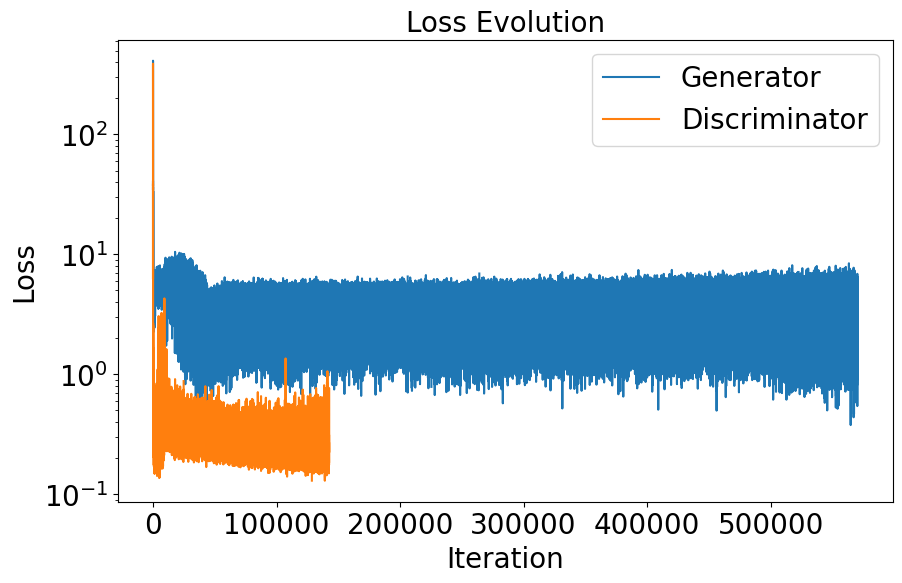

In [18]:
import matplotlib.pyplot as plt

# these loss values are from V1. We have fixed our bugs
# and resumed training
p_loss_g = torch.load('outputs/prev_generator.losses')
p_loss_d = torch.load('outputs/prev_discriminator.losses')



loss_g = p_loss_g + torch.load('outputs/generator.losses')
loss_d = p_loss_d + torch.load('outputs/discriminator.losses')


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss_g, label='Generator')
ax.plot(loss_d, label='Discriminator')
ax.set_yscale('log')
ax.set_xlabel('Iteration', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
ax.set_title('Loss Evolution', fontsize=20)
fig.savefig('outputs/loss_evolution.png')

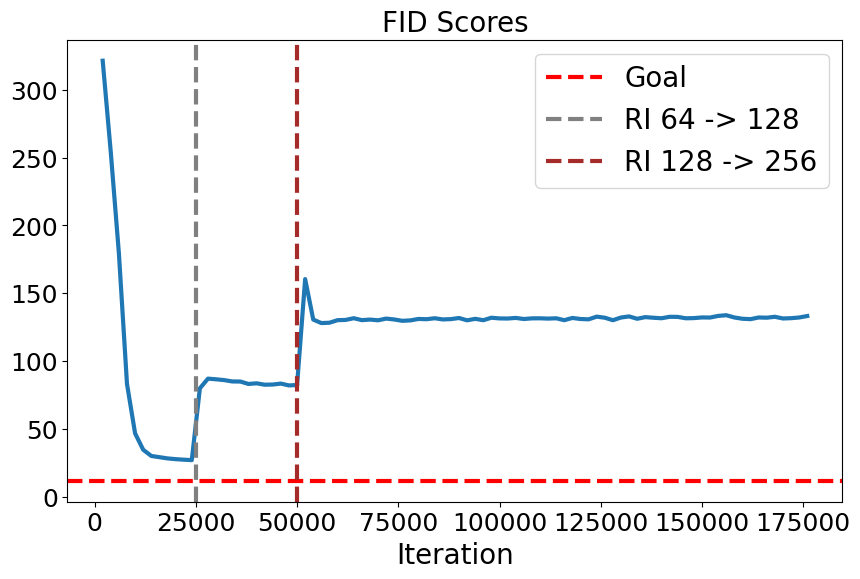

In [23]:
iterations = []
fids = []
with open('outputs/fid.txt') as f:
    for line in f:
        [i, fid] = line.split(':')
        iterations.append(int(i))
        fids.append(float(fid))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(iterations, fids, linewidth=3)
ax.axhline(y=11.8, label='Goal', color='red', linewidth=3, linestyle='--')
ax.set_xlabel('Iteration', fontsize=20)
ax.axvline(x=25000, label='RI 64 -> 128', color='gray', linewidth=3, linestyle='--')
ax.axvline(x=50000, label='RI 128 -> 256', color='brown', linewidth=3, linestyle='--')
ax.tick_params(labelsize=18)
ax.set_title('FID Scores', fontsize=20)
ax.legend(fontsize=20)
fig.savefig('outputs/fid_scores.png')